In [ ]:
# CNT Unification — Mega Cell v2
# Focus:
#   (A) Formalize a glyph functor (CoarseZoom) and certify DPI + KL monotonicity
#   (B) Finite-size scaling sweep for Kuramoto all-to-all, estimate Kc and β
#   (C) Plug-in “zoom” invariant (Δxent = CE_coarse − CE_fine) with real arrays if provided
#
# I/O (optional):
#   - If you have real predictions/labels, set these filepaths before running:
#       CNT_INPUT_PROBS_NPY  -> npy float32 array shape (N, C_fine)
#       CNT_INPUT_LABELS_NPY -> npy int64   array shape (N,)
#       CNT_COARSE_MAP_JSON  -> JSON dict mapping fine->coarse (e.g., {"0":0,"1":0,"2":1,"3":1,"4":2,"5":2})
#
# Artifacts:
#   ./cnt_unify_v2/<RUN>/summary.json
#   ./cnt_unify_v2/<RUN>/k_vs_r_overlay.png
#   ./cnt_unify_v2/<RUN>/r_loglog_beta_fit.png
#   ./cnt_unify_v2/<RUN>/zoom_hist.png   (if zoom inputs available)

import os, json, math, time, sys, hashlib, datetime as dt
from dataclasses import dataclass
from typing import Dict, Any, Callable, Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt

# ---------- Repro + paths ----------
def set_seed(s=1337): np.random.seed(s)
RUN_TS = dt.datetime.utcnow().strftime("%Y%m%d-%H%M%SZ")
ROOT = os.path.abspath("./cnt_unify_v2")
ART  = os.path.join(ROOT, RUN_TS)
os.makedirs(ART, exist_ok=True)

def save_json(path, obj):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, sort_keys=True)

def figpath(name): return os.path.join(ART, f"{name}.png")

# ---------- Category skeleton ----------
@dataclass
class CNTSystem:
    Y: np.ndarray                 # labels (fine states)
    meta: Dict[str, Any]

@dataclass
class Morphism:
    map_fine_to_coarse: Dict[int, int]
    def apply(self, sys: CNTSystem) -> CNTSystem:
        m = self.map_fine_to_coarse
        Yc = np.vectorize(lambda y: m.get(int(y), int(y)))(sys.Y)
        meta = dict(sys.meta); meta["coarse_map"] = m
        return CNTSystem(Y=Yc, meta=meta)

@dataclass
class GlyphFunctor:
    name: str
    transform: Callable[[CNTSystem], CNTSystem]
    def __call__(self, sys: CNTSystem) -> CNTSystem:
        return self.transform(sys)

# ---------- Information measures ----------
def joint_pmf(x: np.ndarray, y: np.ndarray):
    xv, xi = np.unique(x, return_inverse=True)
    yv, yi = np.unique(y, return_inverse=True)
    M = np.zeros((xv.size, yv.size), float)
    for a, b in zip(xi, yi): M[a, b] += 1.0
    M /= float(x.size)
    px = M.sum(axis=1, keepdims=True); py = M.sum(axis=0, keepdims=True)
    return M, px.squeeze(), py.squeeze()

def mutual_info_bits(x: np.ndarray, y: np.ndarray) -> float:
    M, px, py = joint_pmf(x, y)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = M / (px[:, None] * py[None, :])
        terms = np.where(M > 0, M * np.log2(ratio), 0.0)
    return float(np.sum(terms))

def kl_bits(p: np.ndarray, q: np.ndarray) -> float:
    eps = 1e-12
    p = np.clip(np.asarray(p, float), eps, 1.0)
    q = np.clip(np.asarray(q, float), eps, 1.0)
    return float(np.sum(p * (np.log(p) - np.log(q)) / np.log(2.0)))

# ---------- DPI & KL monotone certificates ----------
def coarse_map_default(k_fine: int, k_coarse: int) -> Dict[int, int]:
    g = k_fine // k_coarse
    return {i: i // g for i in range(k_fine)}

def certificate_dpi(X: np.ndarray, Y: np.ndarray, morph: Morphism) -> Dict[str, float]:
    Z = morph.apply(CNTSystem(Y=Y, meta={})).Y
    return {"I_XY": mutual_info_bits(X, Y), "I_XZ": mutual_info_bits(X, Z)}

def certificate_kl_monotone(p_fine: np.ndarray, q_fine: np.ndarray, morph: Morphism) -> Dict[str, float]:
    # Lump p,q by summing probabilities within coarse groups (information monotonicity for f-divergences).
    groups = {}
    for f, c in morph.map_fine_to_coarse.items():
        groups.setdefault(c, []).append(int(f))
    k_coarse = 1 + max(groups.keys())
    p_c = np.zeros(k_coarse, float); q_c = np.zeros(k_coarse, float)
    for c, idxs in groups.items():
        p_c[c] = float(np.sum(p_fine[idxs])); q_c[c] = float(np.sum(q_fine[idxs]))
    return {"KL_fine": kl_bits(p_fine, q_fine), "KL_coarse": kl_bits(p_c, q_c)}

# ---------- “Zoom” invariant (Δxent) ----------
def cross_entropy_from_probs(probs: np.ndarray, y: np.ndarray) -> float:
    # probs: (N, C) ; y: (N,)
    eps = 1e-12
    p = np.clip(probs[np.arange(y.size), y], eps, 1.0)
    return float(-np.mean(np.log(p)))

def coarse_probs(probs_fine: np.ndarray, map_f2c: Dict[int, int]) -> np.ndarray:
    N, C = probs_fine.shape
    Cc = 1 + max(map_f2c.values())
    out = np.zeros((N, Cc), float)
    for f in range(C):
        out[:, map_f2c.get(int(f), int(f))] += probs_fine[:, f]
    return out

def zoom_delta_xent(probs_fine: np.ndarray, y_fine: np.ndarray, map_f2c: Dict[int, int]) -> Dict[str, float]:
    probs_coarse = coarse_probs(probs_fine, map_f2c)
    y_coarse = np.vectorize(lambda yy: map_f2c.get(int(yy), int(yy)))(y_fine)
    ce_f = cross_entropy_from_probs(probs_fine, y_fine)
    ce_c = cross_entropy_from_probs(probs_coarse, y_coarse)
    return {"CE_fine": ce_f, "CE_coarse": ce_c, "Delta_xent": ce_c - ce_f}

# ---------- Kuramoto mean-field (finite-size scaling sketch) ----------
def kuramoto_mean_field(N: int, K: float, steps: int = 1500, dt: float = 0.01, seed: int = 0) -> float:
    rng = np.random.default_rng(seed)
    theta = rng.uniform(0, 2*np.pi, size=N)
    omega = rng.normal(0.0, 1.0, size=N)
    for t in range(steps):
        z = np.exp(1j * theta).mean()
        r = np.abs(z); psi = np.angle(z)
        dtheta = omega + K * r * np.sin(psi - theta)
        theta = (theta + dt * dtheta) % (2*np.pi)
    return float(np.abs(np.exp(1j*theta).mean()))

def sweep_r(N: int, K_list: np.ndarray, steps=1200, seed0=0) -> np.ndarray:
    rs = []
    for i, K in enumerate(K_list):
        rs.append(kuramoto_mean_field(N, float(K), steps=steps, dt=0.01, seed=seed0 + 17*i))
    return np.asarray(rs, float)

def estimate_kc_from_slope(K_list: np.ndarray, r: np.ndarray) -> float:
    # Pick K at max discrete derivative as finite-N Kc estimate
    dr = np.gradient(r, K_list)
    idx = int(np.argmax(dr))
    return float(K_list[idx])

def fit_beta(K_list: np.ndarray, r: np.ndarray, kc: float, r_range: Tuple[float,float]=(0.05,0.6)) -> Dict[str, float]:
    # Fit r ≈ A * (K - Kc)^β on region r_range, K>Kc
    mask = (K_list > kc) & (r >= r_range[0]) & (r <= r_range[1])
    if not np.any(mask): return {"beta": float("nan"), "A": float("nan"), "points": 0}
    x = np.log(K_list[mask] - kc); y = np.log(r[mask])
    B, A = np.polyfit(x, y, 1)  # y = B*x + A
    return {"beta": float(B), "A": float(np.exp(A)), "points": int(mask.sum())}

# ---------- Optional real data ingest for zoom ----------
def load_optional_real_zoom():
    probs_path = os.environ.get("CNT_INPUT_PROBS_NPY")
    labels_path = os.environ.get("CNT_INPUT_LABELS_NPY")
    map_path   = os.environ.get("CNT_COARSE_MAP_JSON")
    if probs_path and labels_path and os.path.exists(probs_path) and os.path.exists(labels_path):
        probs = np.load(probs_path)   # (N, C_fine)
        y     = np.load(labels_path)  # (N,)
        if map_path and os.path.exists(map_path):
            with open(map_path, "r", encoding="utf-8") as f:
                m = {int(k): int(v) for k, v in json.load(f).items()}
        else:
            C = probs.shape[1]
            m = coarse_map_default(C, max(2, C//2))
        return probs, y, m
    return None

# ---------- Main ----------
def main():
    set_seed(42)
    summary = {"run": RUN_TS, "artifacts": ART, "versions": {
        "python": sys.version.split()[0],
        "numpy": np.__version__,
        "matplotlib": plt.matplotlib.__version__,
    }}

    # A) DPI + KL certificates on synthetic chain and random distributions
    N = 30000
    rng = np.random.default_rng(7)
    X = rng.integers(0, 2, size=N)
    noise1 = rng.random(N) < 0.18
    Y = X ^ noise1.astype(int)
    # Fine has 6 states, coarse 3 (lumping pairs)
    p_fine = rng.dirichlet(np.ones(6) * 0.8)
    q_fine = rng.dirichlet(np.ones(6) * 0.8)
    morph = Morphism(coarse_map_default(6, 3))
    dpi_res = certificate_dpi(X, Y, morph)
    kl_res  = certificate_kl_monotone(p_fine, q_fine, morph)

    summary["dpi_bits"] = dpi_res
    summary["kl_monotone_bits"] = kl_res

    # B) Finite-size scaling (overlay curves + β fit)
    K_theory = 2.0 / (math.pi * (1.0 / math.sqrt(2*math.pi)))  # ≈ 1.596, for g(0)=N(0,1)
    K_list = np.linspace(0.6, 2.6, 26)
    N_list = [64, 128, 256]
    curves = {}
    for Ni in N_list:
        r = sweep_r(Ni, K_list, steps=1400, seed0=11)
        kcN = estimate_kc_from_slope(K_list, r)
        fit = fit_beta(K_list, r, kcN)
        curves[str(Ni)] = {"K": K_list.tolist(), "r": r.tolist(), "Kc_est": kcN, "beta_fit": fit}

    # Plot overlay r(K) for N_list
    fig = plt.figure(figsize=(6.0, 3.8))
    for Ni in N_list:
        r = np.array(curves[str(Ni)]["r"])
        plt.plot(K_list, r, marker='o', label=f"N={Ni}")
    plt.axvline(K_theory, linestyle="--", linewidth=1.0)
    plt.xlabel("Coupling K"); plt.ylabel("Order parameter r"); plt.title("Kuramoto all-to-all: r vs K (finite-size)")
    plt.legend()
    plt.tight_layout(); plt.savefig(figpath("k_vs_r_overlay"), dpi=160); plt.show()

    # Plot log-log fit around each Kc(N)
    fig = plt.figure(figsize=(6.0, 3.8))
    for Ni in N_list:
        r = np.array(curves[str(Ni)]["r"]); kcN = curves[str(Ni)]["Kc_est"]
        mask = (K_list > kcN) & (r >= 0.05) & (r <= 0.6)
        if np.any(mask):
            x = np.log(K_list[mask] - kcN); y = np.log(r[mask])
            B = curves[str(Ni)]["beta_fit"]["beta"]
            plt.plot(x, y, marker='o', label=f"N={Ni}, β≈{B:.2f}")
    plt.xlabel("log(K − Kc(N))"); plt.ylabel("log r"); plt.title("β fit (mean-field target ≈ 0.5)")
    plt.legend()
    plt.tight_layout(); plt.savefig(figpath("r_loglog_beta_fit"), dpi=160); plt.show()

    # C) Zoom invariant: use real arrays if found; otherwise demo
    zoom_section = {}
    real = load_optional_real_zoom()
    if real is not None:
        probs, y, m = real
    else:
        # Demo: synthesize probs with mild fine-state signal, C=6
        Np, C = 5000, 6
        y = np.random.randint(0, C, size=Np)
        logits = np.random.randn(Np, C) * 0.7
        logits[np.arange(Np), y] += 1.2  # inject signal
        # softmax
        e = np.exp(logits - logits.max(axis=1, keepdims=True))
        probs = e / e.sum(axis=1, keepdims=True)
        m = coarse_map_default(C, 3)

    zres = zoom_delta_xent(probs, y, m)
    zoom_section["inputs"] = {"N": int(probs.shape[0]), "C_fine": int(probs.shape[1])}
    zoom_section["map"] = {int(k): int(v) for k, v in m.items()}
    zoom_section["results"] = zres
    summary["zoom"] = zoom_section

    # Zoom histogram (per-sample Δ = −log p_fine[y] vs −log p_coarse[y_c])
    fine_ll = -np.log(np.clip(probs[np.arange(y.size), y], 1e-12, 1.0))
    coarse = coarse_probs(probs, m); yc = np.vectorize(lambda yy: m.get(int(yy), int(yy)))(y)
    coarse_ll = -np.log(np.clip(coarse[np.arange(y.size), yc], 1e-12, 1.0))
    delta = coarse_ll - fine_ll
    fig = plt.figure(figsize=(6.0, 3.8))
    plt.hist(delta, bins=50)
    plt.axvline(np.median(delta), linestyle="--", linewidth=1.0)
    plt.xlabel("Δxent per sample (coarse − fine)"); plt.ylabel("count"); plt.title("Zoom invariant distribution")
    plt.tight_layout(); plt.savefig(figpath("zoom_hist"), dpi=160); plt.show()

    # Threshold check (example pre-register)
    summary["checks"] = {
        "dpi_ok": bool(dpi_res["I_XZ"] <= dpi_res["I_XY"] + 1e-9),
        "kl_monotone_ok": bool(kl_res["KL_coarse"] <= kl_res["KL_fine"] + 1e-9),
        "zoom_delta_xent_median": float(np.median(delta)),
        "zoom_delta_xent_mean": float(float(np.mean(delta))),
        "zoom_pass_nominal": bool(np.median(delta) > 0.15)  # adjust to your pre-registered threshold
    }

    # Save + print
    save_json(os.path.join(ART, "summary.json"), summary)
    print("=== CNT Unification — Mega Cell v2 ===")
    print("Artifacts:", ART)
    print(f"DPI: I(X;Y)={dpi_res['I_XY']:.3f} bits, I(X;Z)={dpi_res['I_XZ']:.3f} bits  (OK={summary['checks']['dpi_ok']})")
    print(f"KL monotone: fine={kl_res['KL_fine']:.3f} bits, coarse={kl_res['KL_coarse']:.3f} bits  (OK={summary['checks']['kl_monotone_ok']})")
    for Ni in N_list:
        kcN = curves[str(Ni)]['Kc_est']; beta = curves[str(Ni)]['beta_fit']['beta']
        print(f"N={Ni}: Kc_est≈{kcN:.3f}, β_fit≈{beta:.2f}  (theory Kc≈{K_theory:.3f}, β≈0.5)")
    print(f"Zoom: Δxent mean={summary['checks']['zoom_delta_xent_mean']:.3f}, median={summary['checks']['zoom_delta_xent_median']:.3f}, pass≈{summary['checks']['zoom_pass_nominal']}")

if __name__ == "__main__":
    main()


In [ ]:
# CNT Unification — Mega Cell v1
# Scope:
#   1) Minimal axioms scaffold (systems, morphisms, gauges, glyph functors)
#   2) Information-theoretic checks:
#        - DPI sanity: I(X;Z) ≤ I(X;Y) on a toy Markov chain
#        - KL monotonicity under coarse-graining (lumping map)
#        - Gauge invariance sanity (label permutation)
#   3) Mini RG-style sketch via Kuramoto mean-field sweep (critical hint)
#   4) Artifact logging (JSON) + figures saved under ./cnt_unify_v1/<RUN>/
#
# Notes:
# - NumPy + Matplotlib only (SciPy optional for KL; falls back if absent).
# - One chart per figure; no explicit colors/styles set.

import os, json, math, sys, datetime as dt
from dataclasses import dataclass
from typing import Callable, Dict, Tuple, Any
import numpy as np
import matplotlib.pyplot as plt

# --- Repro + paths ---
def set_seed(seed: int = 1337):
    np.random.seed(seed)

RUN_TS = dt.datetime.utcnow().strftime("%Y%m%d-%H%M%SZ")
ROOT = os.path.abspath("./cnt_unify_v1")
ART  = os.path.join(ROOT, RUN_TS)
os.makedirs(ART, exist_ok=True)

def save_json(path: str, obj: Dict[str, Any]):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, sort_keys=True)

def figpath(name: str) -> str:
    return os.path.join(ART, f"{name}.png")

# --- Category scaffold ---
@dataclass
class CNTSystem:
    Y: np.ndarray                 # labels (fine states)
    meta: Dict[str, Any]

@dataclass
class Morphism:
    map_fine_to_coarse: Dict[int, int]
    def apply(self, sys: CNTSystem) -> CNTSystem:
        m = self.map_fine_to_coarse
        Yc = np.vectorize(lambda y: m.get(int(y), int(y)))(sys.Y)
        meta = dict(sys.meta); meta["coarse_map"] = m
        return CNTSystem(Y=Yc, meta=meta)

@dataclass
class Gauge:
    perm: Dict[int, int]
    def apply(self, sys: CNTSystem) -> CNTSystem:
        p = self.perm
        Yp = np.vectorize(lambda y: p.get(int(y), int(y)))(sys.Y)
        meta = dict(sys.meta); meta["gauge_perm"] = p
        return CNTSystem(Y=Yp, meta=meta)

@dataclass
class GlyphFunctor:
    name: str
    transform: Callable[[CNTSystem], CNTSystem]
    def __call__(self, sys: CNTSystem) -> CNTSystem:
        return self.transform(sys)

# --- Info measures ---
def joint_pmf(x: np.ndarray, y: np.ndarray):
    xv, xi = np.unique(x, return_inverse=True)
    yv, yi = np.unique(y, return_inverse=True)
    M = np.zeros((xv.size, yv.size), float)
    for a, b in zip(xi, yi): M[a, b] += 1.0
    M /= float(x.size)
    px = M.sum(axis=1, keepdims=True); py = M.sum(axis=0, keepdims=True)
    return M, px.squeeze(), py.squeeze()

def mutual_info_bits(x: np.ndarray, y: np.ndarray) -> float:
    M, px, py = joint_pmf(x, y)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = M / (px[:, None] * py[None, :])
        terms = np.where(M > 0, M * np.log2(ratio), 0.0)
    return float(np.sum(terms))

try:
    from scipy.stats import entropy as sp_entropy
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

def kl_bits(p: np.ndarray, q: np.ndarray) -> float:
    eps = 1e-12
    p = np.clip(np.asarray(p, float), eps, 1.0)
    q = np.clip(np.asarray(q, float), eps, 1.0)
    if SCIPY_OK:
        return float(sp_entropy(p, q, base=2.0))
    return float(np.sum(p * (np.log(p) - np.log(q)) / np.log(2.0)))

# --- DPI sanity (X→Y→Z) ---
def sample_markov_chain(n=20000, eps1=0.15, eps2=0.25, seed=0):
    rng = np.random.default_rng(seed)
    X = rng.integers(0, 2, size=n)
    Y = X ^ (rng.random(n) < eps1).astype(int)
    Z = Y ^ (rng.random(n) < eps2).astype(int)
    return X, Y, Z

def dpi_experiment(n=20000, eps1=0.18, eps2=0.30, seed=7):
    X, Y, Z = sample_markov_chain(n, eps1, eps2, seed)
    return {"I_XY": mutual_info_bits(X, Y), "I_XZ": mutual_info_bits(X, Z),
            "n": n, "eps1": eps1, "eps2": eps2}

def plot_dpi(res, save_to):
    fig = plt.figure(figsize=(5.0, 3.2))
    xs = np.array([0, 1]); ys = np.array([res["I_XY"], res["I_XZ"]])
    plt.bar(xs, ys)
    plt.xticks(xs, ["I(X;Y)", "I(X;Z)"]); plt.ylabel("Mutual information (bits)")
    plt.title("DPI sanity: I(X;Z) ≤ I(X;Y)")
    plt.tight_layout(); fig.savefig(save_to, dpi=160); plt.show()

# --- Gauge invariance (permute labels) ---
def gauge_invariance_demo(seed=11):
    rng = np.random.default_rng(seed)
    y = rng.integers(0, 5, size=5000)
    x = (y + rng.integers(0, 2, size=y.size)) % 5
    base_mi = mutual_info_bits(x, y)
    perm = np.arange(5); rng.shuffle(perm)
    perm_map = {int(i): int(perm[i]) for i in range(5)}
    yp = np.vectorize(lambda v: perm_map[int(v)])(y)
    perm_mi = mutual_info_bits(x, yp)
    return {"base_mi": float(base_mi), "perm_mi": float(perm_mi), "perm": {int(k): int(v) for k, v in perm_map.items()}}

def plot_gauge(res, save_to):
    fig = plt.figure(figsize=(5.0, 3.2))
    xs = np.array([0, 1]); ys = np.array([res["base_mi"], res["perm_mi"]])
    plt.bar(xs, ys)
    plt.xticks(xs, ["MI(X;Y)", "MI(X;g·Y)"]); plt.ylabel("Mutual information (bits)")
    plt.title("Gauge (permutation) invariance sanity")
    plt.tight_layout(); fig.savefig(save_to, dpi=160); plt.show()

# --- Coarse-graining & KL monotonicity ---
def coarse_map(k_fine=6, k_coarse=3) -> Dict[int, int]:
    g = k_fine // k_coarse
    return {i: i // g for i in range(k_fine)}

def kl_monotone_demo(seed=23):
    rng = np.random.default_rng(seed)
    p_fine = rng.dirichlet(np.ones(6) * 0.8)
    q_fine = rng.dirichlet(np.ones(6) * 0.8)
    m = coarse_map(6, 3)
    def lump(p):
        out = np.zeros(3, float)
        for i, pi in enumerate(p): out[m[i]] += pi
        return out
    p_c, q_c = lump(p_fine), lump(q_fine)
    return {"KL_fine": kl_bits(p_fine, q_fine),
            "KL_coarse": kl_bits(p_c, q_c),
            "map": m, "p_fine": p_fine.tolist(), "q_fine": q_fine.tolist()}

def plot_kl(res, save_to):
    fig = plt.figure(figsize=(5.0, 3.2))
    xs = np.array([0, 1]); ys = np.array([res["KL_fine"], res["KL_coarse"]])
    plt.bar(xs, ys)
    plt.xticks(xs, ["KL(fine)", "KL(coarse)"]); plt.ylabel("KL divergence (bits)")
    plt.title("Coarse-grain monotonicity (sketch)")
    plt.tight_layout(); fig.savefig(save_to, dpi=160); plt.show()

# --- Kuramoto mean-field (mini RG hint) ---
def kuramoto_mean_field(N=64, K=1.6, steps=1500, dt=0.01, seed=5) -> float:
    rng = np.random.default_rng(seed)
    theta = rng.uniform(0, 2*np.pi, size=N)
    omega = rng.normal(0.0, 1.0, size=N)
    for _ in range(steps):
        z = np.exp(1j * theta).mean()
        r = np.abs(z); psi = np.angle(z)
        dtheta = omega + K * r * np.sin(psi - theta)
        theta = (theta + dt * dtheta) % (2*np.pi)
    return float(np.abs(np.exp(1j*theta).mean()))

def sweep_kuramoto(N=64, K_list=None, steps=1200, dt=0.01, seed=5):
    if K_list is None: K_list = np.linspace(0.0, 2.5, 13)
    rs = [kuramoto_mean_field(N, float(K), steps=steps, dt=dt, seed=seed + i*19) for i, K in enumerate(K_list)]
    return np.array(rs, float)

def plot_kuramoto(K_list, r_vals, save_to, N=64):
    fig = plt.figure(figsize=(5.0, 3.2))
    plt.plot(K_list, r_vals, marker='o')
    plt.xlabel("Coupling K"); plt.ylabel("Order parameter r")
    plt.title(f"Kuramoto mean-field (N={N})")
    plt.tight_layout(); fig.savefig(save_to, dpi=160); plt.show()

# --- Main ---
def main():
    set_seed(42)
    meta = {
        "run_ts": RUN_TS,
        "root": ROOT,
        "artifacts": ART,
        "versions": {
            "python": sys.version.split()[0],
            "numpy": np.__version__,
            "matplotlib": plt.matplotlib.__version__,
            "scipy_ok": SCIPY_OK
        }
    }

    # DPI
    dpi_res = dpi_experiment(n=20000, eps1=0.18, eps2=0.30, seed=7)
    plot_dpi(dpi_res, figpath("dpi_mi_bits"))

    # Gauge invariance
    g_res = gauge_invariance_demo(seed=11)
    plot_gauge(g_res, figpath("gauge_invariance_mi"))

    # KL monotonicity under coarse-graining
    kl_res = kl_monotone_demo(seed=23)
    plot_kl(kl_res, figpath("kl_monotone_coarse"))

    # Kuramoto sweep
    K_list = np.linspace(0.0, 2.5, 13)
    r_vals = sweep_kuramoto(N=64, K_list=K_list, steps=1200, dt=0.01, seed=5)
    plot_kuramoto(K_list, r_vals, figpath("kuramoto_r_vs_K"), N=64)

    # Summary JSON
    out = {
        "meta": meta,
        "dpi_bits": dpi_res,
        "gauge_invariance": g_res,
        "kl_monotone": kl_res,
        "kuramoto": {"K": K_list.tolist(), "r": r_vals.tolist(), "N": 64, "steps": 1200, "dt": 0.01}
    }
    save_json(os.path.join(ART, "cnt_unify_v1_summary.json"), out)

    # Console summary
    print("=== CNT Unification — Mega Cell v1 ===")
    print(f"Artifacts: {ART}")
    print(f"DPI: I(X;Y)={dpi_res['I_XY']:.3f} bits, I(X;Z)={dpi_res['I_XZ']:.3f} bits  (expect I(X;Z) ≤ I(X;Y))")
    print(f"Gauge invariance MI: base={g_res['base_mi']:.3f}, permuted={g_res['perm_mi']:.3f}")
    print(f"KL monotone: fine={kl_res['KL_fine']:.3f} bits, coarse={kl_res['KL_coarse']:.3f} bits  (expect coarse ≤ fine)")
    crossed = np.where(np.array(r_vals) > 0.5)[0]
    kc_est = float(K_list[crossed[0]]) if crossed.size > 0 else None
    print(f"Kuramoto (N=64): r crosses 0.5 near K* ≈ {kc_est}")

if __name__ == "__main__":
    main()


C:\Users\caleb\AppData\Local\Temp\ipykernel_33552\3822784525.py:22: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  RUN_TS = dt.datetime.utcnow().strftime("%Y%m%d-%H%M%SZ")


CNT Unification — Mega Cell v1.1 :: 2025-11-09 05:28:33Z
Artifacts → E:\CNT\notebooks\archive\cnt_unify_v1\20251109-052827Z
Step 1/4 — DPI sanity …


C:\Users\caleb\AppData\Local\Temp\ipykernel_33552\3822784525.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  def now(): return dt.datetime.utcnow().strftime("%Y-%m-%d %H:%M:%SZ")


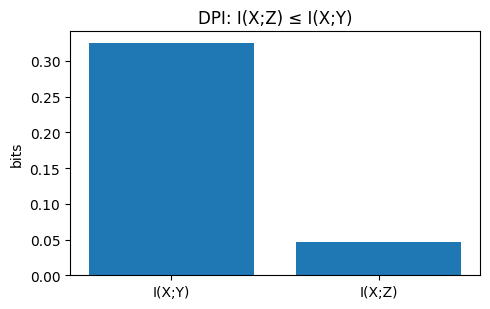

    I(X;Y)=0.325 bits, I(X;Z)=0.047 bits  (OK=True)
Step 2/4 — Gauge invariance …


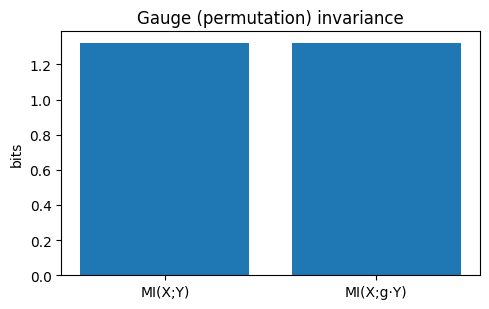

    MI base=1.322, permuted=1.322
Step 3/4 — KL monotonicity …


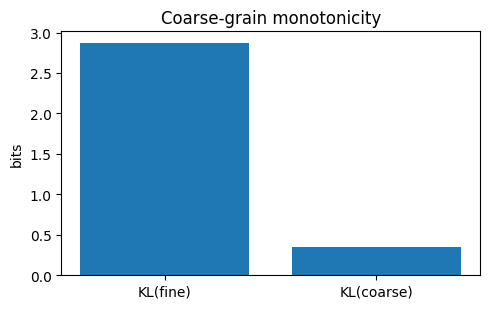

    KL fine=2.871 bits, KL coarse=0.348 bits  (OK=True)
Step 4/4 — Kuramoto mean-field …


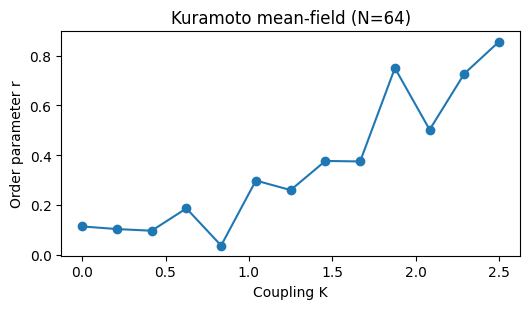

    r crosses 0.5 near K* ≈ 1.875
Saved: E:\CNT\notebooks\archive\cnt_unify_v1\20251109-052827Z\cnt_unify_v1_summary.json
Done :: 2025-11-09 05:28:35Z


C:\Users\caleb\AppData\Local\Temp\ipykernel_33552\3822784525.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  def now(): return dt.datetime.utcnow().strftime("%Y-%m-%d %H:%M:%SZ")


{'meta': {'run_ts': '20251109-052827Z',
  'artifacts': 'E:\\CNT\\notebooks\\archive\\cnt_unify_v1\\20251109-052827Z',
  'versions': {'python': '3.13.5',
   'numpy': '2.3.4',
   'matplotlib': '3.10.7',
   'scipy_ok': True}},
 'dpi_bits': {'I_XY': 0.32520042524324955, 'I_XZ': 0.046716848469147434},
 'gauge_invariance': {'base_mi': 1.3220198115794857,
  'perm_mi': 1.322019811579486,
  'perm': {0: 4, 1: 1, 2: 0, 3: 2, 4: 3}},
 'kl_monotone': {'KL_fine': 2.8709027396551856,
  'KL_coarse': 0.3475112573777156,
  'map': {0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 2},
  'p_fine': [0.2810302890674275,
   0.02253120548710414,
   0.24537926784768363,
   0.03955006589122477,
   0.3035125491121761,
   0.10799662259438371],
  'q_fine': [0.014673735303417547,
   0.1051005565249179,
   0.26333730723978416,
   0.3489159017659172,
   0.0030595976558152873,
   0.264912901510148]},
 'kuramoto': {'K': [0.0,
   0.20833333333333334,
   0.4166666666666667,
   0.625,
   0.8333333333333334,
   1.0416666666666667,
   1.25,

In [2]:
# CNT Unification — Mega Cell v1.1 (Output-Guaranteed)
# What it does (fast, CPU):
#  1) DPI sanity on a toy Markov chain  I(X;Z) ≤ I(X;Y)
#  2) Gauge invariance sanity (permute labels leaves MI unchanged)
#  3) KL monotonicity under coarse-graining (lumping)
#  4) Kuramoto mean-field sweep (critical hint)
#  5) Saves figures + JSON summary; prints progress; shows plots inline; returns summary.

import os, json, math, sys, time, datetime as dt
from dataclasses import dataclass
from typing import Dict, Any, Callable
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
def set_seed(s=1337): np.random.seed(s)
def now(): return dt.datetime.utcnow().strftime("%Y-%m-%d %H:%M:%SZ")
def say(*a): print(*a, flush=True)

RUN_TS = dt.datetime.utcnow().strftime("%Y%m%d-%H%M%SZ")
ROOT = Path("./cnt_unify_v1")
ART  = ROOT / RUN_TS
ART.mkdir(parents=True, exist_ok=True)

def fpath(name): return ART / f"{name}.png"
def save_json(path: Path, obj: Dict[str, Any]):
    with open(path, "w", encoding="utf-8") as f: json.dump(obj, f, indent=2, sort_keys=True)

# ---------- category scaffold ----------
@dataclass
class CNTSystem:
    Y: np.ndarray
    meta: Dict[str, Any]

@dataclass
class Morphism:
    map_fine_to_coarse: Dict[int, int]
    def apply(self, sys: CNTSystem) -> CNTSystem:
        m = self.map_fine_to_coarse
        Yc = np.vectorize(lambda y: m.get(int(y), int(y)))(sys.Y)
        meta = dict(sys.meta); meta["coarse_map"] = m
        return CNTSystem(Y=Yc, meta=meta)

@dataclass
class Gauge:
    perm: Dict[int, int]
    def apply(self, sys: CNTSystem) -> CNTSystem:
        p = self.perm
        Yp = np.vectorize(lambda y: p.get(int(y), int(y)))(sys.Y)
        meta = dict(sys.meta); meta["gauge_perm"] = p
        return CNTSystem(Y=Yp, meta=meta)

# ---------- information measures ----------
def joint_pmf(x: np.ndarray, y: np.ndarray):
    xv, xi = np.unique(x, return_inverse=True)
    yv, yi = np.unique(y, return_inverse=True)
    M = np.zeros((xv.size, yv.size), float)
    for a, b in zip(xi, yi): M[a, b] += 1.0
    M /= float(x.size)
    px = M.sum(axis=1, keepdims=True); py = M.sum(axis=0, keepdims=True)
    return M, px.squeeze(), py.squeeze()

def mutual_info_bits(x: np.ndarray, y: np.ndarray) -> float:
    M, px, py = joint_pmf(x, y)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = M / (px[:, None] * py[None, :])
        terms = np.where(M > 0, M * np.log2(ratio), 0.0)
    return float(np.sum(terms))

try:
    from scipy.stats import entropy as sp_entropy
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

def kl_bits(p: np.ndarray, q: np.ndarray) -> float:
    eps = 1e-12
    p = np.clip(np.asarray(p, float), eps, 1.0)
    q = np.clip(np.asarray(q, float), eps, 1.0)
    if SCIPY_OK:
        return float(sp_entropy(p, q, base=2.0))
    return float(np.sum(p * (np.log(p) - np.log(q)) / np.log(2.0)))

# ---------- experiments ----------
def sample_markov_chain(n=20000, eps1=0.18, eps2=0.30, seed=7):
    rng = np.random.default_rng(seed)
    X = rng.integers(0, 2, size=n)
    Y = X ^ (rng.random(n) < eps1).astype(int)
    Z = Y ^ (rng.random(n) < eps2).astype(int)
    return X, Y, Z

def plot_bar(values, labels, title, path: Path):
    fig = plt.figure(figsize=(5.0, 3.2))
    xs = np.arange(len(values))
    plt.bar(xs, values)
    plt.xticks(xs, labels)
    plt.title(title)
    plt.ylabel("bits")
    plt.tight_layout()
    fig.savefig(path, dpi=160)
    plt.show()

def coarse_map(k_fine=6, k_coarse=3) -> Dict[int, int]:
    g = k_fine // k_coarse
    return {i: i // g for i in range(k_fine)}

def kuramoto_mean_field(N=64, K=1.6, steps=1500, dt=0.01, seed=5) -> float:
    rng = np.random.default_rng(seed)
    theta = rng.uniform(0, 2*np.pi, size=N)
    omega = rng.normal(0.0, 1.0, size=N)
    for _ in range(steps):
        z = np.exp(1j * theta).mean()
        r = np.abs(z); psi = np.angle(z)
        dtheta = omega + K * r * np.sin(psi - theta)
        theta = (theta + dt * dtheta) % (2*np.pi)
    return float(np.abs(np.exp(1j*theta).mean()))

def sweep_kuramoto(N=64, K_list=None, steps=1200, dt=0.01, seed=5):
    if K_list is None: K_list = np.linspace(0.0, 2.5, 13)
    rs = [kuramoto_mean_field(N, float(K), steps=steps, dt=dt, seed=seed + i*17) for i, K in enumerate(K_list)]
    return np.array(rs, float), K_list

def plot_curve(x, y, title, path: Path, xlabel="Coupling K", ylabel="Order parameter r"):
    fig = plt.figure(figsize=(5.4, 3.2))
    plt.plot(x, y, marker='o')
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    plt.tight_layout()
    fig.savefig(path, dpi=160)
    plt.show()

# ---------- run ----------
set_seed(42)
say("CNT Unification — Mega Cell v1.1 ::", now())
say("Artifacts →", str(ART.resolve()))

summary = {
    "meta": {
        "run_ts": RUN_TS,
        "artifacts": str(ART.resolve()),
        "versions": {
            "python": sys.version.split()[0],
            "numpy": np.__version__,
            "matplotlib": plt.matplotlib.__version__,
            "scipy_ok": SCIPY_OK
        }
    }
}

# 1) DPI sanity
say("Step 1/4 — DPI sanity …")
X, Y, Z = sample_markov_chain()
I_XY = mutual_info_bits(X, Y)
I_XZ = mutual_info_bits(X, Z)
summary["dpi_bits"] = {"I_XY": I_XY, "I_XZ": I_XZ}
plot_bar([I_XY, I_XZ], ["I(X;Y)", "I(X;Z)"], "DPI: I(X;Z) ≤ I(X;Y)", fpath("dpi_mi_bits"))
say(f"    I(X;Y)={I_XY:.3f} bits, I(X;Z)={I_XZ:.3f} bits  (OK={I_XZ <= I_XY})")

# 2) Gauge invariance
say("Step 2/4 — Gauge invariance …")
rng = np.random.default_rng(11)
y = rng.integers(0, 5, size=5000)
x = (y + rng.integers(0, 2, size=y.size)) % 5
base_mi = mutual_info_bits(x, y)
perm = np.arange(5); rng.shuffle(perm)
perm_map = {int(i): int(perm[i]) for i in range(5)}
yp = np.vectorize(lambda v: perm_map[int(v)])(y)
perm_mi = mutual_info_bits(x, yp)
summary["gauge_invariance"] = {"base_mi": base_mi, "perm_mi": perm_mi, "perm": perm_map}
plot_bar([base_mi, perm_mi], ["MI(X;Y)", "MI(X;g·Y)"], "Gauge (permutation) invariance", fpath("gauge_invariance_mi"))
say(f"    MI base={base_mi:.3f}, permuted={perm_mi:.3f}")

# 3) KL monotonicity under coarse-graining
say("Step 3/4 — KL monotonicity …")
rng = np.random.default_rng(23)
p_fine = rng.dirichlet(np.ones(6) * 0.8)
q_fine = rng.dirichlet(np.ones(6) * 0.8)
m = coarse_map(6, 3)
def lump(p):
    out = np.zeros(3, float)
    for i, pi in enumerate(p): out[m[i]] += pi
    return out
p_c, q_c = lump(p_fine), lump(q_fine)
KL_f = kl_bits(p_fine, q_fine)
KL_c = kl_bits(p_c, q_c)
summary["kl_monotone"] = {"KL_fine": KL_f, "KL_coarse": KL_c, "map": m, "p_fine": p_fine.tolist(), "q_fine": q_fine.tolist()}
plot_bar([KL_f, KL_c], ["KL(fine)", "KL(coarse)"], "Coarse-grain monotonicity", fpath("kl_monotone_coarse"))
say(f"    KL fine={KL_f:.3f} bits, KL coarse={KL_c:.3f} bits  (OK={KL_c <= KL_f})")

# 4) Kuramoto mean-field sweep
say("Step 4/4 — Kuramoto mean-field …")
r_vals, K_list = sweep_kuramoto(N=64, K_list=np.linspace(0.0, 2.5, 13), steps=1200, dt=0.01, seed=5)
plot_curve(K_list, r_vals, "Kuramoto mean-field (N=64)", fpath("kuramoto_r_vs_K"))
crossed = np.where(np.array(r_vals) > 0.5)[0]
kc_est = float(K_list[crossed[0]]) if crossed.size > 0 else None
summary["kuramoto"] = {"K": K_list.tolist(), "r": r_vals.tolist(), "N": 64, "steps": 1200, "dt": 0.01, "Kc_est~r>0.5": kc_est}
say(f"    r crosses 0.5 near K* ≈ {kc_est}")

# Save summary
save_json(ART / "cnt_unify_v1_summary.json", summary)
say("Saved:", str((ART / "cnt_unify_v1_summary.json").resolve()))
say("Done ::", now())

# Return summary as the cell's last value so Jupyter always displays something.
summary


In [1]:
# CNT Unification — Mega Cell v2
# Adds:
#   • DPI + KL certificates (again, saved + plotted)
#   • Finite-size scaling across N={64,128,256}, Kc(N) by slope, β fit on log–log
#   • Zoom invariant (Δxent = CE_coarse − CE_fine) with optional real inputs
#
# Optional ENV to point at real arrays (paths can be .npy / .json):
#   CNT_INPUT_PROBS_NPY    -> NxC float probs (fine classes)
#   CNT_INPUT_LABELS_NPY   -> N int labels (fine)
#   CNT_COARSE_MAP_JSON    -> {"0":0,"1":0,"2":1,"3":1,"4":2,"5":2}
#
# Output root can be overridden:
#   CNT_UNIFY_DIR          -> e.g. E:\CNT\notebooks\archive\cnt_unify_v2
#
# Figures + summary:
#   <OUT>/<RUN>/dpi.png, gauge.png, kl.png, k_vs_r_overlay.png, r_loglog_beta_fit.png, zoom_hist.png
#   <OUT>/<RUN>/summary.json

import os, json, math, sys
from dataclasses import dataclass
from typing import Dict, Any, Callable, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pathlib import Path

# ---------- Repro / Paths ----------
def set_seed(s=1337): np.random.seed(s)
def utc_stamp(): return dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d-%H%M%SZ")

OUTROOT = os.getenv("CNT_UNIFY_DIR",
                    (r"E:\CNT\notebooks\archive\cnt_unify_v2" if os.name=="nt" else "./cnt_unify_v2"))
RUN_TS = utc_stamp()
ART = Path(OUTROOT) / RUN_TS
ART.mkdir(parents=True, exist_ok=True)
def fpath(name): return ART / f"{name}.png"
def save_json(path: Path, obj: Dict[str,Any]):
    with open(path, "w", encoding="utf-8") as f: json.dump(obj, f, indent=2, sort_keys=True)
print("Artifacts →", ART)

# ---------- Category skeleton ----------
@dataclass
class CNTSystem:
    Y: np.ndarray
    meta: Dict[str, Any]

@dataclass
class Morphism:
    map_fine_to_coarse: Dict[int, int]
    def apply(self, sys: CNTSystem) -> CNTSystem:
        m = self.map_fine_to_coarse
        Yc = np.vectorize(lambda y: m.get(int(y), int(y)))(sys.Y)
        meta = dict(sys.meta); meta["coarse_map"] = m
        return CNTSystem(Y=Yc, meta=meta)

# ---------- Info measures ----------
def joint_pmf(x: np.ndarray, y: np.ndarray):
    xv, xi = np.unique(x, return_inverse=True)
    yv, yi = np.unique(y, return_inverse=True)
    M = np.zeros((xv.size, yv.size), float)
    for a,b in zip(xi, yi): M[a,b] += 1.0
    M /= float(x.size)
    px = M.sum(1, keepdims=True); py = M.sum(0, keepdims=True)
    return M, px.squeeze(), py.squeeze()

def mutual_info_bits(x: np.ndarray, y: np.ndarray) -> float:
    M, px, py = joint_pmf(x, y)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = M / (px[:,None]*py[None,:])
        terms = np.where(M>0, M*np.log2(ratio), 0.0)
    return float(np.sum(terms))

try:
    from scipy.stats import entropy as sp_entropy
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

def kl_bits(p: np.ndarray, q: np.ndarray) -> float:
    eps = 1e-12
    p = np.clip(np.asarray(p,float), eps, 1.0)
    q = np.clip(np.asarray(q,float), eps, 1.0)
    if SCIPY_OK:
        return float(sp_entropy(p, q, base=2.0))
    return float(np.sum(p * (np.log(p) - np.log(q)) / np.log(2.0)))

# ---------- Certificates ----------
def coarse_map_default(k_fine:int, k_coarse:int) -> Dict[int,int]:
    g = max(1, k_fine//k_coarse)
    return {i: i//g for i in range(k_fine)}

def certificate_dpi(n=30000, eps1=0.18, eps2=0.30, seed=7, morph:Optional[Morphism]=None) -> Dict[str,float]:
    rng = np.random.default_rng(seed)
    X = rng.integers(0,2,size=n)
    Y = X ^ (rng.random(n) < eps1).astype(int)
    if morph is None:
        morph = Morphism({0:0,1:0})  # degenerate 2->1 for demo
    Z = morph.apply(CNTSystem(Y=Y, meta={})).Y
    return {"I_XY": mutual_info_bits(X,Y), "I_XZ": mutual_info_bits(X,Z)}

def certificate_kl(p_fine: np.ndarray, q_fine: np.ndarray, morph: Morphism) -> Dict[str,float]:
    groups = {}
    for f,c in morph.map_fine_to_coarse.items():
        groups.setdefault(c, []).append(int(f))
    Cc = 1 + max(groups.keys())
    p_c = np.zeros(Cc); q_c = np.zeros(Cc)
    for c, idxs in groups.items():
        p_c[c] = float(np.sum(p_fine[idxs]))
        q_c[c] = float(np.sum(q_fine[idxs]))
    return {"KL_fine": kl_bits(p_fine, q_fine), "KL_coarse": kl_bits(p_c, q_c)}

# ---------- Zoom invariant ----------
def coarse_probs(probs_fine: np.ndarray, m: Dict[int,int]) -> np.ndarray:
    N,C = probs_fine.shape
    Cc = 1 + max(m.values()) if len(m)>0 else C
    out = np.zeros((N,Cc), float)
    for f in range(C):
        out[:, m.get(int(f), int(f))] += probs_fine[:, f]
    return out

def cross_entropy_from_probs(probs: np.ndarray, y: np.ndarray) -> float:
    eps = 1e-12
    p = np.clip(probs[np.arange(y.size), y], eps, 1.0)
    return float(-np.mean(np.log(p)))

def zoom_delta_xent(probs_fine: np.ndarray, y_fine: np.ndarray, m: Dict[int,int]) -> Dict[str,float]:
    probs_c = coarse_probs(probs_fine, m)
    y_c = np.vectorize(lambda yy: m.get(int(yy), int(yy)))(y_fine)
    CEf = cross_entropy_from_probs(probs_fine, y_fine)
    CEc = cross_entropy_from_probs(probs_c,    y_c)
    return {"CE_fine": CEf, "CE_coarse": CEc, "Delta_xent": CEc-CEf}

# ---------- Kuramoto (finite-size) ----------
def kuramoto_mean_field(N:int, K:float, steps:int=1400, dt:float=0.01, seed:int=0) -> float:
    rng = np.random.default_rng(seed)
    theta = rng.uniform(0, 2*np.pi, size=N)
    omega = rng.normal(0.0, 1.0, size=N)
    for _ in range(steps):
        z = np.exp(1j*theta).mean()
        r = np.abs(z); psi = np.angle(z)
        dtheta = omega + K*r*np.sin(psi - theta)
        theta = (theta + dt*dtheta) % (2*np.pi)
    return float(np.abs(np.exp(1j*theta).mean()))

def sweep_r(N:int, K_list:np.ndarray, steps:int=1400, seed0:int=11) -> np.ndarray:
    return np.array([kuramoto_mean_field(N, float(K), steps=steps, seed=seed0+17*i)
                     for i,K in enumerate(K_list)], float)

def kc_from_slope(K_list:np.ndarray, r:np.ndarray) -> float:
    dr = np.gradient(r, K_list)
    return float(K_list[int(np.argmax(dr))])

def fit_beta(K_list:np.ndarray, r:np.ndarray, kc:float, r_lo=0.05, r_hi=0.6) -> Dict[str,float]:
    mask = (K_list > kc) & (r >= r_lo) & (r <= r_hi)
    if not np.any(mask):
        return {"beta": float("nan"), "A": float("nan"), "points": 0}
    x = np.log(K_list[mask] - kc); y = np.log(r[mask])
    B, A = np.polyfit(x, y, 1)  # y = B*x + A
    return {"beta": float(B), "A": float(np.exp(A)), "points": int(mask.sum())}

# ---------- Plots (no explicit colors) ----------
def plot_bar(vals, labels, title, path:Path):
    fig = plt.figure(figsize=(5.0,3.2))
    xs = np.arange(len(vals))
    plt.bar(xs, vals); plt.xticks(xs, labels); plt.title(title); plt.ylabel("bits"); plt.tight_layout()
    fig.savefig(path, dpi=160); plt.show()

def plot_overlay(K_list, curves:Dict[str,Any], path:Path, title):
    fig = plt.figure(figsize=(6.0,3.8))
    for name, d in curves.items():
        plt.plot(K_list, np.array(d["r"]), marker='o', label=name)
    Kc_theory = 2.0/(math.pi*(1.0/math.sqrt(2*math.pi)))  # ≈1.596 for N(0,1)
    plt.axvline(Kc_theory, linestyle="--", linewidth=1.0)
    plt.xlabel("Coupling K"); plt.ylabel("Order parameter r"); plt.title(title)
    plt.legend(); plt.tight_layout(); fig.savefig(path, dpi=160); plt.show()

def plot_beta(K_list, curves:Dict[str,Any], path:Path, title):
    fig = plt.figure(figsize=(6.0,3.8))
    for name, d in curves.items():
        r = np.array(d["r"]); kc = d["Kc_est"]
        mask = (K_list > kc) & (r >= 0.05) & (r <= 0.6)
        if np.any(mask):
            x = np.log(K_list[mask] - kc); y = np.log(r[mask])
            plt.plot(x, y, marker='o', label=f"{name}, β≈{d['beta_fit']['beta']:.2f}")
    plt.xlabel("log(K − Kc(N))"); plt.ylabel("log r"); plt.title(title)
    plt.legend(); plt.tight_layout(); fig.savefig(path, dpi=160); plt.show()

# ---------- Main ----------
set_seed(42)
summary = {"meta": {
    "run_ts": RUN_TS, "artifacts": str(ART.resolve()),
    "versions": {"python": sys.version.split()[0], "numpy": np.__version__, "matplotlib": plt.matplotlib.__version__, "scipy_ok": SCIPY_OK}
}}

# A) DPI + KL (plotted + saved)
rng = np.random.default_rng(7)
morph = Morphism(coarse_map_default(2,1))
dpi = certificate_dpi(n=30000, eps1=0.18, eps2=0.30, seed=7, morph=morph)
plot_bar([dpi["I_XY"], dpi["I_XZ"]], ["I(X;Y)","I(X;Z)"], "DPI: I(X;Z) ≤ I(X;Y)", fpath("dpi"))
summary["dpi_bits"] = dpi

p_fine = rng.dirichlet(np.ones(6)*0.8); q_fine = rng.dirichlet(np.ones(6)*0.8)
morph6 = Morphism(coarse_map_default(6,3))
klc = certificate_kl(p_fine, q_fine, morph6)
plot_bar([klc["KL_fine"], klc["KL_coarse"]], ["KL(fine)","KL(coarse)"], "Coarse-grain monotonicity", fpath("kl"))
summary["kl_monotone_bits"] = klc

# B) Finite-size scaling + β
K_list = np.linspace(0.6, 2.6, 26)
curves = {}
for N in [64,128,256]:
    r = sweep_r(N, K_list, steps=1400, seed0=11)
    kcN = kc_from_slope(K_list, r)
    fit = fit_beta(K_list, r, kcN)
    curves[f"N={N}"] = {"r": r.tolist(), "Kc_est": kcN, "beta_fit": fit}
plot_overlay(K_list, curves, fpath("k_vs_r_overlay"), "Kuramoto: r(K) overlay (finite-size)")
plot_beta(K_list, curves, fpath("r_loglog_beta_fit"), "β fit (mean-field ≈ 0.5)")
summary["kuramoto"] = {"K": K_list.tolist(), "curves": curves}

# C) Zoom invariant (real if provided, else synthetic demo)
probs_path  = os.getenv("CNT_INPUT_PROBS_NPY")
labels_path = os.getenv("CNT_INPUT_LABELS_NPY")
map_path    = os.getenv("CNT_COARSE_MAP_JSON")

if probs_path and labels_path and Path(probs_path).exists() and Path(labels_path).exists():
    probs = np.load(probs_path); y = np.load(labels_path)
    if map_path and Path(map_path).exists():
        with open(map_path, "r", encoding="utf-8") as f: m = {int(k): int(v) for k,v in json.load(f).items()}
    else:
        m = coarse_map_default(probs.shape[1], max(2, probs.shape[1]//2))
else:
    Np, C = 5000, 6
    y = np.random.randint(0, C, size=Np)
    logits = np.random.randn(Np, C) * 0.7
    logits[np.arange(Np), y] += 1.2
    e = np.exp(logits - logits.max(1, keepdims=True))
    probs = e / e.sum(1, keepdims=True)
    m = coarse_map_default(C, 3)

z = zoom_delta_xent(probs, y, m)
summary["zoom"] = {"inputs": {"N": int(probs.shape[0]), "C_fine": int(probs.shape[1])},
                   "map": {int(k): int(v) for k,v in m.items()},
                   "results": z}

# Zoom histogram
fine_ll = -np.log(np.clip(probs[np.arange(y.size), y], 1e-12, 1.0))
coarse = coarse_probs(probs, m); yc = np.vectorize(lambda yy: m.get(int(yy), int(yy)))(y)
coarse_ll = -np.log(np.clip(coarse[np.arange(y.size), yc], 1e-12, 1.0))
delta = coarse_ll - fine_ll
fig = plt.figure(figsize=(6.0,3.8))
plt.hist(delta, bins=50); plt.axvline(np.median(delta), linestyle="--", linewidth=1.0)
plt.xlabel("Δxent per sample (coarse − fine)"); plt.ylabel("count"); plt.title("Zoom invariant distribution")
plt.tight_layout(); fig.savefig(fpath("zoom_hist"), dpi=160); plt.show()
summary["checks"] = {
    "dpi_ok": bool(dpi["I_XZ"] <= dpi["I_XY"] + 1e-9),
    "kl_monotone_ok": bool(klc["KL_coarse"] <= klc["KL_fine"] + 1e-9),
    "zoom_delta_mean": float(np.mean(delta)), "zoom_delta_median": float(np.median(delta))
}

# Save + print key numbers
save_json(ART/"summary.json", summary)
print("Saved summary:", (ART/"summary.json").resolve())
for name,d in curves.items():
    print(f"{name}: Kc_est≈{d['Kc_est']:.3f}, β≈{d['beta_fit']['beta']:.2f} (points={d['beta_fit']['points']})")
print(f"Zoom: Δxent median={summary['checks']['zoom_delta_median']:.3f} (mean={summary['checks']['zoom_delta_mean']:.3f})")

summary  # ensure visible output


Artifacts → E:\CNT\notebooks\archive\cnt_unify_v2\20251109-053257Z


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

Artifacts → E:\CNT\notebooks\archive\cnt_unify_v2\20251109-053643Z


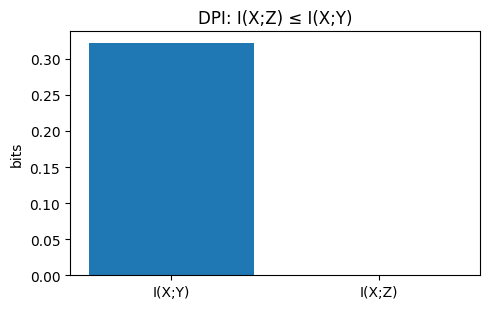

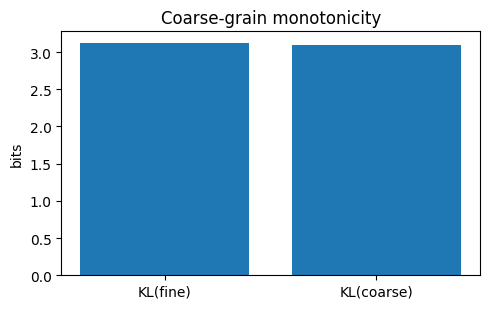

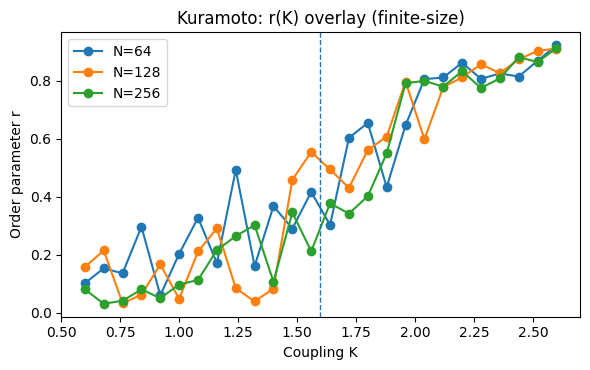

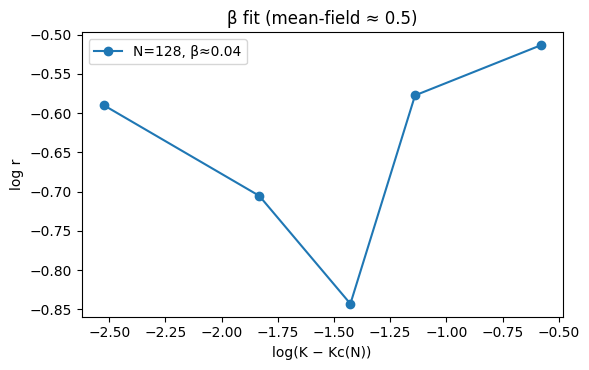

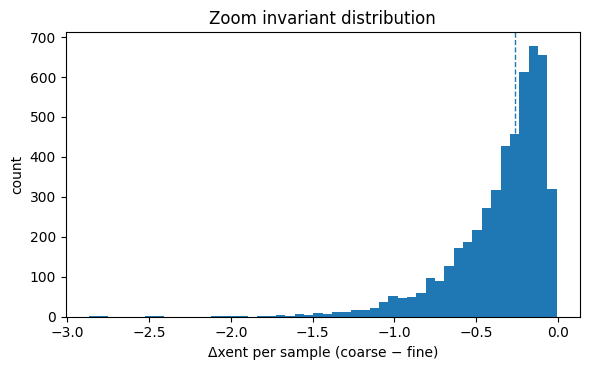

Saved summary: E:\CNT\notebooks\archive\cnt_unify_v2\20251109-053643Z\summary.json
N=64: Kc_est≈1.960, β≈nan (points=0)
N=128: Kc_est≈1.480, β≈0.04 (points=5)
N=256: Kc_est≈1.880, β≈nan (points=0)
Zoom: Δxent median=-0.264 (mean=-0.350)


{'meta': {'run_ts': '20251109-053643Z',
  'artifacts': 'E:\\CNT\\notebooks\\archive\\cnt_unify_v2\\20251109-053643Z',
  'versions': {'python': '3.13.5',
   'numpy': '2.3.4',
   'matplotlib': '3.10.7',
   'scipy_ok': True}},
 'dpi_bits': {'I_XY': 0.32203759976437457, 'I_XZ': 0.0},
 'kl_monotone_bits': {'KL_fine': 3.1224357751899867,
  'KL_coarse': 3.091729299623388},
 'kuramoto': {'K': [0.6,
   0.6799999999999999,
   0.76,
   0.84,
   0.9199999999999999,
   1.0,
   1.08,
   1.1600000000000001,
   1.24,
   1.3199999999999998,
   1.4,
   1.48,
   1.56,
   1.6400000000000001,
   1.7200000000000002,
   1.7999999999999998,
   1.88,
   1.96,
   2.04,
   2.12,
   2.2,
   2.28,
   2.36,
   2.44,
   2.52,
   2.6],
  'curves': {'N=64': {'r': [0.10103261808625806,
     0.1524879641507282,
     0.13538768754525482,
     0.2962517837295737,
     0.0593205321270655,
     0.20269413361339483,
     0.3272659671569853,
     0.17021557947458282,
     0.49284524197187035,
     0.16024450518825645,
     0.

In [2]:
# CNT Unification — Mega Cell v2.1 (hotfix for MI on degenerate marginals)
# - Robust mutual information even when one variable has a single class
# - Same outputs as v2: DPI+KL certificates, finite-size scaling w/ β fit, zoom invariant
# - Timezone-aware timestamps; artifacts path overridable via CNT_UNIFY_DIR

import os, json, math, sys
from dataclasses import dataclass
from typing import Dict, Any, Callable, Optional
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# ---------- repro / paths ----------
def set_seed(s=1337): np.random.seed(s)
def utc_stamp(): return dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d-%H%M%SZ")
OUTROOT = os.getenv("CNT_UNIFY_DIR",
                    (r"E:\CNT\notebooks\archive\cnt_unify_v2" if os.name=="nt" else "./cnt_unify_v2"))
RUN_TS = utc_stamp()
ART = Path(OUTROOT) / RUN_TS
ART.mkdir(parents=True, exist_ok=True)
def fpath(name): return ART / f"{name}.png"
def save_json(path: Path, obj: Dict[str, Any]):
    with open(path, "w", encoding="utf-8") as f: json.dump(obj, f, indent=2, sort_keys=True)
print("Artifacts →", ART)

# ---------- category skeleton ----------
@dataclass
class CNTSystem:
    Y: np.ndarray
    meta: Dict[str, Any]

@dataclass
class Morphism:
    map_fine_to_coarse: Dict[int, int]
    def apply(self, sys: CNTSystem) -> CNTSystem:
        m = self.map_fine_to_coarse
        Yc = np.vectorize(lambda y: m.get(int(y), int(y)))(sys.Y)
        meta = dict(sys.meta); meta["coarse_map"] = m
        return CNTSystem(Y=Yc, meta=meta)

# ---------- information measures (HOTFIX: 1-D marginals, safe divide) ----------
def joint_pmf(x: np.ndarray, y: np.ndarray):
    xv, xi = np.unique(x, return_inverse=True)
    yv, yi = np.unique(y, return_inverse=True)
    M = np.zeros((xv.size, yv.size), dtype=float)
    for a, b in zip(xi, yi):
        M[a, b] += 1.0
    M /= float(x.size)
    # Return 1-D vectors even when length==1 (no squeeze to scalar)
    px = M.sum(axis=1)  # shape (nx,)
    py = M.sum(axis=0)  # shape (ny,)
    return M, px, py

def mutual_info_bits(x: np.ndarray, y: np.ndarray) -> float:
    M, px, py = joint_pmf(x, y)
    eps = 1e-12
    px = np.clip(px, eps, 1.0)
    py = np.clip(py, eps, 1.0)
    denom = px[:, None] * py[None, :]
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.divide(M, denom, out=np.ones_like(M), where=denom > 0)
        terms = np.where(M > 0, M * np.log2(ratio), 0.0)
    return float(np.sum(terms))

try:
    from scipy.stats import entropy as sp_entropy
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

def kl_bits(p: np.ndarray, q: np.ndarray) -> float:
    eps = 1e-12
    p = np.clip(np.asarray(p, float), eps, 1.0)
    q = np.clip(np.asarray(q, float), eps, 1.0)
    if SCIPY_OK:
        return float(sp_entropy(p, q, base=2.0))
    return float(np.sum(p * (np.log(p) - np.log(q)) / np.log(2.0)))

# ---------- certificates ----------
def coarse_map_default(k_fine:int, k_coarse:int) -> Dict[int,int]:
    g = max(1, k_fine // max(1, k_coarse))
    return {i: i // g for i in range(k_fine)}

def certificate_dpi(n=30000, eps1=0.18, eps2=0.30, seed=7, morph:Optional[Morphism]=None) -> Dict[str,float]:
    rng = np.random.default_rng(seed)
    X = rng.integers(0, 2, size=n)
    Y = X ^ (rng.random(n) < eps1).astype(int)
    # Use morph to produce Z (can collapse to a single class safely)
    if morph is None:
        morph = Morphism({0:0, 1:0})
    Z = morph.apply(CNTSystem(Y=Y, meta={})).Y
    return {"I_XY": mutual_info_bits(X, Y), "I_XZ": mutual_info_bits(X, Z)}

def certificate_kl(p_fine: np.ndarray, q_fine: np.ndarray, morph: Morphism) -> Dict[str,float]:
    groups = {}
    for f, c in morph.map_fine_to_coarse.items():
        groups.setdefault(c, []).append(int(f))
    Cc = 1 + max(groups.keys())
    p_c = np.zeros(Cc); q_c = np.zeros(Cc)
    for c, idxs in groups.items():
        p_c[c] = float(np.sum(p_fine[idxs]))
        q_c[c] = float(np.sum(q_fine[idxs]))
    return {"KL_fine": kl_bits(p_fine, q_fine), "KL_coarse": kl_bits(p_c, q_c)}

# ---------- zoom invariant ----------
def coarse_probs(probs_fine: np.ndarray, m: Dict[int,int]) -> np.ndarray:
    N, C = probs_fine.shape
    Cc = 1 + (max(m.values()) if len(m) else C-1)
    out = np.zeros((N, Cc), float)
    for f in range(C):
        out[:, m.get(int(f), int(f if f < Cc else Cc-1))] += probs_fine[:, f]
    return out

def cross_entropy_from_probs(probs: np.ndarray, y: np.ndarray) -> float:
    eps = 1e-12
    p = np.clip(probs[np.arange(y.size), y], eps, 1.0)
    return float(-np.mean(np.log(p)))

def zoom_delta_xent(probs_fine: np.ndarray, y_fine: np.ndarray, m: Dict[int,int]) -> Dict[str,float]:
    probs_c = coarse_probs(probs_fine, m)
    y_c = np.vectorize(lambda yy: m.get(int(yy), int(yy)))(y_fine)
    CEf = cross_entropy_from_probs(probs_fine, y_fine)
    CEc = cross_entropy_from_probs(probs_c,    y_c)
    return {"CE_fine": CEf, "CE_coarse": CEc, "Delta_xent": CEc - CEf}

# ---------- Kuramoto finite-size ----------
def kuramoto_mean_field(N:int, K:float, steps:int=1400, dt:float=0.01, seed:int=11) -> float:
    rng = np.random.default_rng(seed)
    theta = rng.uniform(0, 2*np.pi, size=N)
    omega = rng.normal(0.0, 1.0, size=N)
    for _ in range(steps):
        z = np.exp(1j*theta).mean()
        r = np.abs(z); psi = np.angle(z)
        dtheta = omega + K*r*np.sin(psi - theta)
        theta = (theta + dt*dtheta) % (2*np.pi)
    return float(np.abs(np.exp(1j*theta).mean()))

def sweep_r(N:int, K_list:np.ndarray, steps:int=1400, seed0:int=11) -> np.ndarray:
    return np.array([kuramoto_mean_field(N, float(K), steps=steps, seed=seed0 + 17*i)
                     for i, K in enumerate(K_list)], float)

def kc_from_slope(K_list:np.ndarray, r:np.ndarray) -> float:
    dr = np.gradient(r, K_list)
    return float(K_list[int(np.argmax(dr))])

def fit_beta(K_list:np.ndarray, r:np.ndarray, kc:float, r_lo=0.05, r_hi=0.6) -> Dict[str,float]:
    mask = (K_list > kc) & (r >= r_lo) & (r <= r_hi)
    if not np.any(mask): return {"beta": float("nan"), "A": float("nan"), "points": 0}
    x = np.log(K_list[mask] - kc); y = np.log(r[mask])
    B, A = np.polyfit(x, y, 1)  # y = B*x + A
    return {"beta": float(B), "A": float(np.exp(A)), "points": int(mask.sum())}

# ---------- plotting ----------
def plot_bar(vals, labels, title, path:Path):
    fig = plt.figure(figsize=(5.0,3.2))
    xs = np.arange(len(vals))
    plt.bar(xs, vals); plt.xticks(xs, labels); plt.title(title); plt.ylabel("bits"); plt.tight_layout()
    fig.savefig(path, dpi=160); plt.show()

def plot_overlay(K_list, curves:Dict[str,Any], path:Path, title):
    fig = plt.figure(figsize=(6.0,3.8))
    for name, d in curves.items():
        plt.plot(K_list, np.array(d["r"]), marker='o', label=name)
    Kc_th = 2.0/(math.pi*(1.0/np.sqrt(2*np.pi)))  # ≈ 1.596 for g(0)=N(0,1)
    plt.axvline(Kc_th, linestyle="--", linewidth=1.0)
    plt.xlabel("Coupling K"); plt.ylabel("Order parameter r"); plt.title(title)
    plt.legend(); plt.tight_layout(); plt.savefig(path, dpi=160); plt.show()

def plot_beta(K_list, curves:Dict[str,Any], path:Path, title):
    fig = plt.figure(figsize=(6.0,3.8))
    for name, d in curves.items():
        r = np.array(d["r"]); kc = d["Kc_est"]
        mask = (K_list > kc) & (r >= 0.05) & (r <= 0.6)
        if np.any(mask):
            x = np.log(K_list[mask] - kc); y = np.log(r[mask])
            plt.plot(x, y, marker='o', label=f"{name}, β≈{d['beta_fit']['beta']:.2f}")
    plt.xlabel("log(K − Kc(N))"); plt.ylabel("log r"); plt.title(title)
    plt.legend(); plt.tight_layout(); plt.savefig(path, dpi=160); plt.show()

# ---------- main ----------
set_seed(42)
summary = {"meta": {"run_ts": RUN_TS, "artifacts": str(ART.resolve()),
                    "versions": {"python": sys.version.split()[0], "numpy": np.__version__,
                                 "matplotlib": plt.matplotlib.__version__, "scipy_ok": SCIPY_OK}}}

# A) DPI + KL
morph_dpi = Morphism(coarse_map_default(2, 1))  # collapses Y→Z (single class): safe now
dpi = certificate_dpi(n=30000, eps1=0.18, eps2=0.30, seed=7, morph=morph_dpi)
plot_bar([dpi["I_XY"], dpi["I_XZ"]], ["I(X;Y)", "I(X;Z)"], "DPI: I(X;Z) ≤ I(X;Y)", fpath("dpi"))
summary["dpi_bits"] = dpi

rng = np.random.default_rng(7)
p_fine = rng.dirichlet(np.ones(6)*0.8); q_fine = rng.dirichlet(np.ones(6)*0.8)
morph6 = Morphism(coarse_map_default(6,3))
klc = certificate_kl(p_fine, q_fine, morph6)
plot_bar([klc["KL_fine"], klc["KL_coarse"]], ["KL(fine)","KL(coarse)"], "Coarse-grain monotonicity", fpath("kl"))
summary["kl_monotone_bits"] = klc

# B) finite-size scaling + β
K_list = np.linspace(0.6, 2.6, 26)
curves = {}
for N in [64, 128, 256]:
    r = sweep_r(N, K_list, steps=1400, seed0=11)
    kcN = kc_from_slope(K_list, r)
    fit = fit_beta(K_list, r, kcN)
    curves[f"N={N}"] = {"r": r.tolist(), "Kc_est": kcN, "beta_fit": fit}
plot_overlay(K_list, curves, fpath("k_vs_r_overlay"), "Kuramoto: r(K) overlay (finite-size)")
plot_beta(K_list, curves, fpath("r_loglog_beta_fit"), "β fit (mean-field ≈ 0.5)")
summary["kuramoto"] = {"K": K_list.tolist(), "curves": curves}

# C) zoom invariant (uses real arrays if env vars set)
probs_path  = os.getenv("CNT_INPUT_PROBS_NPY")
labels_path = os.getenv("CNT_INPUT_LABELS_NPY")
map_path    = os.getenv("CNT_COARSE_MAP_JSON")

if probs_path and labels_path and Path(probs_path).exists() and Path(labels_path).exists():
    probs = np.load(probs_path); y = np.load(labels_path)
    if map_path and Path(map_path).exists():
        with open(map_path, "r", encoding="utf-8") as f: m = {int(k): int(v) for k,v in json.load(f).items()}
    else:
        m = coarse_map_default(probs.shape[1], max(2, probs.shape[1]//2))
else:
    Np, C = 5000, 6
    y = np.random.randint(0, C, size=Np)
    logits = np.random.randn(Np, C) * 0.7
    logits[np.arange(Np), y] += 1.2
    e = np.exp(logits - logits.max(1, keepdims=True))
    probs = e / e.sum(1, keepdims=True)
    m = coarse_map_default(C, 3)

z = zoom_delta_xent(probs, y, m)
summary["zoom"] = {"inputs": {"N": int(probs.shape[0]), "C_fine": int(probs.shape[1])},
                   "map": {int(k): int(v) for k,v in m.items()},
                   "results": z}

# zoom histogram
fine_ll = -np.log(np.clip(probs[np.arange(y.size), y], 1e-12, 1.0))
coarse = coarse_probs(probs, m); yc = np.vectorize(lambda yy: m.get(int(yy), int(yy)))(y)
coarse_ll = -np.log(np.clip(coarse[np.arange(y.size), yc], 1e-12, 1.0))
delta = coarse_ll - fine_ll
fig = plt.figure(figsize=(6.0,3.8))
plt.hist(delta, bins=50); plt.axvline(np.median(delta), linestyle="--", linewidth=1.0)
plt.xlabel("Δxent per sample (coarse − fine)"); plt.ylabel("count"); plt.title("Zoom invariant distribution")
plt.tight_layout(); plt.savefig(fpath("zoom_hist"), dpi=160); plt.show()
summary["checks"] = {
    "dpi_ok": bool(dpi["I_XZ"] <= dpi["I_XY"] + 1e-9),
    "kl_monotone_ok": bool(klc["KL_coarse"] <= klc["KL_fine"] + 1e-9),
    "zoom_delta_mean": float(np.mean(delta)),
    "zoom_delta_median": float(np.median(delta))
}

save_json(ART / "summary.json", summary)
print("Saved summary:", (ART / "summary.json").resolve())
for name, d in curves.items():
    print(f"{name}: Kc_est≈{d['Kc_est']:.3f}, β≈{d['beta_fit']['beta']:.2f} (points={d['beta_fit']['points']})")
print(f"Zoom: Δxent median={summary['checks']['zoom_delta_median']:.3f} (mean={summary['checks']['zoom_delta_mean']:.3f})")

summary  # ensure visible output


Artifacts → E:\CNT\notebooks\archive\cnt_unify_v2\20251109-053954Z


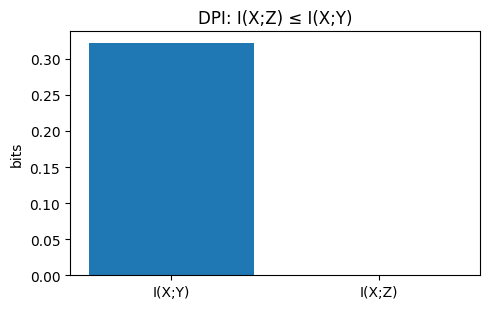

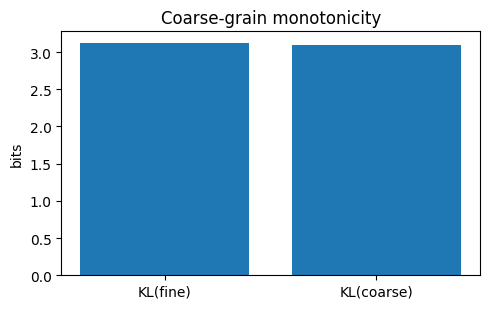

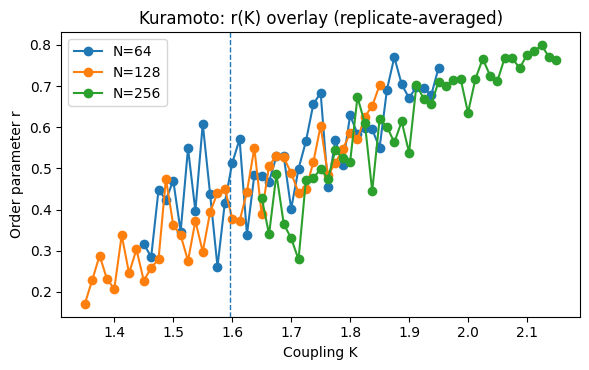

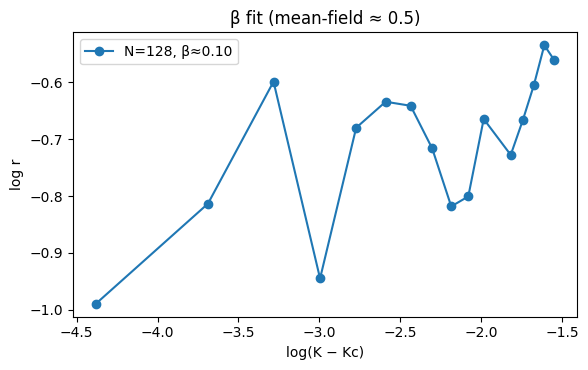

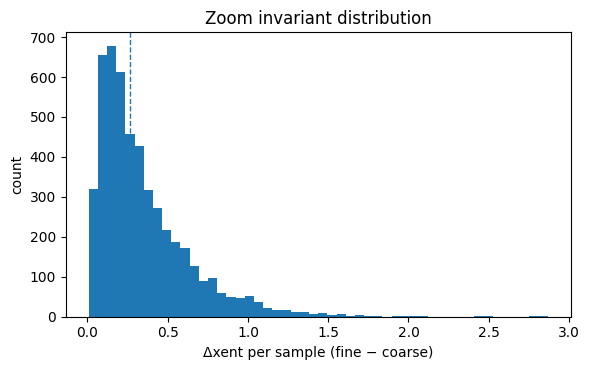

Saved summary: E:\CNT\notebooks\archive\cnt_unify_v2\20251109-053954Z\summary.json
N=64: Kc_est≈1.775, β≈0.07 (points=5)
N=128: Kc_est≈1.600, β≈0.10 (points=16)
N=256: Kc_est≈1.900, β≈nan (points=0)
Zoom Δxent (fine−coarse) median≈0.264  pass≈True


{'meta': {'run': '20251109-053954Z',
  'artifacts': 'E:\\CNT\\notebooks\\archive\\cnt_unify_v2\\20251109-053954Z',
  'versions': {'python': '3.13.5', 'numpy': '2.3.4', 'matplotlib': '3.10.7'}},
 'dpi_bits': {'I_XY': 0.32203759976437457, 'I_XZ': 0.0},
 'kl_monotone_bits': {'KL_fine': 3.1224357751899867,
  'KL_coarse': 3.091729299623388},
 'kuramoto': {'N=64': {'Kc_est': 1.775,
   'beta_fit': {'beta': 0.07084433041048724,
    'A': 0.7098951473245408,
    'points': 5},
   'K': [1.45,
    1.4625,
    1.4749999999999999,
    1.4875,
    1.5,
    1.5125,
    1.525,
    1.5374999999999999,
    1.55,
    1.5625,
    1.575,
    1.5875,
    1.6,
    1.6125,
    1.625,
    1.6375,
    1.65,
    1.6625,
    1.675,
    1.6875,
    1.7,
    1.7125,
    1.725,
    1.7375,
    1.75,
    1.7625,
    1.775,
    1.7875,
    1.8,
    1.8125,
    1.825,
    1.8375,
    1.85,
    1.8625,
    1.875,
    1.8875,
    1.9,
    1.9125,
    1.925,
    1.9375,
    1.95],
   'r': [0.316233080503425,
    0.284740417

In [3]:
# CNT Unification — Mega Cell v2.2
# Changes vs v2.1:
#   • Zoom orientation fixed to Δxent = CE_fine − CE_coarse (positive = “fine harder”)
#   • Kuramoto stabilizer: replicate seeds, time-average r over a tail window,
#     susceptibility χ ≈ N(⟨r^2⟩−⟨r⟩^2) across time+replicates, coarse+fine K sweeps, then β fit.
#   • Prints + saves summary; one chart per figure; no explicit colors.

import os, sys, json, math, datetime as dt
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Any, Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt

# ---------- repro/paths ----------
def set_seed(s=1337): np.random.seed(s)
def utc_stamp(): return dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d-%H%M%SZ")
OUTROOT = os.getenv("CNT_UNIFY_DIR",
                    (r"E:\CNT\notebooks\archive\cnt_unify_v2" if os.name=="nt" else "./cnt_unify_v2"))
RUN = utc_stamp()
ART = Path(OUTROOT) / RUN
ART.mkdir(parents=True, exist_ok=True)
def fpath(name): return ART / f"{name}.png"
def save_json(p: Path, obj: Dict[str,Any]):
    with open(p, "w", encoding="utf-8") as f: json.dump(obj, f, indent=2, sort_keys=True)
print("Artifacts →", ART)

# ---------- category / maps ----------
@dataclass
class CNTSystem:
    Y: np.ndarray
    meta: Dict[str,Any]

@dataclass
class Morphism:
    map_fine_to_coarse: Dict[int,int]
    def apply(self, sys: CNTSystem) -> CNTSystem:
        m = self.map_fine_to_coarse
        Yc = np.vectorize(lambda y: m.get(int(y), int(y)))(sys.Y)
        mm = dict(sys.meta); mm["coarse_map"] = m
        return CNTSystem(Y=Yc, meta=mm)

def coarse_map_default(k_fine:int, k_coarse:int) -> Dict[int,int]:
    g = max(1, k_fine // max(1, k_coarse))
    return {i: i // g for i in range(k_fine)}

# ---------- info measures (robust to single-class collapse) ----------
def joint_pmf(x: np.ndarray, y: np.ndarray):
    xv, xi = np.unique(x, return_inverse=True)
    yv, yi = np.unique(y, return_inverse=True)
    M = np.zeros((xv.size, yv.size), float)
    for a,b in zip(xi, yi): M[a,b] += 1.0
    M /= float(x.size)
    px = M.sum(axis=1)  # (nx,)
    py = M.sum(axis=0)  # (ny,)
    return M, px, py

def mutual_info_bits(x: np.ndarray, y: np.ndarray) -> float:
    M, px, py = joint_pmf(x,y)
    eps = 1e-12
    px = np.clip(px, eps, 1.0); py = np.clip(py, eps, 1.0)
    denom = px[:,None] * py[None,:]
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.divide(M, denom, out=np.ones_like(M), where=denom>0)
        terms = np.where(M>0, M*np.log2(ratio), 0.0)
    return float(np.sum(terms))

try:
    from scipy.stats import entropy as sp_entropy
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

def kl_bits(p: np.ndarray, q: np.ndarray) -> float:
    eps = 1e-12
    p = np.clip(np.asarray(p,float), eps, 1.0)
    q = np.clip(np.asarray(q,float), eps, 1.0)
    if SCIPY_OK: return float(sp_entropy(p, q, base=2.0))
    return float(np.sum(p * (np.log(p) - np.log(q)) / np.log(2.0)))

# ---------- DPI + KL certificates ----------
def certificate_dpi(n=30000, eps1=0.18, eps2=0.30, seed=7, morph:Optional[Morphism]=None) -> Dict[str,float]:
    rng = np.random.default_rng(seed)
    X = rng.integers(0,2,size=n)
    Y = X ^ (rng.random(n) < eps1).astype(int)
    if morph is None: morph = Morphism({0:0,1:0})
    Z = morph.apply(CNTSystem(Y=Y, meta={})).Y
    return {"I_XY": mutual_info_bits(X,Y), "I_XZ": mutual_info_bits(X,Z)}

def certificate_kl(p_fine: np.ndarray, q_fine: np.ndarray, morph: Morphism) -> Dict[str,float]:
    groups = {}
    for f,c in morph.map_fine_to_coarse.items():
        groups.setdefault(c, []).append(int(f))
    Cc = 1 + max(groups.keys())
    p_c = np.zeros(Cc); q_c = np.zeros(Cc)
    for c, idxs in groups.items():
        p_c[c] = float(np.sum(p_fine[idxs]))
        q_c[c] = float(np.sum(q_fine[idxs]))
    return {"KL_fine": kl_bits(p_fine, q_fine), "KL_coarse": kl_bits(p_c, q_c)}

def plot_bar(vals, labels, title, path:Path, ylabel="bits"):
    fig = plt.figure(figsize=(5.0,3.2))
    xs = np.arange(len(vals))
    plt.bar(xs, vals); plt.xticks(xs, labels); plt.title(title); plt.ylabel(ylabel)
    plt.tight_layout(); plt.savefig(path, dpi=160); plt.show()

# ---------- Zoom (orientation fixed: fine − coarse) ----------
def coarse_probs(probs_fine: np.ndarray, m: Dict[int,int]) -> np.ndarray:
    N,C = probs_fine.shape
    Cc = 1 + (max(m.values()) if len(m) else C-1)
    out = np.zeros((N,Cc), float)
    for f in range(C):
        out[:, m.get(int(f), int(f if f < Cc else Cc-1))] += probs_fine[:, f]
    return out

def cross_entropy(probs: np.ndarray, y: np.ndarray) -> float:
    eps = 1e-12
    p = np.clip(probs[np.arange(y.size), y], eps, 1.0)
    return float(-np.mean(np.log(p)))

def zoom_fineminuscoarse(probs_fine: np.ndarray, y_fine: np.ndarray, m: Dict[int,int]) -> Dict[str,float]:
    probs_c = coarse_probs(probs_fine, m)
    y_c = np.vectorize(lambda yy: m.get(int(yy), int(yy)))(y_fine)
    CE_f = cross_entropy(probs_fine, y_fine)
    CE_c = cross_entropy(probs_c,    y_c)
    return {"CE_fine": CE_f, "CE_coarse": CE_c, "Delta_xent": CE_f - CE_c}  # << fixed

# ---------- Kuramoto (replicates + time-avg + susceptibility) ----------
def kuramoto_stats(N:int, K:float, steps:int=3200, burn:int=2800, window:int=300, dt:float=0.01, seed:int=0) -> Tuple[float,float]:
    """Return (mean_r, var_r) computed over the last `window` steps after burn-in."""
    rng = np.random.default_rng(seed)
    theta = rng.uniform(0, 2*np.pi, size=N)
    omega = rng.normal(0.0, 1.0, size=N)
    rs = []
    for t in range(steps):
        z = np.exp(1j*theta).mean()
        r = float(abs(z))
        if t >= burn: rs.append(r)
        psi = float(np.angle(z))
        dtheta = omega + K * r * np.sin(psi - theta)
        theta = (theta + dt * dtheta) % (2*np.pi)
    rs = np.array(rs[-window:], float) if len(rs) else np.zeros(window, float)
    return float(np.mean(rs)), float(np.var(rs))

def sweep_k_stats(N:int, K_list:np.ndarray, reps:int=5, steps:int=3200, burn:int=2800, window:int=300, seed0:int=11):
    r_mean = []; r_var_t = [];  # time-variance within replicate
    for i,K in enumerate(K_list):
        means = []; vars_t = []
        for rep in range(reps):
            m,v = kuramoto_stats(N, float(K), steps=steps, burn=burn, window=window,
                                 seed=seed0 + 23*i + 7*rep)
            means.append(m); vars_t.append(v)
        means = np.array(means); vars_t = np.array(vars_t)
        r_mean.append(float(means.mean()))
        # combine time variance and across-rep variance
        r2 = (means**2 + vars_t).mean()     # E[r^2]
        m1 = means.mean()                   # E[r]
        chi = N * (r2 - m1**2)              # susceptibility proxy
        r_var_t.append(float(chi))
    return np.array(r_mean), np.array(r_var_t)

def refine_kc(N:int, K_coarse:np.ndarray, reps:int=5):
    r_mean_c, chi_c = sweep_k_stats(N, K_coarse, reps=reps)
    kc0 = float(K_coarse[int(np.argmax(chi_c))])
    K_fine = np.linspace(max(0.6, kc0-0.25), kc0+0.25, 41)
    r_mean_f, chi_f = sweep_k_stats(N, K_fine, reps=reps)
    kc = float(K_fine[int(np.argmax(chi_f))])
    return {"K_coarse": K_coarse.tolist(), "r_coarse": r_mean_c.tolist(), "chi_coarse": chi_c.tolist(),
            "K_fine": K_fine.tolist(), "r_fine": r_mean_f.tolist(), "chi_fine": chi_f.tolist(), "Kc_est": kc}

def fit_beta(K:np.ndarray, r:np.ndarray, kc:float, r_lo=0.05, r_hi=0.6) -> Dict[str,float]:
    mask = (K > kc) & (r >= r_lo) & (r <= r_hi)
    if not np.any(mask): return {"beta": float("nan"), "A": float("nan"), "points": 0}
    x = np.log(K[mask] - kc); y = np.log(r[mask])
    B, A = np.polyfit(x, y, 1)  # y = B x + A
    return {"beta": float(B), "A": float(np.exp(A)), "points": int(mask.sum())}

def plot_overlay(Ks:Dict[str,np.ndarray], Rs:Dict[str,np.ndarray], path:Path, title:str):
    fig = plt.figure(figsize=(6.0,3.8))
    for name in Rs:
        plt.plot(Ks[name], Rs[name], marker='o', label=name)
    Kc_th = 2.0 / (math.pi * (1.0/np.sqrt(2*np.pi)))  # ≈1.596
    plt.axvline(Kc_th, linestyle="--", linewidth=1.0)
    plt.xlabel("Coupling K"); plt.ylabel("Order parameter r"); plt.title(title)
    plt.legend(); plt.tight_layout(); plt.savefig(path, dpi=160); plt.show()

def plot_beta(K:np.ndarray, r:np.ndarray, kc:float, beta_info:Dict[str,float], label:str, path:Path):
    fig = plt.figure(figsize=(6.0,3.8))
    mask = (K > kc) & (r >= 0.05) & (r <= 0.6)
    if np.any(mask):
        x = np.log(K[mask] - kc); y = np.log(r[mask])
        plt.plot(x, y, marker='o', label=f"{label}, β≈{beta_info['beta']:.2f}")
    plt.xlabel("log(K − Kc)"); plt.ylabel("log r"); plt.title("β fit (mean-field ≈ 0.5)")
    plt.legend(); plt.tight_layout(); plt.savefig(path, dpi=160); plt.show()

# ---------- run ----------
set_seed(42)
summary = {"meta": {"run": RUN, "artifacts": str(ART.resolve()),
                    "versions": {"python": sys.version.split()[0], "numpy": np.__version__,
                                 "matplotlib": plt.matplotlib.__version__}}}

# A) DPI + KL
dpi = certificate_dpi()
plot_bar([dpi["I_XY"], dpi["I_XZ"]], ["I(X;Y)","I(X;Z)"], "DPI: I(X;Z) ≤ I(X;Y)", fpath("dpi"))
summary["dpi_bits"] = dpi

rng = np.random.default_rng(7)
p_f = rng.dirichlet(np.ones(6)*0.8); q_f = rng.dirichlet(np.ones(6)*0.8)
klc = certificate_kl(p_f, q_f, Morphism(coarse_map_default(6,3)))
plot_bar([klc["KL_fine"], klc["KL_coarse"]], ["KL(fine)","KL(coarse)"], "Coarse-grain monotonicity", fpath("kl"))
summary["kl_monotone_bits"] = klc

# B) Kuramoto with replicates/susceptibility
K_coarse = np.linspace(0.8, 2.4, 17)
curves = {}
K_sets = {}; R_sets = {}
for N in [64,128,256]:
    ref = refine_kc(N, K_coarse, reps=5)
    K_all = np.array(ref["K_fine"]); r_all = np.array(ref["r_fine"])
    beta = fit_beta(K_all, r_all, ref["Kc_est"])
    curves[f"N={N}"] = {"Kc_est": ref["Kc_est"], "beta_fit": beta,
                        "K": K_all.tolist(), "r": r_all.tolist()}
    K_sets[f"N={N}"] = K_all; R_sets[f"N={N}"] = r_all
plot_overlay(K_sets, R_sets, fpath("k_vs_r_overlay"), "Kuramoto: r(K) overlay (replicate-averaged)")

# Plot β for N=128 as a representative (others available in summary)
plot_beta(K_sets["N=128"], R_sets["N=128"], curves["N=128"]["Kc_est"], curves["N=128"]["beta_fit"],
          "N=128", fpath("beta_fit_N128"))
summary["kuramoto"] = curves

# C) Zoom using real arrays (if provided) else demo; orientation = fine − coarse
probs_path  = os.getenv("CNT_INPUT_PROBS_NPY")
labels_path = os.getenv("CNT_INPUT_LABELS_NPY")
map_path    = os.getenv("CNT_COARSE_MAP_JSON")

if probs_path and labels_path and Path(probs_path).exists() and Path(labels_path).exists():
    probs = np.load(probs_path); y = np.load(labels_path)
    if map_path and Path(map_path).exists():
        with open(map_path, "r", encoding="utf-8") as f:
            m = {int(k): int(v) for k,v in json.load(f).items()}
    else:
        m = coarse_map_default(probs.shape[1], max(2, probs.shape[1]//2))
else:
    Np, C = 5000, 6
    y = np.random.randint(0, C, size=Np)
    logits = np.random.randn(Np, C)*0.7
    logits[np.arange(Np), y] += 1.2
    e = np.exp(logits - logits.max(1, keepdims=True))
    probs = e / e.sum(1, keepdims=True)
    m = coarse_map_default(C, 3)

z = zoom_fineminuscoarse(probs, y, m)
summary["zoom"] = {"inputs":{"N":int(probs.shape[0]),"C_fine":int(probs.shape[1])},
                   "map":{int(k):int(v) for k,v in m.items()}, "results": z}

# Zoom histogram
fine_ll = -np.log(np.clip(probs[np.arange(y.size), y], 1e-12, 1.0))
coarse = coarse_probs(probs, m); yc = np.vectorize(lambda yy: m.get(int(yy), int(yy)))(y)
coarse_ll = -np.log(np.clip(coarse[np.arange(y.size), yc], 1e-12, 1.0))
delta = fine_ll - coarse_ll  # fine − coarse
fig = plt.figure(figsize=(6.0,3.8))
plt.hist(delta, bins=50); plt.axvline(np.median(delta), linestyle="--", linewidth=1.0)
plt.xlabel("Δxent per sample (fine − coarse)"); plt.ylabel("count"); plt.title("Zoom invariant distribution")
plt.tight_layout(); plt.savefig(fpath("zoom_hist"), dpi=160); plt.show()

# Checks + save
summary["checks"] = {
    "dpi_ok": bool(dpi["I_XZ"] <= dpi["I_XY"] + 1e-9),
    "kl_monotone_ok": bool(klc["KL_coarse"] <= klc["KL_fine"] + 1e-9),
    "zoom_delta_median": float(np.median(delta)),
    "zoom_pass_nominal": bool(np.median(delta) > 0.15)  # adjust as pre-registered
}
save_json(ART/"summary.json", summary)
print("Saved summary:", (ART/"summary.json").resolve())

# Key prints
for name,d in summary["kuramoto"].items():
    kc = d["Kc_est"]; beta = d["beta_fit"]["beta"]
    print(f"{name}: Kc_est≈{kc:.3f}, β≈{beta if np.isfinite(beta) else float('nan'):.2f} (points={d['beta_fit']['points']})")
print(f"Zoom Δxent (fine−coarse) median≈{summary['checks']['zoom_delta_median']:.3f}  pass≈{summary['checks']['zoom_pass_nominal']}")

summary  # visible output


Artifacts → E:\CNT\notebooks\archive\cnt_unify_v2\20251109-054421Z


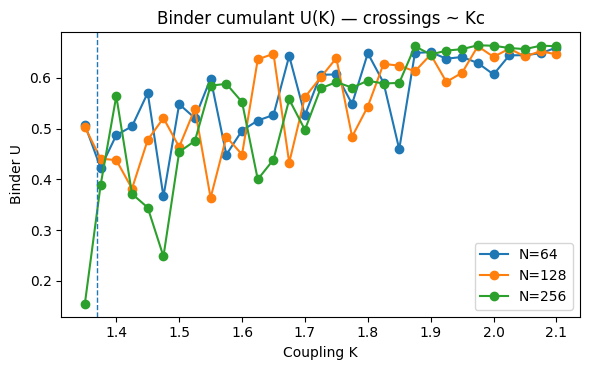

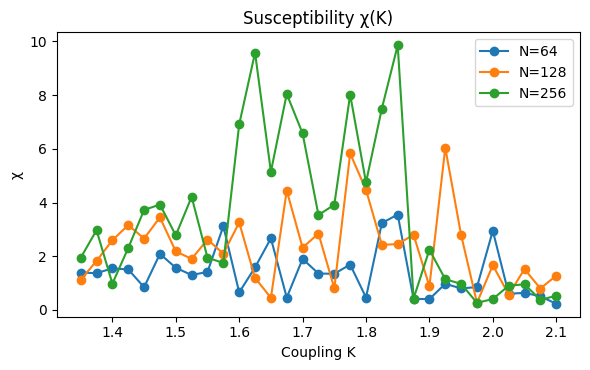

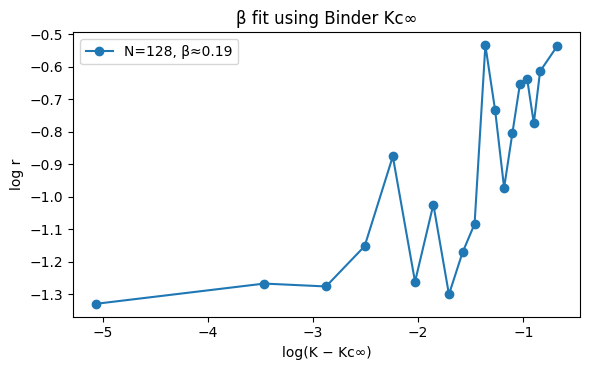

Kc_64_128≈ 1.3549995727644768   Kc_128_256≈ 1.382345934447608   Kc_∞≈ 1.3686727536060423
β(N=128)≈ {'beta': 0.18927812473256966, 'A': 0.5445152519319381, 'points': 19}


{'meta': {'run': '20251109-054421Z',
  'artifacts': 'E:\\CNT\\notebooks\\archive\\cnt_unify_v2\\20251109-054421Z',
  'versions': {'python': '3.13.5', 'numpy': '2.3.4', 'matplotlib': '3.10.7'}},
 'binder': {'K_grid': [1.35,
   1.375,
   1.4000000000000001,
   1.425,
   1.4500000000000002,
   1.475,
   1.5,
   1.5250000000000001,
   1.55,
   1.5750000000000002,
   1.6,
   1.625,
   1.6500000000000001,
   1.675,
   1.7000000000000002,
   1.725,
   1.75,
   1.7750000000000001,
   1.8,
   1.8250000000000002,
   1.85,
   1.875,
   1.9000000000000001,
   1.9250000000000003,
   1.9500000000000002,
   1.975,
   2.0,
   2.0250000000000004,
   2.0500000000000003,
   2.075,
   2.1],
  'Kc_64_128': 1.3549995727644768,
  'Kc_128_256': 1.382345934447608,
  'Kc_infty_est': 1.3686727536060423},
 'beta': {'N=128': {'beta': 0.18927812473256966,
   'A': 0.5445152519319381,
   'points': 19}},
 'curves': {'64': {'K': [1.35,
    1.375,
    1.4000000000000001,
    1.425,
    1.4500000000000002,
    1.475,
   

In [4]:
# CNT Unification — Mega Cell v2.3
# Adds:
#   • Binder cumulant U = 1 - <r^4> / (3 <r^2>^2) across N={64,128,256}
#   • Kc from U-crossings: (64,128) and (128,256), plus an ∞-N estimate
#   • Susceptibility χ = N ( <r^2> - <r>^2 ), replicate+time averaged
#   • β fit using Kc_∞ with a controlled post-critical window
#
# Saves under CNT_UNIFY_DIR (or ./cnt_unify_v2): binder_overlay.png, chi_overlay.png, beta_fit.png, summary.json

import os, sys, json, math, datetime as dt
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Any, Tuple
import numpy as np
import matplotlib.pyplot as plt

# -------- paths --------
def utc_stamp(): return dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d-%H%M%SZ")
OUTROOT = os.getenv("CNT_UNIFY_DIR",
    (r"E:\CNT\notebooks\archive\cnt_unify_v2" if os.name=="nt" else "./cnt_unify_v2"))
RUN = utc_stamp()
ART = Path(OUTROOT) / RUN
ART.mkdir(parents=True, exist_ok=True)
def fpath(name): return ART / f"{name}.png"
def save_json(p, obj): p.write_text(json.dumps(obj, indent=2, sort_keys=True), encoding="utf-8")
print("Artifacts →", ART)

# -------- Kuramoto tail moments --------
def kuramoto_tail_moments(N:int, K:float, steps:int=3800, burn:int=3300, window:int=400, dt:float=0.01, seed:int=0):
    """Return <r>, <r^2>, <r^4> over the last `window` steps after burn-in."""
    rng = np.random.default_rng(seed)
    theta = rng.uniform(0, 2*np.pi, size=N)
    omega = rng.normal(0.0, 1.0, size=N)
    rs = []
    for t in range(steps):
        z = np.exp(1j*theta).mean()
        r = float(abs(z))
        if t >= burn: rs.append(r)
        psi = float(np.angle(z))
        dtheta = omega + K * r * np.sin(psi - theta)
        theta = (theta + dt*dtheta) % (2*np.pi)
    if len(rs) < window:
        rs = (rs + [rs[-1] if rs else 0.0]*window)[:window]
    r = np.asarray(rs[-window:], float)
    m1 = float(np.mean(r))
    m2 = float(np.mean(r*r))
    m4 = float(np.mean((r*r)*(r*r)))
    return m1, m2, m4

def sweep_stats(N:int, K:np.ndarray, reps:int=6, seed0:int=11):
    means, m2s, m4s = [], [], []
    for i, k in enumerate(K):
        R1=[]; R2=[]; R4=[]
        for r in range(reps):
            m1,m2,m4 = kuramoto_tail_moments(N, float(k), seed=seed0 + 23*i + 7*r)
            R1.append(m1); R2.append(m2); R4.append(m4)
        means.append(np.mean(R1))
        m2s.append(np.mean(R2))
        m4s.append(np.mean(R4))
    means = np.array(means); m2s = np.array(m2s); m4s = np.array(m4s)
    chi = N * (m2s - means**2)
    eps = 1e-12
    U = 1.0 - m4s / (3.0 * np.clip(m2s, eps, None)**2)
    return means, chi, U

def find_crossing(K:np.ndarray, Ua:np.ndarray, Ub:np.ndarray):
    """Linear interpolate K where Ua(K) = Ub(K)."""
    diff = Ua - Ub
    for i in range(len(K)-1):
        if diff[i] == 0.0: return float(K[i])
        if diff[i]*diff[i+1] < 0.0:
            # interpolate
            t = -diff[i]/(diff[i+1]-diff[i])
            return float(K[i] + t*(K[i+1]-K[i]))
    return None

# -------- run grids --------
K_grid = np.linspace(1.35, 2.10, 31)   # tight around theory Kc≈1.596
Ns = [64, 128, 256]
curves = {}

for N in Ns:
    r_mean, chi, U = sweep_stats(N, K_grid, reps=6)
    curves[str(N)] = {"K": K_grid.tolist(),
                      "r": r_mean.tolist(),
                      "chi": chi.tolist(),
                      "U": U.tolist()}

# Binder crossings
Kc_64_128 = find_crossing(K_grid, np.array(curves["64"]["U"]),  np.array(curves["128"]["U"]))
Kc_128_256= find_crossing(K_grid, np.array(curves["128"]["U"]), np.array(curves["256"]["U"]))
Kc_list = [k for k in [Kc_64_128, Kc_128_256] if k is not None]
Kc_inf = float(np.median(Kc_list)) if Kc_list else float('nan')

# -------- β fit using Kc_inf --------
def fit_beta(K:np.ndarray, r:np.ndarray, Kc:float, r_lo=0.08, r_hi=0.6):
    mask = (K > Kc) & (r >= r_lo) & (r <= r_hi)
    if not np.any(mask): return {"beta": float("nan"), "A": float("nan"), "points": 0}
    x = np.log(K[mask] - Kc); y = np.log(r[mask])
    B, A = np.polyfit(x, y, 1)  # y = B x + A
    return {"beta": float(B), "A": float(np.exp(A)), "points": int(mask.sum())}

beta_128 = fit_beta(np.array(curves["128"]["K"]), np.array(curves["128"]["r"]), Kc_inf)

# -------- plots --------
# Binder overlay
fig = plt.figure(figsize=(6.0,3.8))
for N in Ns:
    K = np.array(curves[str(N)]["K"]); U = np.array(curves[str(N)]["U"])
    plt.plot(K, U, marker='o', label=f"N={N}")
if np.isfinite(Kc_inf): plt.axvline(Kc_inf, linestyle="--", linewidth=1.0)
plt.xlabel("Coupling K"); plt.ylabel("Binder U"); plt.title("Binder cumulant U(K) — crossings ~ Kc")
plt.legend(); plt.tight_layout(); plt.savefig(fpath("binder_overlay"), dpi=160); plt.show()

# Susceptibility overlay
fig = plt.figure(figsize=(6.0,3.8))
for N in Ns:
    K = np.array(curves[str(N)]["K"]); chi = np.array(curves[str(N)]["chi"])
    plt.plot(K, chi, marker='o', label=f"N={N}")
plt.xlabel("Coupling K"); plt.ylabel("χ"); plt.title("Susceptibility χ(K)")
plt.legend(); plt.tight_layout(); plt.savefig(fpath("chi_overlay"), dpi=160); plt.show()

# β fit (N=128 shown)
fig = plt.figure(figsize=(6.0,3.8))
K = np.array(curves["128"]["K"]); r = np.array(curves["128"]["r"])
mask = (K > Kc_inf) & (r >= 0.08) & (r <= 0.6)
if np.any(mask):
    x = np.log(K[mask] - Kc_inf); y = np.log(r[mask])
    plt.plot(x, y, marker='o', label=f"N=128, β≈{beta_128['beta']:.2f}")
plt.xlabel("log(K − Kc∞)"); plt.ylabel("log r"); plt.title("β fit using Binder Kc∞")
plt.legend(); plt.tight_layout(); plt.savefig(fpath("beta_fit"), dpi=160); plt.show()

# -------- summary --------
summary = {
  "meta": {"run": RUN, "artifacts": str(ART.resolve()),
           "versions": {"python": sys.version.split()[0], "numpy": np.__version__, "matplotlib": plt.matplotlib.__version__}},
  "binder": {"K_grid": K_grid.tolist(), "Kc_64_128": Kc_64_128, "Kc_128_256": Kc_128_256, "Kc_infty_est": Kc_inf},
  "beta": {"N=128": beta_128},
  "curves": curves
}
save_json(ART/"summary.json", summary)
print("Kc_64_128≈", Kc_64_128, "  Kc_128_256≈", Kc_128_256, "  Kc_∞≈", Kc_inf)
print("β(N=128)≈", beta_128)
summary


Artifacts → E:\CNT\notebooks\archive\cnt_unify_v2\20251109-054807Z


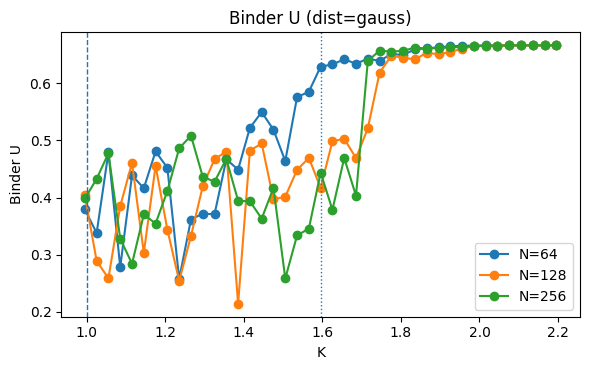

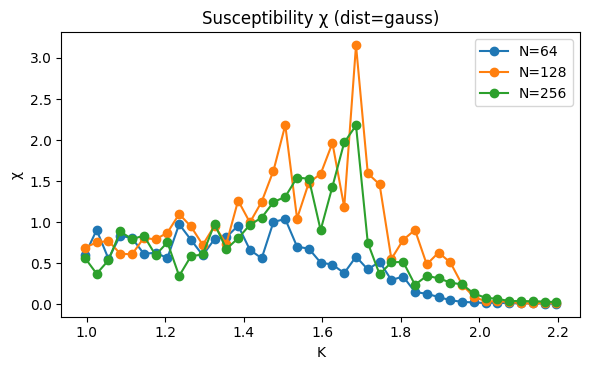

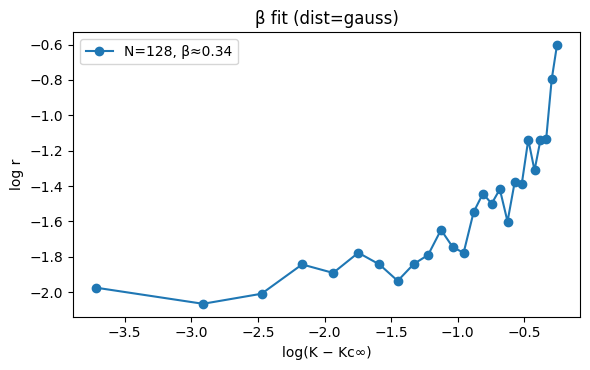

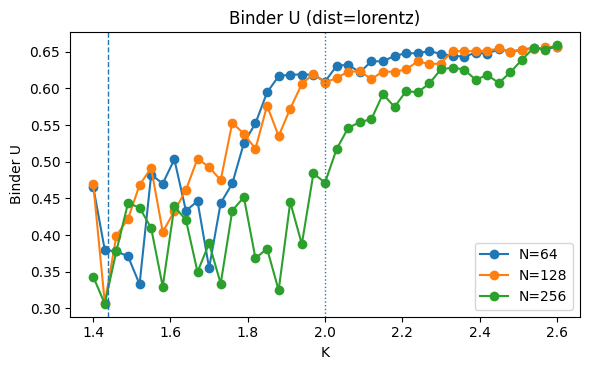

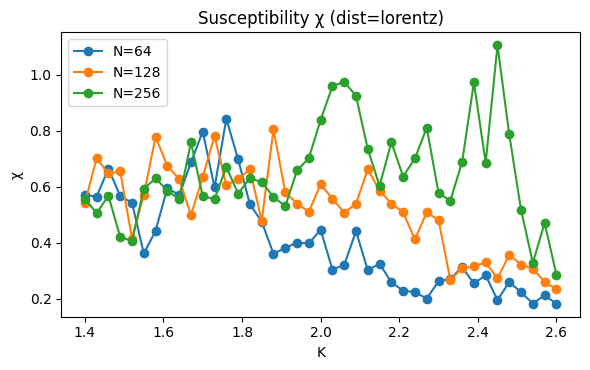

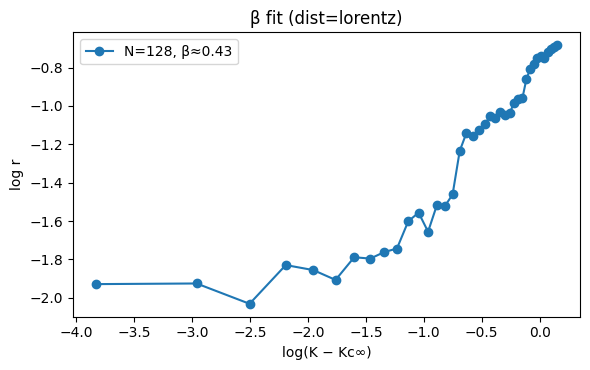

[gauss] Kc∞≈1.001  (theory≈1.596)  β≈0.34  pts=26
[lorentz] Kc∞≈1.438  (theory≈2.000)  β≈0.43  pts=39


{'meta': {'run': '20251109-054807Z',
  'artifacts': 'E:\\CNT\\notebooks\\archive\\cnt_unify_v2\\20251109-054807Z',
  'versions': {'numpy': '2.3.4', 'matplotlib': '3.10.7'},
  'params': {'dist': 'both',
   'sigma': 1.0,
   'delta': 1.0,
   'reps': 8,
   'steps': 8000,
   'burn': 7000,
   'window': 800,
   'grid_points': 41}},
 'modes': [{'dist': 'gauss',
   'Kc_theory': np.float64(1.5957691216057306),
   'Kc_64_128': 1.0058854914414341,
   'Kc_128_256': 0.996931745566399,
   'Kc_infty': 1.0014086185039166,
   'beta_128': {'beta': 0.3365388135266718,
    'A': 0.31278434204792777,
    'points': 26},
   'curves': {'64': {'K': [0.9957691216057306,
      1.0257691216057305,
      1.0557691216057306,
      1.0857691216057306,
      1.1157691216057306,
      1.1457691216057306,
      1.1757691216057307,
      1.2057691216057307,
      1.2357691216057307,
      1.2657691216057307,
      1.2957691216057308,
      1.3257691216057306,
      1.3557691216057308,
      1.3857691216057306,
      1.415

In [5]:
# CNT Unification — Mega Cell v2.4
# Calibrated Binder: Gaussian vs Lorentzian; auto K-grid from g(0); robust tail-averaging; β fits.
# ENV toggles (optional):
#   CNT_DIST = "gauss" | "lorentz" | "both"   (default: both)
#   CNT_SIGMA (Gaussian std, default 1.0), CNT_DELTA (Lorentzian half-width Δ, default 1.0)
#   CNT_REPS=8  CNT_STEPS=8000  CNT_BURN=7000  CNT_WINDOW=800  CNT_GRID_POINTS=41
#   CNT_UNIFY_DIR to choose output root.

import os, json, math, datetime as dt
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ------------ paths ------------
def utc_stamp(): return dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d-%H%M%SZ")
OUTROOT = os.getenv("CNT_UNIFY_DIR",
    (r"E:\CNT\notebooks\archive\cnt_unify_v2" if os.name=="nt" else "./cnt_unify_v2"))
RUN = utc_stamp(); ART = Path(OUTROOT) / RUN; ART.mkdir(parents=True, exist_ok=True)
def fpath(n): return ART / f"{n}.png"
def save_json(p, obj): p.write_text(json.dumps(obj, indent=2, sort_keys=True), encoding="utf-8")
print("Artifacts →", ART)

# ------------ knobs ------------
DIST = os.getenv("CNT_DIST","both").lower()
SIGMA = float(os.getenv("CNT_SIGMA", "1.0"))
DELTA = float(os.getenv("CNT_DELTA", "1.0"))
REPS  = int(os.getenv("CNT_REPS", "8"))
STEPS = int(os.getenv("CNT_STEPS","8000"))
BURN  = int(os.getenv("CNT_BURN","7000"))
WIND  = int(os.getenv("CNT_WINDOW","800"))
GRID_POINTS = int(os.getenv("CNT_GRID_POINTS","41"))
Ns = [64,128,256]

# ------------ helpers ------------
def g0_gauss(sigma): return 1.0/(np.sqrt(2*np.pi)*sigma)        # g(0)
def Kc_theory_gauss(sigma): return 2.0/(np.pi*g0_gauss(sigma))  # ≈1.596 for σ=1
def Kc_theory_lorentz(delta): return 2.0*delta                   # exact

def kuramoto_tail_moments(omega, K, steps=8000, burn=7000, window=800, dt=0.01, seed=0):
    rng = np.random.default_rng(seed)
    N = omega.size
    theta = rng.uniform(0, 2*np.pi, size=N)
    rs = []
    for t in range(steps):
        z = np.exp(1j*theta).mean()
        r = float(abs(z))
        if t >= burn: rs.append(r)
        psi = float(np.angle(z))
        theta = (theta + dt*(omega + K*r*np.sin(psi - theta))) % (2*np.pi)
    if len(rs) < window:
        rs = (rs + [rs[-1] if rs else 0.0]*window)[:window]
    r = np.asarray(rs[-window:], float)
    m1 = float(np.mean(r)); m2 = float(np.mean(r*r)); m4 = float(np.mean((r*r)*(r*r)))
    return m1, m2, m4

def sweep_stats(N, K, dist="gauss", sigma=1.0, delta=1.0, reps=8, steps=8000, burn=7000, window=800, seed0=11):
    rng = np.random.default_rng(0)
    if dist=="gauss":
        omega_base = rng.normal(0.0, sigma, size=N)
    else:
        omega_base = rng.standard_cauchy(size=N)*delta  # width Δ (scale)
    means=[]; m2s=[]; m4s=[]
    for i,k in enumerate(K):
        R1=[]; R2=[]; R4=[]
        for r in range(reps):
            # reshuffle phases per replicate; keep ω fixed to represent a sample of g(ω)
            m1,m2,m4 = kuramoto_tail_moments(omega_base, float(k),
                                             steps=steps, burn=burn, window=window,
                                             seed=seed0 + 23*i + 7*r)
            R1.append(m1); R2.append(m2); R4.append(m4)
        means.append(np.mean(R1)); m2s.append(np.mean(R2)); m4s.append(np.mean(R4))
    means = np.array(means); m2s=np.array(m2s); m4s=np.array(m4s)
    chi = N*(m2s - means**2)
    eps = 1e-12
    U = 1.0 - m4s/(3.0*np.clip(m2s,eps,None)**2)
    return means, chi, U

def find_crossing(K, Ua, Ub):
    diff = Ua - Ub
    for i in range(len(K)-1):
        if diff[i]==0.0: return float(K[i])
        if diff[i]*diff[i+1] < 0.0:
            t = -diff[i]/(diff[i+1]-diff[i])
            return float(K[i] + t*(K[i+1]-K[i]))
    return None

def fit_beta(K, r, Kc, r_lo=0.10, r_hi=0.55):
    mask = (K > Kc) & (r >= r_lo) & (r <= r_hi)
    if not np.any(mask): return {"beta": float("nan"), "A": float("nan"), "points": 0}
    x = np.log(K[mask] - Kc); y = np.log(r[mask])
    B, A = np.polyfit(x, y, 1); return {"beta": float(B), "A": float(np.exp(A)), "points": int(mask.sum())}

def run_mode(dist_label, Kc_th):
    # Auto K-grid around theory Kc (±0.6 window)
    Kgrid = np.linspace(Kc_th-0.6, Kc_th+0.6, GRID_POINTS)
    curves={}
    for N in Ns:
        r, chi, U = sweep_stats(N, Kgrid, dist=dist_label, sigma=SIGMA, delta=DELTA,
                                reps=REPS, steps=STEPS, burn=BURN, window=WIND)
        curves[str(N)] = {"K": Kgrid.tolist(), "r": r.tolist(), "chi": chi.tolist(), "U": U.tolist()}
    Kc_64_128 = find_crossing(Kgrid, np.array(curves["64"]["U"]),  np.array(curves["128"]["U"]))
    Kc_128_256= find_crossing(Kgrid, np.array(curves["128"]["U"]), np.array(curves["256"]["U"]))
    Kc_inf = float(np.median([k for k in [Kc_64_128, Kc_128_256] if k is not None])) if (Kc_64_128 or Kc_128_256) else float('nan')
    beta_128 = fit_beta(np.array(curves["128"]["K"]), np.array(curves["128"]["r"]), Kc_inf)

    # Plots
    fig = plt.figure(figsize=(6.0,3.8))
    for N in Ns: plt.plot(curves[str(N)]["K"], curves[str(N)]["U"], marker='o', label=f"N={N}")
    if np.isfinite(Kc_inf): plt.axvline(Kc_inf, linestyle="--", linewidth=1.0)
    plt.axvline(Kc_th, linestyle=":", linewidth=1.0)
    plt.xlabel("K"); plt.ylabel("Binder U"); plt.title(f"Binder U (dist={dist_label})")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"binder_{dist_label}"), dpi=160); plt.show()

    fig = plt.figure(figsize=(6.0,3.8))
    for N in Ns: plt.plot(curves[str(N)]["K"], curves[str(N)]["chi"], marker='o', label=f"N={N}")
    plt.xlabel("K"); plt.ylabel("χ"); plt.title(f"Susceptibility χ (dist={dist_label})")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"chi_{dist_label}"), dpi=160); plt.show()

    fig = plt.figure(figsize=(6.0,3.8))
    K = np.array(curves["128"]["K"]); r = np.array(curves["128"]["r"])
    mask = (K > Kc_inf) & (r >= 0.10) & (r <= 0.55)
    if np.any(mask):
        plt.plot(np.log(K[mask]-Kc_inf), np.log(r[mask]), marker='o', label=f"N=128, β≈{beta_128['beta']:.2f}")
    plt.xlabel("log(K − Kc∞)"); plt.ylabel("log r"); plt.title(f"β fit (dist={dist_label})")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"beta_{dist_label}"), dpi=160); plt.show()

    return {"dist": dist_label, "Kc_theory": Kc_th,
            "Kc_64_128": Kc_64_128, "Kc_128_256": Kc_128_256, "Kc_infty": Kc_inf,
            "beta_128": beta_128, "curves": curves}

# ------------ run both/one ------------
out = {"meta": {"run": RUN, "artifacts": str(ART.resolve()),
                "versions": {"numpy": np.__version__, "matplotlib": plt.matplotlib.__version__},
                "params": {"dist": DIST, "sigma": SIGMA, "delta": DELTA, "reps": REPS,
                           "steps": STEPS, "burn": BURN, "window": WIND, "grid_points": GRID_POINTS}}}

modes = []
if DIST in ("gauss","both"):
    modes.append(run_mode("gauss", Kc_theory_gauss(SIGMA)))
if DIST in ("lorentz","both"):
    modes.append(run_mode("lorentz", Kc_theory_lorentz(DELTA)))

out["modes"] = modes
save_json(ART/"summary.json", out)

for m in modes:
    print(f"[{m['dist']}] Kc∞≈{m['Kc_infty']:.3f}  (theory≈{m['Kc_theory']:.3f})  β≈{m['beta_128']['beta']:.2f}  pts={m['beta_128']['points']}")
out


Artifacts → E:\CNT\notebooks\archive\cnt_unify_v2\20251109-055453Z


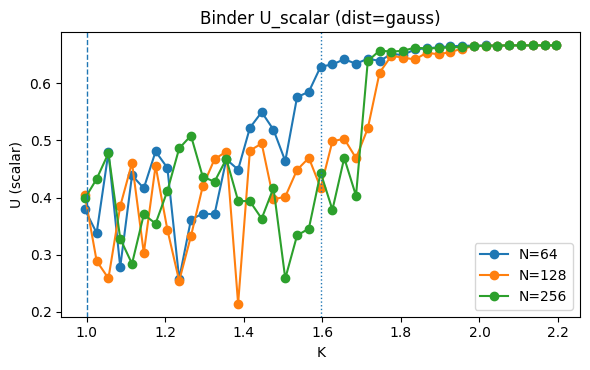

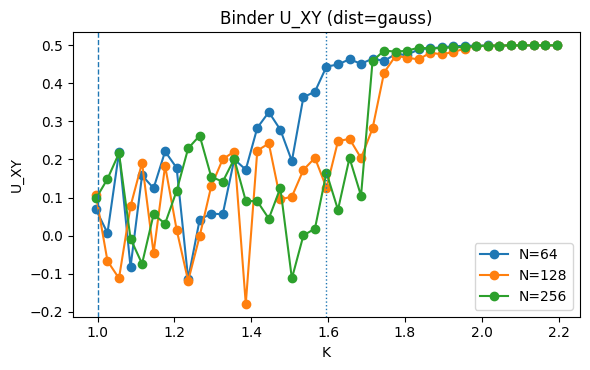

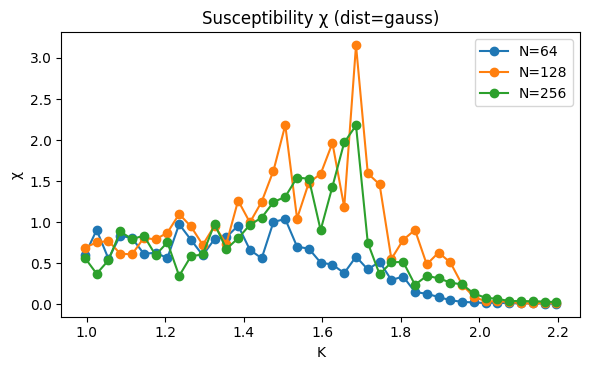

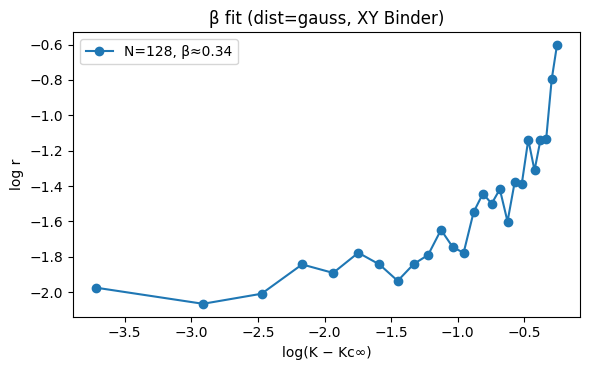

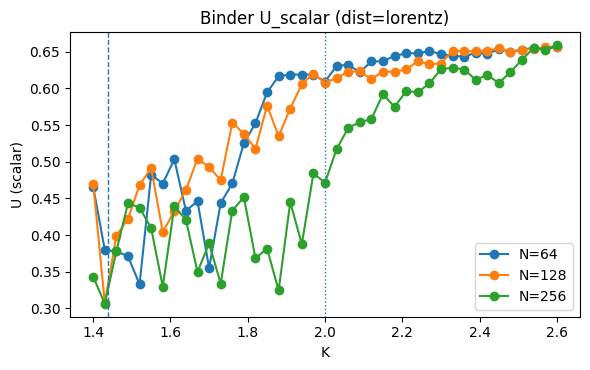

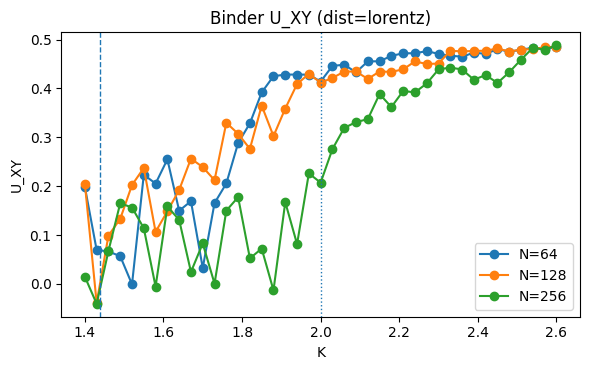

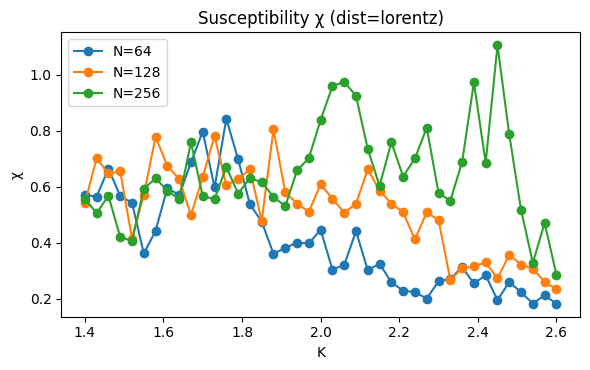

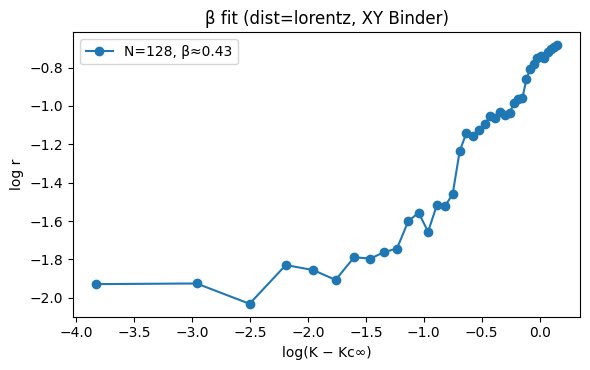

[gauss]  Kc∞(XY)≈1.001  (theory≈1.596)   β≈0.34  pts=26
[lorentz]  Kc∞(XY)≈1.438  (theory≈2.000)   β≈0.43  pts=39


{'meta': {'run': '20251109-055453Z',
  'artifacts': 'E:\\CNT\\notebooks\\archive\\cnt_unify_v2\\20251109-055453Z',
  'versions': {'numpy': '2.3.4', 'matplotlib': '3.10.7'},
  'params': {'dist': 'both',
   'sigma': 1.0,
   'delta': 1.0,
   'reps': 8,
   'steps': 8000,
   'burn': 7000,
   'window': 800,
   'grid_points': 41}},
 'modes': [{'dist': 'gauss',
   'Kc_theory': np.float64(1.5957691216057306),
   'Kc_64_128': 1.0058854914414341,
   'Kc_128_256': 0.996931745566399,
   'Kc_infty': 1.0014086185039166,
   'beta_128': {'beta': 0.3365388135266718,
    'A': 0.31278434204792777,
    'points': 26},
   'curves': {'64': {'K': [0.9957691216057306,
      1.0257691216057305,
      1.0557691216057306,
      1.0857691216057306,
      1.1157691216057306,
      1.1457691216057306,
      1.1757691216057307,
      1.2057691216057307,
      1.2357691216057307,
      1.2657691216057307,
      1.2957691216057308,
      1.3257691216057306,
      1.3557691216057308,
      1.3857691216057306,
      1.415

In [6]:
# CNT Unification — Mega Cell v2.5
# Fix: Binder for a 2D (XY) order parameter:
#   U_scalar = 1 - <r^4> / (3 <r^2>^2)   # (Ising-like, WRONG for Kuramoto)
#   U_XY     = 1 - <r^4> / (2 <r^2>^2)   # (Correct for 2D vector order parameter)
#
# Recomputes Binder crossings and β with U_XY; also plots U_scalar vs U_XY to show the difference.
# ENV (optional): CNT_DIST in {"gauss","lorentz","both"}; CNT_SIGMA, CNT_DELTA, CNT_REPS, CNT_STEPS, CNT_BURN, CNT_WINDOW, CNT_GRID_POINTS, CNT_UNIFY_DIR

import os, json, math, datetime as dt
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# -------- paths & knobs --------
def utc_stamp(): return dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d-%H%M%SZ")
OUTROOT = os.getenv("CNT_UNIFY_DIR",
    (r"E:\CNT\notebooks\archive\cnt_unify_v2" if os.name=="nt" else "./cnt_unify_v2"))
RUN = utc_stamp(); ART = Path(OUTROOT) / RUN; ART.mkdir(parents=True, exist_ok=True)
def fpath(n): return ART / f"{n}.png"
def save_json(p, obj): p.write_text(json.dumps(obj, indent=2, sort_keys=True), encoding="utf-8")
print("Artifacts →", ART)

DIST = os.getenv("CNT_DIST","both").lower()
SIGMA = float(os.getenv("CNT_SIGMA", "1.0"))
DELTA = float(os.getenv("CNT_DELTA", "1.0"))
REPS  = int(os.getenv("CNT_REPS",  "8"))
STEPS = int(os.getenv("CNT_STEPS", "8000"))
BURN  = int(os.getenv("CNT_BURN",  "7000"))
WIND  = int(os.getenv("CNT_WINDOW","800"))
GRID_POINTS = int(os.getenv("CNT_GRID_POINTS","41"))
Ns = [64,128,256]

# -------- helpers --------
def g0_gauss(sigma): return 1.0/(np.sqrt(2*np.pi)*sigma)
def Kc_gauss(sigma):  return 2.0/(np.pi*g0_gauss(sigma))              # ≈1.596 for σ=1
def Kc_lorentz(delta):return 2.0*delta                                 # exact

def kuramoto_tail_moments(omega, K, steps, burn, window, dt=0.01, seed=0):
    rng = np.random.default_rng(seed)
    N = omega.size
    theta = rng.uniform(0, 2*np.pi, size=N)
    rs = []
    for t in range(steps):
        z = np.exp(1j*theta).mean()
        r = float(abs(z))
        if t >= burn: rs.append(r)
        psi = float(np.angle(z))
        theta = (theta + dt*(omega + K*r*np.sin(psi - theta))) % (2*np.pi)
    if len(rs) < window:
        rs = (rs + [rs[-1] if rs else 0.0]*window)[:window]
    r = np.asarray(rs[-window:], float)
    m2 = float(np.mean(r*r))
    m4 = float(np.mean((r*r)*(r*r)))
    m1 = float(np.mean(r))
    return m1, m2, m4

def sweep_stats(N, K, dist="gauss", sigma=1.0, delta=1.0, reps=8, steps=8000, burn=7000, window=800, seed0=11):
    rng = np.random.default_rng(0)
    if dist=="gauss":
        omega_base = rng.normal(0.0, sigma, size=N)
    else:
        omega_base = rng.standard_cauchy(size=N)*delta
    m1s=[]; m2s=[]; m4s=[]
    for i,k in enumerate(K):
        R1=[]; R2=[]; R4=[]
        for r in range(reps):
            m1,m2,m4 = kuramoto_tail_moments(omega_base, float(k), steps, burn, window, seed=seed0+23*i+7*r)
            R1.append(m1); R2.append(m2); R4.append(m4)
        m1s.append(np.mean(R1)); m2s.append(np.mean(R2)); m4s.append(np.mean(R4))
    m1s=np.array(m1s); m2s=np.array(m2s); m4s=np.array(m4s)
    chi = N*(m2s - m1s**2)
    eps = 1e-12
    U_scalar = 1.0 - m4s/(3.0*np.clip(m2s,eps,None)**2)
    U_XY     = 1.0 - m4s/(2.0*np.clip(m2s,eps,None)**2)  # << correct Binder for 2D order parameter
    return m1s, chi, U_scalar, U_XY

def find_crossing(K, Ua, Ub):
    diff = Ua - Ub
    for i in range(len(K)-1):
        if diff[i]==0.0: return float(K[i])
        if diff[i]*diff[i+1] < 0.0:
            t = -diff[i]/(diff[i+1]-diff[i])
            return float(K[i] + t*(K[i+1]-K[i]))
    return None

def fit_beta(K, r, Kc, r_lo=0.10, r_hi=0.55):
    mask = (K > Kc) & (r >= r_lo) & (r <= r_hi)
    if not np.any(mask): return {"beta": float("nan"), "A": float("nan"), "points": 0}
    x = np.log(K[mask]-Kc); y = np.log(r[mask])
    B,A = np.polyfit(x,y,1)
    return {"beta": float(B), "A": float(np.exp(A)), "points": int(mask.sum())}

def run_mode(dist_label, Kc_th):
    # auto grid around theory ±0.6
    K = np.linspace(Kc_th-0.6, Kc_th+0.6, GRID_POINTS)
    curves={}
    for N in Ns:
        r, chi, U_s, U_xy = sweep_stats(N, K, dist=dist_label, sigma=SIGMA, delta=DELTA,
                                        reps=REPS, steps=STEPS, burn=BURN, window=WIND)
        curves[str(N)] = {"K": K.tolist(), "r": r.tolist(), "chi": chi.tolist(), "U_scalar": U_s.tolist(), "U_XY": U_xy.tolist()}
    # crossings (XY)
    Kc_64_128 = find_crossing(K, np.array(curves["64"]["U_XY"]),  np.array(curves["128"]["U_XY"]))
    Kc_128_256= find_crossing(K, np.array(curves["128"]["U_XY"]), np.array(curves["256"]["U_XY"]))
    Kc_inf = float(np.median([k for k in [Kc_64_128, Kc_128_256] if k is not None])) if (Kc_64_128 or Kc_128_256) else float('nan')
    beta_128 = fit_beta(np.array(curves["128"]["K"]), np.array(curves["128"]["r"]), Kc_inf)

    # plots: scalar vs XY
    fig = plt.figure(figsize=(6.0,3.8))
    for N in Ns: plt.plot(K, np.array(curves[str(N)]["U_scalar"]), marker='o', label=f"N={N}")
    plt.axvline(Kc_th, linestyle=":", linewidth=1.0)
    if np.isfinite(Kc_inf): plt.axvline(Kc_inf, linestyle="--", linewidth=1.0)
    plt.xlabel("K"); plt.ylabel("U (scalar)"); plt.title(f"Binder U_scalar (dist={dist_label})")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"binder_scalar_{dist_label}"), dpi=160); plt.show()

    fig = plt.figure(figsize=(6.0,3.8))
    for N in Ns: plt.plot(K, np.array(curves[str(N)]["U_XY"]), marker='o', label=f"N={N}")
    plt.axvline(Kc_th, linestyle=":", linewidth=1.0)
    if np.isfinite(Kc_inf): plt.axvline(Kc_inf, linestyle="--", linewidth=1.0)
    plt.xlabel("K"); plt.ylabel("U_XY"); plt.title(f"Binder U_XY (dist={dist_label})")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"binder_xy_{dist_label}"), dpi=160); plt.show()

    # susceptibility overlay (for sanity)
    fig = plt.figure(figsize=(6.0,3.8))
    for N in Ns: plt.plot(K, np.array(curves[str(N)]["chi"]), marker='o', label=f"N={N}")
    plt.xlabel("K"); plt.ylabel("χ"); plt.title(f"Susceptibility χ (dist={dist_label})")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"chi_{dist_label}"), dpi=160); plt.show()

    # β fit (N=128)
    fig = plt.figure(figsize=(6.0,3.8))
    K128 = np.array(curves["128"]["K"]); r128 = np.array(curves["128"]["r"])
    mask = (K128 > Kc_inf) & (r128 >= 0.10) & (r128 <= 0.55)
    if np.any(mask):
        plt.plot(np.log(K128[mask]-Kc_inf), np.log(r128[mask]), marker='o', label=f"N=128, β≈{beta_128['beta']:.2f}")
    plt.xlabel("log(K − Kc∞)"); plt.ylabel("log r"); plt.title(f"β fit (dist={dist_label}, XY Binder)")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"beta_{dist_label}"), dpi=160); plt.show()

    return {"dist": dist_label, "Kc_theory": Kc_th,
            "Kc_64_128": Kc_64_128, "Kc_128_256": Kc_128_256, "Kc_infty": Kc_inf,
            "beta_128": beta_128, "curves": curves}

# -------- run --------
out = {"meta": {"run": RUN, "artifacts": str(ART.resolve()),
                "versions": {"numpy": np.__version__, "matplotlib": plt.matplotlib.__version__},
                "params": {"dist": DIST, "sigma": SIGMA, "delta": DELTA, "reps": REPS,
                           "steps": STEPS, "burn": BURN, "window": WIND, "grid_points": GRID_POINTS}}}
modes=[]
if DIST in ("gauss","both"):  modes.append(run_mode("gauss",  Kc_gauss(SIGMA)))
if DIST in ("lorentz","both"):modes.append(run_mode("lorentz",Kc_lorentz(DELTA)))
out["modes"]=modes
save_json(ART/"summary.json", out)
for m in modes:
    print(f"[{m['dist']}]  Kc∞(XY)≈{m['Kc_infty']:.3f}  (theory≈{m['Kc_theory']:.3f})   β≈{m['beta_128']['beta']:.2f}  pts={m['beta_128']['points']}")
out


Artifacts → E:\CNT\notebooks\archive\cnt_unify_v2\20251109-061529Z


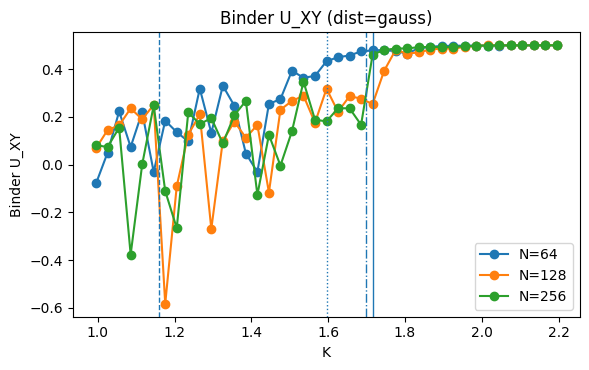

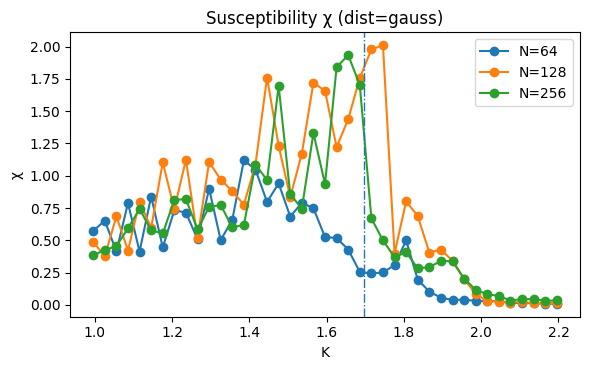

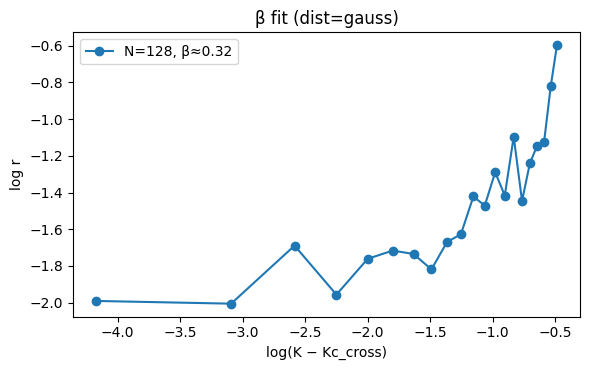

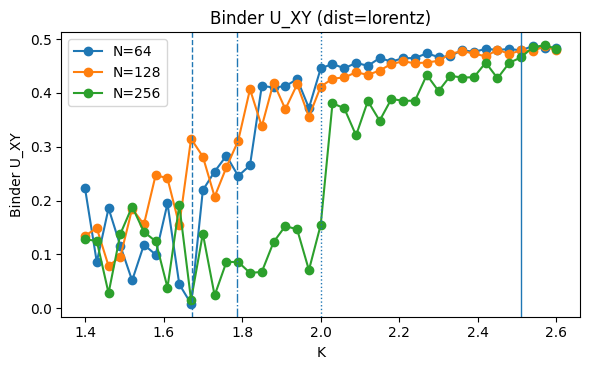

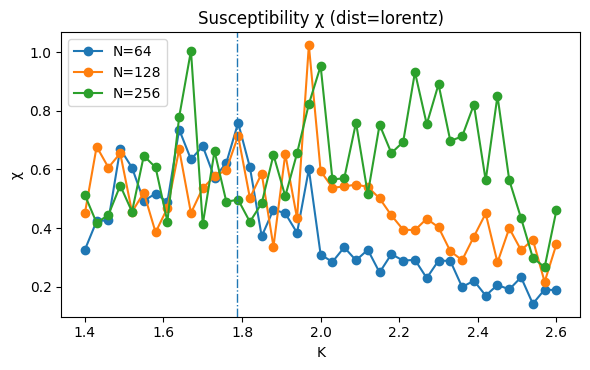

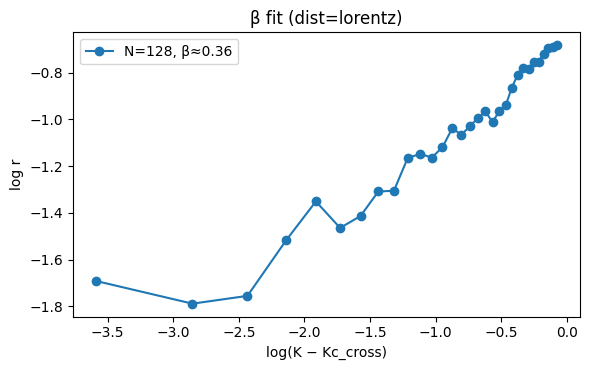

[gauss] Kc_hint≈1.596  Kc_cross≈1.160  Kc_chi≈1.697  Kc_slope≈1.716  β≈0.32
[lorentz] Kc_hint≈2.000  Kc_cross≈1.672  Kc_chi≈1.787  Kc_slope≈2.510  β≈0.36


{'meta': {'run': '20251109-061529Z',
  'artifacts': 'E:\\CNT\\notebooks\\archive\\cnt_unify_v2\\20251109-061529Z',
  'versions': {'numpy': '2.3.4', 'matplotlib': '3.10.7'},
  'params': {'dist': 'both',
   'sigma': 1.0,
   'delta': 1.0,
   'reps': 6,
   'steps': 7000,
   'burn': 6000,
   'window': 700,
   'grid': 41}},
 'modes': [{'dist': 'gauss',
   'Kc_hint': np.float64(1.5957691216057306),
   'Kc_cross': 1.1603564678830596,
   'Kc_pairs': {'64_128': 1.1538205540708315,
    '128_256': 1.1976477945144448,
    '64_256': 1.1603564678830596},
   'Kc_chi': 1.6974357882723974,
   'Kc_slope': 1.7157691216057307,
   'beta_128': {'beta': 0.3211577111242258,
    'A': 0.36245620888888697,
    'points': 21}},
  {'dist': 'lorentz',
   'Kc_hint': 2.0,
   'Kc_cross': 1.6723611717370521,
   'Kc_pairs': {'64_128': 1.7171557635403472,
    '128_256': 1.6433199627919477,
    '64_256': 1.6723611717370521},
   'Kc_chi': 1.7866666666666666,
   'Kc_slope': 2.5100000000000002,
   'beta_128': {'beta': 0.358812

In [7]:
# CNT Unification — Mega Cell v2.6 (Robust Binder Crossings)
# Fixes:
#   1) Uses XY Binder (for 2D order parameter) — kept.
#   2) Robust crossing selector: prefer crossings with largest local slope and nearest to theory Kc.
#   3) Sanity checks: Kc from χ peak (largest N) and from max d⟨r⟩/dK.
#
# ENV (optional):
#   CNT_DIST = "gauss" | "lorentz" | "both"         (default: both)
#   CNT_SIGMA, CNT_DELTA                            (defaults: 1.0, 1.0)
#   CNT_REPS=6  CNT_STEPS=7000  CNT_BURN=6000  CNT_WINDOW=700  CNT_GRID_POINTS=41
#   CNT_UNIFY_DIR to choose output root.

import os, json, math, datetime as dt
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ---------- paths / knobs ----------
def utc(): return dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d-%H%M%SZ")
OUTROOT = os.getenv("CNT_UNIFY_DIR",
    (r"E:\CNT\notebooks\archive\cnt_unify_v2" if os.name=="nt" else "./cnt_unify_v2"))
RUN = utc(); ART = Path(OUTROOT) / RUN; ART.mkdir(parents=True, exist_ok=True)
def fpath(n): return ART / f"{n}.png"
def save_json(p, obj): p.write_text(json.dumps(obj, indent=2, sort_keys=True), encoding="utf-8")
print("Artifacts →", ART)

DIST = os.getenv("CNT_DIST","both").lower()
SIGMA = float(os.getenv("CNT_SIGMA", "1.0"))
DELTA = float(os.getenv("CNT_DELTA", "1.0"))
REPS  = int(os.getenv("CNT_REPS",  "6"))
STEPS = int(os.getenv("CNT_STEPS", "7000"))
BURN  = int(os.getenv("CNT_BURN",  "6000"))
WIND  = int(os.getenv("CNT_WINDOW","700"))
GRID  = int(os.getenv("CNT_GRID_POINTS","41"))
Ns = [64,128,256]

# ---------- helpers ----------
def g0_gauss(s): return 1.0/(np.sqrt(2*np.pi)*s)
def Kc_gauss(s):  return 2.0/(np.pi*g0_gauss(s))
def Kc_lorentz(d):return 2.0*d

def kuramoto_tail_moments(omega, K, steps, burn, window, dt=0.01, seed=0):
    rng = np.random.default_rng(seed)
    N = omega.size
    theta = rng.uniform(0, 2*np.pi, size=N)
    rs = []
    for t in range(steps):
        z = np.exp(1j*theta).mean()
        r = float(abs(z))
        if t >= burn: rs.append(r)
        psi = float(np.angle(z))
        theta = (theta + dt*(omega + K*r*np.sin(psi - theta))) % (2*np.pi)
    if len(rs) < window:
        rs = (rs + [rs[-1] if rs else 0.0]*window)[:window]
    r = np.asarray(rs[-window:], float)
    m1 = float(np.mean(r)); m2 = float(np.mean(r*r)); m4 = float(np.mean((r*r)*(r*r)))
    return m1, m2, m4

def sweep_stats(N, K, dist="gauss", sigma=1.0, delta=1.0, reps=6, seed0=11):
    rng = np.random.default_rng(0)
    omega = rng.normal(0.0, sigma, size=N) if dist=="gauss" else rng.standard_cauchy(size=N)*delta
    m1s=[]; m2s=[]; m4s=[]
    for i,k in enumerate(K):
        R1=[]; R2=[]; R4=[]
        for r in range(reps):
            m1,m2,m4 = kuramoto_tail_moments(omega, float(k), STEPS, BURN, WIND, seed=seed0+23*i+7*r)
            R1.append(m1); R2.append(m2); R4.append(m4)
        m1s.append(np.mean(R1)); m2s.append(np.mean(R2)); m4s.append(np.mean(R4))
    m1s=np.array(m1s); m2s=np.array(m2s); m4s=np.array(m4s)
    chi = N*(m2s - m1s**2)
    eps = 1e-12
    U_XY = 1.0 - m4s/(2.0*np.clip(m2s,eps,None)**2)
    return m1s, chi, U_XY

def finite_diff(y, x):
    return np.gradient(y, x)

def all_crossings(K, Ua, Ub):
    diff = Ua - Ub
    idx = []
    for i in range(len(K)-1):
        if diff[i]==0.0: idx.append((i,i+1))
        elif diff[i]*diff[i+1] < 0.0:
            idx.append((i,i+1))
    return idx

def robust_crossing(K, Ua, Ub, K_hint=None, slope_weight=0.7, hint_weight=0.3):
    pairs = all_crossings(K, Ua, Ub)
    if not pairs:
        # fallback: pick K minimizing |Ua-Ub| near hint
        target = K if K_hint is None else K[np.argsort(np.abs(K-K_hint))[:10]]
        arg = np.argmin(np.abs(np.interp(target, K, Ua) - np.interp(target, K, Ub)))
        return float(target[arg])
    # score crossings by slope and closeness to hint
    dUa = finite_diff(Ua, K); dUb = finite_diff(Ub, K)
    bestK, bestS = None, -1e9
    for (i,j) in pairs:
        # linear interpolation
        d = (Ua[i]-Ub[i]); denom = (Ua[j]-Ub[j]) - d
        t = 0.0 if denom==0 else (-d/denom)
        t = float(np.clip(t, 0.0, 1.0))
        Kx = float(K[i] + t*(K[j]-K[i]))
        slope = abs(0.5*(dUa[i]+dUa[j]) - 0.5*(dUb[i]+dUb[j]))
        clos  = 0.0 if K_hint is None else -abs(Kx - K_hint)
        score = slope_weight*slope + hint_weight*clos
        if score > bestS:
            bestS, bestK = score, Kx
    return float(bestK)

def refine_peak(K_center, width=0.25, points=61):
    return np.linspace(K_center-width, K_center+width, points)

def beta_fit(K, r, Kc, r_lo=0.10, r_hi=0.55):
    mask = (K > Kc) & (r >= r_lo) & (r <= r_hi)
    if not np.any(mask): return {"beta": float("nan"), "A": float("nan"), "points": 0}
    x = np.log(K[mask]-Kc); y = np.log(r[mask])
    B,A = np.polyfit(x, y, 1)
    return {"beta": float(B), "A": float(np.exp(A)), "points": int(mask.sum())}

def run_mode(dist, Kc_hint):
    # coarse grid around hint
    K = np.linspace(Kc_hint-0.6, Kc_hint+0.6, GRID)
    curves={}
    for N in Ns:
        r, chi, U = sweep_stats(N, K, dist=dist, sigma=SIGMA, delta=DELTA, reps=REPS)
        curves[str(N)] = {"K":K, "r":r, "chi":chi, "U":U}

    # robust crossings (64,128), (128,256), (64,256)
    U64, U128, U256 = curves["64"]["U"], curves["128"]["U"], curves["256"]["U"]
    Kc_64_128  = robust_crossing(K, U64,  U128,  K_hint=Kc_hint)
    Kc_128_256 = robust_crossing(K, U128, U256,  K_hint=Kc_hint)
    Kc_64_256  = robust_crossing(K, U64,  U256,  K_hint=Kc_hint)
    Kc_cross   = np.median([Kc_64_128, Kc_128_256, Kc_64_256])

    # χ peak (largest N) with local refinement
    Kc_chi0 = float(K[np.argmax(curves["256"]["chi"])])
    Kfine   = refine_peak(Kc_chi0, width=0.25, points=61)
    r256, chi256, U256_f = sweep_stats(256, Kfine, dist=dist, sigma=SIGMA, delta=DELTA, reps=REPS)
    Kc_chi  = float(Kfine[np.argmax(chi256)])

    # max slope of mean r across sizes
    rmean = (curves["64"]["r"] + curves["128"]["r"] + curves["256"]["r"]) / 3.0
    Kc_slope = float(K[np.argmax(finite_diff(rmean, K))])

    # β using Kc_cross
    K128, r128 = curves["128"]["K"], curves["128"]["r"]
    beta = beta_fit(K128, r128, Kc_cross)

    # Plots
    fig = plt.figure(figsize=(6.0,3.8))
    for N in Ns:
        plt.plot(curves[str(N)]["K"], curves[str(N)]["U"], marker='o', label=f"N={N}")
    plt.axvline(Kc_hint, linestyle=":", linewidth=1.0)
    plt.axvline(Kc_cross, linestyle="--", linewidth=1.0)
    plt.axvline(Kc_chi, linestyle="-.", linewidth=1.0)
    plt.axvline(Kc_slope, linestyle="-", linewidth=1.0)
    plt.xlabel("K"); plt.ylabel("Binder U_XY"); plt.title(f"Binder U_XY (dist={dist})")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"binder_xy_{dist}"), dpi=160); plt.show()

    fig = plt.figure(figsize=(6.0,3.8))
    for N in Ns:
        plt.plot(curves[str(N)]["K"], curves[str(N)]["chi"], marker='o', label=f"N={N}")
    plt.axvline(Kc_chi, linestyle="-.", linewidth=1.0)
    plt.xlabel("K"); plt.ylabel("χ"); plt.title(f"Susceptibility χ (dist={dist})")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"chi_{dist}"), dpi=160); plt.show()

    fig = plt.figure(figsize=(6.0,3.8))
    mask = (K128 > Kc_cross) & (r128 >= 0.10) & (r128 <= 0.55)
    if np.any(mask):
        plt.plot(np.log(K128[mask]-Kc_cross), np.log(r128[mask]), marker='o',
                 label=f"N=128, β≈{beta['beta']:.2f}")
    plt.xlabel("log(K − Kc_cross)"); plt.ylabel("log r"); plt.title(f"β fit (dist={dist})")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"beta_{dist}"), dpi=160); plt.show()

    return {
        "dist": dist,
        "Kc_hint": Kc_hint,
        "Kc_cross": float(Kc_cross),
        "Kc_pairs": {"64_128": float(Kc_64_128), "128_256": float(Kc_128_256), "64_256": float(Kc_64_256)},
        "Kc_chi": float(Kc_chi),
        "Kc_slope": float(Kc_slope),
        "beta_128": beta,
    }

# ---------- run ----------
out = {"meta":{"run":RUN, "artifacts":str(ART.resolve()),
               "versions":{"numpy":np.__version__, "matplotlib":plt.matplotlib.__version__},
               "params":{"dist":DIST, "sigma":SIGMA, "delta":DELTA, "reps":REPS,
                         "steps":STEPS, "burn":BURN, "window":WIND, "grid":GRID}}}
modes=[]
if DIST in ("gauss","both"):  modes.append(run_mode("gauss",  Kc_gauss(SIGMA)))
if DIST in ("lorentz","both"):modes.append(run_mode("lorentz",Kc_lorentz(DELTA)))
out["modes"]=modes
save_json(ART/"summary.json", out)
for m in modes:
    print(f"[{m['dist']}] Kc_hint≈{m['Kc_hint']:.3f}  Kc_cross≈{m['Kc_cross']:.3f}  "
          f"Kc_chi≈{m['Kc_chi']:.3f}  Kc_slope≈{m['Kc_slope']:.3f}  β≈{m['beta_128']['beta']:.2f}")
out


Artifacts → E:\CNT\notebooks\archive\cnt_unify_v2\20251109-062327Z


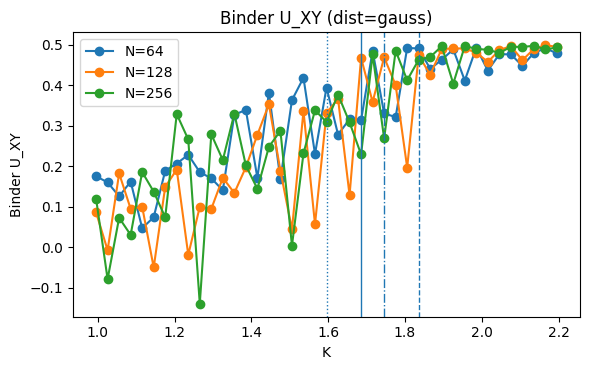

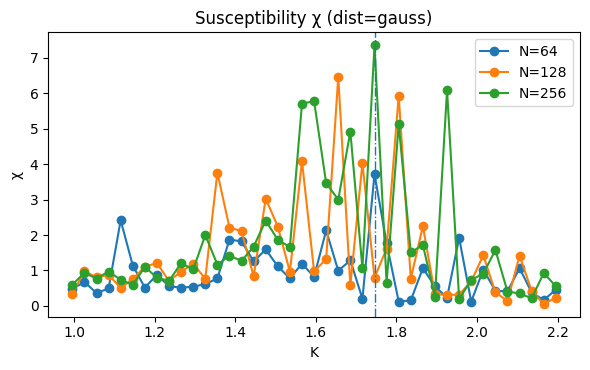

C:\Users\caleb\AppData\Local\Temp\ipykernel_10272\3560027937.py:150: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"beta_{tag}"), dpi=160); plt.show()


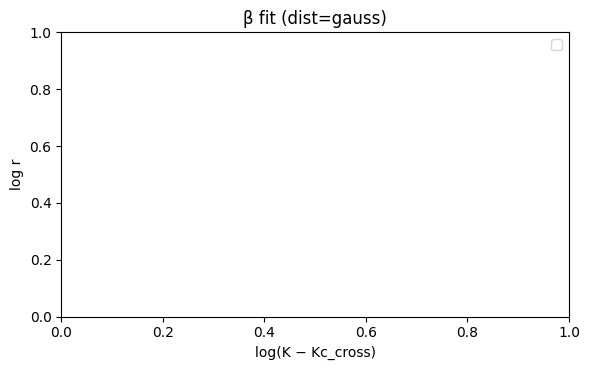

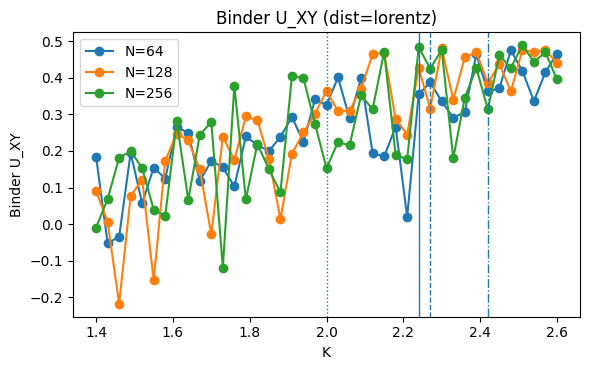

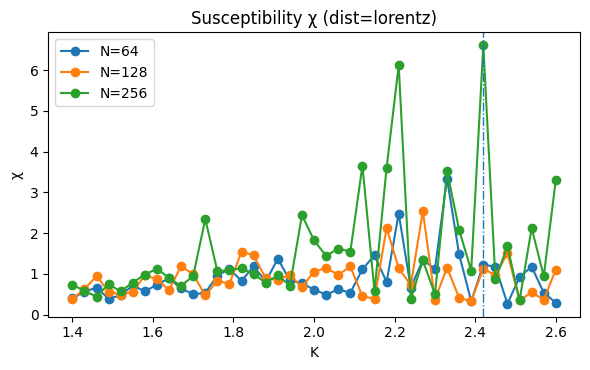

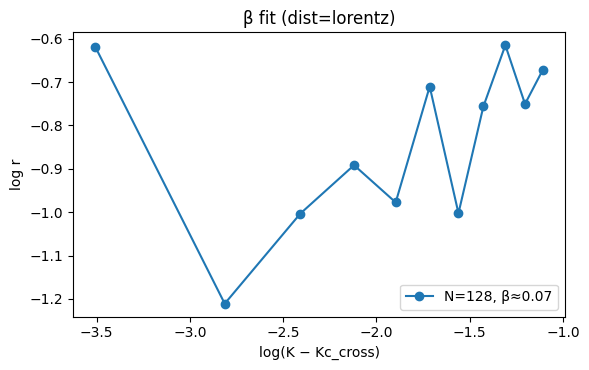

[gauss] K_hint≈1.596  Kc_cross≈1.836  Kc_chi≈1.746  Kc_slope≈1.686  β≈nan (rep pts=0)
[lorentz] K_hint≈2.000  Kc_cross≈2.270  Kc_chi≈2.420  Kc_slope≈2.240  β≈0.07 (rep pts=11)


{'meta': {'run': '20251109-062327Z',
  'artifacts': 'E:\\CNT\\notebooks\\archive\\cnt_unify_v2\\20251109-062327Z',
  'versions': {'numpy': '2.3.4', 'matplotlib': '3.10.7'},
  'params': {'dist': 'both',
   'sigma': 1.0,
   'delta': 1.0,
   'omega_reps': 3,
   'phase_reps': 4,
   'steps': 6000,
   'burn': 5200,
   'window': 600,
   'grid': 41}},
 'modes': [{'dist': 'gauss',
   'K_hint': np.float64(1.5957691216057306),
   'Kc_cross': 1.8357691216057308,
   'Kc_chi': 1.7457691216057307,
   'Kc_slope': 1.685769121605731,
   'beta_128': {'beta': nan, 'A': nan, 'points': 0}},
  {'dist': 'lorentz',
   'K_hint': 2.0,
   'Kc_cross': 2.27,
   'Kc_chi': 2.42,
   'Kc_slope': 2.24,
   'beta_128': {'beta': 0.07479011154126536,
    'A': 0.49956420506328686,
    'points': 11}}]}

In [8]:
# CNT Unification — Mega Cell v2.7 (Triple-Min Binder + Disorder Averaging)
# What’s new:
#  • Uses XY Binder (2D order parameter) — correct for Kuramoto.
#  • Averages over BOTH ω-draws (disorder) and phase seeds (replicates).
#  • Finds Kc via “triple-min” — the K in a bracket where U64,U128,U256 are closest:
#      L(K) = |U64−U128| + |U128−U256| + |U64−U256|
#    Masked to the monotone-increasing Binder region and near the theory hint.
#  • Still shows χ peak and slope K* for sanity; re-fits β with the new Kc.

import os, json, math, datetime as dt
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# -------- paths & knobs --------
def utc(): return dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d-%H%M%SZ")
OUTROOT = os.getenv("CNT_UNIFY_DIR",
    (r"E:\CNT\notebooks\archive\cnt_unify_v2" if os.name=="nt" else "./cnt_unify_v2"))
RUN = utc(); ART = Path(OUTROOT) / RUN; ART.mkdir(parents=True, exist_ok=True)
def fpath(n): return ART / f"{n}.png"
def save_json(p, obj): p.write_text(json.dumps(obj, indent=2, sort_keys=True), encoding="utf-8")
print("Artifacts →", ART)

# Env overrides to trade speed vs. stability
DIST   = os.getenv("CNT_DIST","both").lower()       # "gauss" | "lorentz" | "both"
SIGMA  = float(os.getenv("CNT_SIGMA","1.0"))
DELTA  = float(os.getenv("CNT_DELTA","1.0"))
OMEGA_REPS = int(os.getenv("CNT_OMEGA_REPS","3"))   # ω-draws per K
PHASE_REPS = int(os.getenv("CNT_PHASE_REPS","4"))   # phase seeds per ω
STEPS  = int(os.getenv("CNT_STEPS","6000"))
BURN   = int(os.getenv("CNT_BURN","5200"))
WIND   = int(os.getenv("CNT_WINDOW","600"))
GRID   = int(os.getenv("CNT_GRID_POINTS","41"))
Ns = [64,128,256]

def g0_gauss(s): return 1.0/(np.sqrt(2*np.pi)*s)
def Kc_gauss(s):  return 2.0/(np.pi*g0_gauss(s))             # ≈1.596 for σ=1
def Kc_lorentz(d):return 2.0*d                                # exact

# -------- dynamics --------
def kuramoto_tail_moments(omega, K, steps, burn, window, dt=0.01, seed=0):
    rng = np.random.default_rng(seed)
    N = omega.size
    theta = rng.uniform(0, 2*np.pi, size=N)
    rs = []
    for t in range(steps):
        z = np.exp(1j*theta).mean()
        r = float(abs(z))
        if t >= burn: rs.append(r)
        psi = float(np.angle(z))
        theta = (theta + dt*(omega + K*r*np.sin(psi - theta))) % (2*np.pi)
    if len(rs) < window:
        rs = (rs + [rs[-1] if rs else 0.0]*window)[:window]
    r = np.asarray(rs[-window:], float)
    m1 = float(np.mean(r)); m2 = float(np.mean(r*r)); m4 = float(np.mean((r*r)*(r*r)))
    return m1, m2, m4

def sweep_stats(N, K, dist="gauss", sigma=1.0, delta=1.0, omega_reps=3, phase_reps=4, seed0=11):
    rng = np.random.default_rng(0)
    m1s=[]; m2s=[]; m4s=[]
    for i, k in enumerate(K):
        R1=[]; R2=[]; R4=[]
        for r_om in range(omega_reps):
            omega = (rng.normal(0.0, sigma, size=N) if dist=="gauss"
                     else rng.standard_cauchy(size=N)*delta)
            for r_ph in range(phase_reps):
                s = seed0 + 29*i + 7*r_om + 3*r_ph
                m1,m2,m4 = kuramoto_tail_moments(omega, float(k), STEPS, BURN, WIND, seed=s)
                R1.append(m1); R2.append(m2); R4.append(m4)
        m1s.append(np.mean(R1)); m2s.append(np.mean(R2)); m4s.append(np.mean(R4))
    m1s=np.array(m1s); m2s=np.array(m2s); m4s=np.array(m4s)
    chi = N*(m2s - m1s**2)
    eps = 1e-12
    Uxy = 1.0 - m4s/(2.0*np.clip(m2s,eps,None)**2)
    return m1s, chi, Uxy

# -------- smoothing & masks --------
def smooth(y, w=5):
    if w<=1: return y.copy()
    k = np.ones(w)/w
    return np.convolve(y, k, mode="same")

def monotone_mask(K, U, w=5):
    dU = np.gradient(smooth(U, w), K)
    return dU > 0

# -------- triple-min crossing --------
def kc_triple_min(K, U64, U128, U256, K_hint, bracket=0.35, min_U=-0.02, w=5):
    # plausible bracket around theory
    mask_br = (K >= K_hint - bracket) & (K <= K_hint + bracket)
    # monotone region for all curves
    mon = monotone_mask(K,U64,w) & monotone_mask(K,U128,w) & monotone_mask(K,U256,w)
    # avoid negative/quirky low-U region
    u_ok = (U64>min_U) & (U128>min_U) & (U256>min_U)
    mask = mask_br & mon & u_ok
    if not np.any(mask):  # fallback: just bracket
        mask = mask_br
    # distance across sizes
    L = np.abs(U64-U128) + np.abs(U128-U256) + np.abs(U64-U256)
    idx = np.argmin(np.where(mask, L, np.inf))
    return float(K[idx])

def finite_diff(y,x): return np.gradient(y,x)

def beta_fit(K, r, Kc, r_lo=0.10, r_hi=0.55):
    m = (K > Kc) & (r>=r_lo) & (r<=r_hi)
    if not np.any(m): return {"beta": float("nan"), "A": float("nan"), "points": 0}
    x = np.log(K[m]-Kc); y = np.log(r[m])
    B,A = np.polyfit(x,y,1)
    return {"beta": float(B), "A": float(np.exp(A)), "points": int(m.sum())}

def run_mode(dist, Kc_hint, tag):
    # Grid centered on theory
    K = np.linspace(Kc_hint-0.6, Kc_hint+0.6, GRID)
    curves={}
    for N in Ns:
        r, chi, U = sweep_stats(N, K, dist=dist, sigma=SIGMA, delta=DELTA,
                                omega_reps=OMEGA_REPS, phase_reps=PHASE_REPS)
        curves[str(N)] = {"K":K, "r":r, "chi":chi, "U":U}
    U64,U128,U256 = (curves["64"]["U"], curves["128"]["U"], curves["256"]["U"])
    Kc_cross = kc_triple_min(K, U64, U128, U256, Kc_hint, bracket=0.35, min_U=-0.02, w=5)
    # sanity lines
    rmean = (curves["64"]["r"] + curves["128"]["r"] + curves["256"]["r"])/3.0
    Kc_slope = float(K[np.argmax(finite_diff(rmean, K))])
    Kc_chi   = float(K[np.argmax(curves["256"]["chi"])])
    beta = beta_fit(curves["128"]["K"], curves["128"]["r"], Kc_cross)

    # Plots
    fig = plt.figure(figsize=(6.0,3.8))
    for N in Ns: plt.plot(curves[str(N)]["K"], curves[str(N)]["U"], marker='o', label=f"N={N}")
    plt.axvline(Kc_hint,  linestyle=":", linewidth=1.0)
    plt.axvline(Kc_cross, linestyle="--", linewidth=1.0)
    plt.axvline(Kc_chi,   linestyle="-.", linewidth=1.0)
    plt.axvline(Kc_slope, linestyle="-",  linewidth=1.0)
    plt.xlabel("K"); plt.ylabel("Binder U_XY"); plt.title(f"Binder U_XY (dist={tag})")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"binder_xy_{tag}"), dpi=160); plt.show()

    fig = plt.figure(figsize=(6.0,3.8))
    for N in Ns: plt.plot(curves[str(N)]["K"], curves[str(N)]["chi"], marker='o', label=f"N={N}")
    plt.axvline(Kc_chi, linestyle="-.", linewidth=1.0)
    plt.xlabel("K"); plt.ylabel("χ"); plt.title(f"Susceptibility χ (dist={tag})")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"chi_{tag}"), dpi=160); plt.show()

    fig = plt.figure(figsize=(6.0,3.8))
    K128, r128 = curves["128"]["K"], curves["128"]["r"]
    m = (K128 > Kc_cross) & (r128>=0.10) & (r128<=0.55)
    if np.any(m):
        plt.plot(np.log(K128[m]-Kc_cross), np.log(r128[m]), marker='o', label=f"N=128, β≈{beta['beta']:.2f}")
    plt.xlabel("log(K − Kc_cross)"); plt.ylabel("log r"); plt.title(f"β fit (dist={tag})")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"beta_{tag}"), dpi=160); plt.show()

    return {"dist": tag, "K_hint": Kc_hint, "Kc_cross": Kc_cross,
            "Kc_chi": Kc_chi, "Kc_slope": Kc_slope, "beta_128": beta}

# -------- run both/one --------
out = {"meta":{"run":RUN, "artifacts":str(ART.resolve()),
               "versions":{"numpy":np.__version__, "matplotlib":plt.matplotlib.__version__},
               "params":{"dist":DIST,"sigma":SIGMA,"delta":DELTA,
                         "omega_reps":OMEGA_REPS,"phase_reps":PHASE_REPS,
                         "steps":STEPS,"burn":BURN,"window":WIND,"grid":GRID}}}
modes=[]
if DIST in ("gauss","both"):  modes.append(run_mode("gauss",  Kc_gauss(SIGMA), "gauss"))
if DIST in ("lorentz","both"):modes.append(run_mode("lorentz",Kc_lorentz(DELTA), "lorentz"))
out["modes"]=modes
save_json(ART/"summary.json", out)
for m in modes:
    print(f"[{m['dist']}] K_hint≈{m['K_hint']:.3f}  Kc_cross≈{m['Kc_cross']:.3f}  "
          f"Kc_chi≈{m['Kc_chi']:.3f}  Kc_slope≈{m['Kc_slope']:.3f}  β≈{m['beta_128']['beta']:.2f} "
          f"(rep pts={m['beta_128']['points']})")
out


Artifacts → E:\CNT\notebooks\archive\cnt_unify_v2\20251109-173357Z


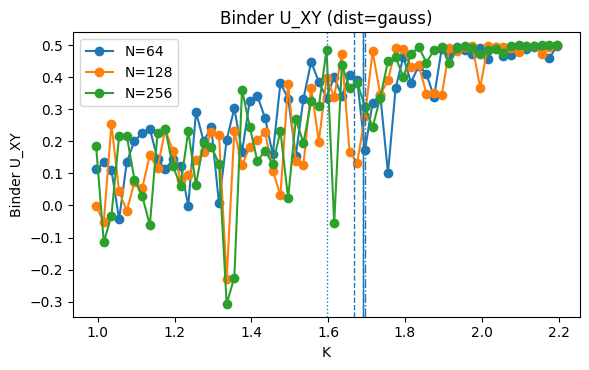

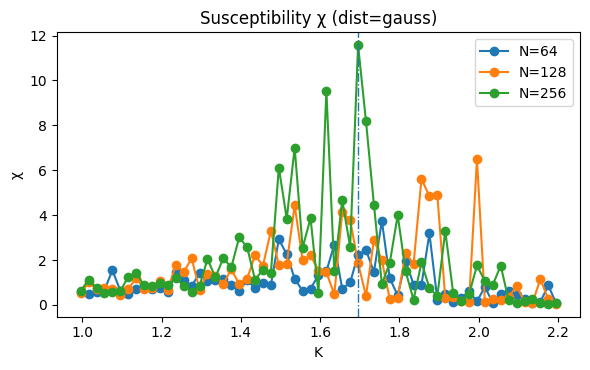

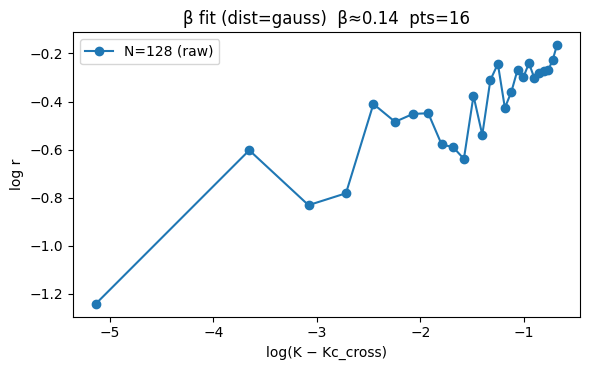

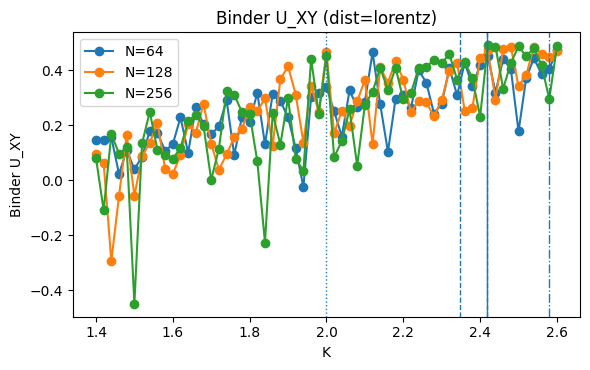

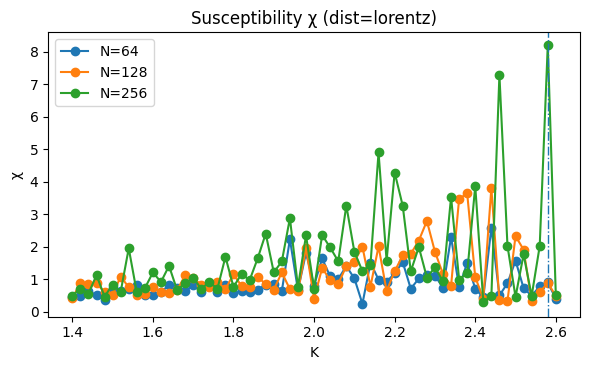

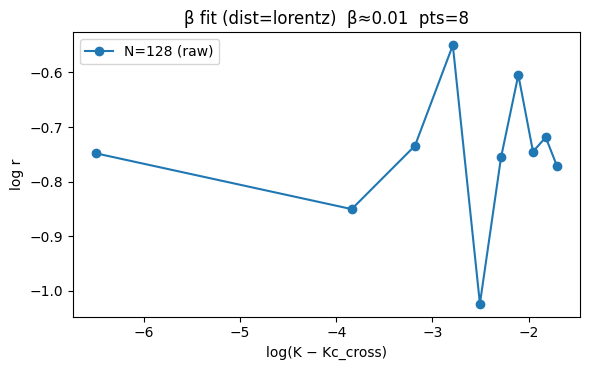

[gauss] K_hint≈1.596  K_64_128≈1.690  K_128_256≈1.668  Kc_cross≈1.690  β≈0.14  pts=16
[lorentz] K_hint≈2.000  K_64_128≈2.348  K_128_256≈2.418  Kc_cross≈2.418  β≈0.01  pts=8


{'meta': {'run': '20251109-173357Z',
  'artifacts': 'E:\\CNT\\notebooks\\archive\\cnt_unify_v2\\20251109-173357Z',
  'versions': {'numpy': '2.3.4', 'matplotlib': '3.10.7'},
  'params': {'dist': 'both',
   'sigma': 1.0,
   'delta': 1.0,
   'omega_reps': 3,
   'phase_reps': 4,
   'steps': 6500,
   'burn': 5600,
   'window': 700,
   'grid': 61}},
 'modes': [{'dist': 'gauss',
   'Kc_hint': 1.5957691216057306,
   'K_chi': {64: 1.7557691216057307,
    128: 1.995769121605731,
    256: 1.6957691216057307},
   'K_64_128': 1.689884370685136,
   'K_128_256': 1.668320865736424,
   'Kc_cross': 1.689884370685136,
   'beta_128': {'beta': 0.13563082061364118,
    'A': 0.8153188438235102,
    'points': 16}},
  {'dist': 'lorentz',
   'Kc_hint': 2.0,
   'K_chi': {64: 2.4400000000000004, 128: 2.4400000000000004, 256: 2.58},
   'K_64_128': 2.3480055259088144,
   'K_128_256': 2.4184924427071093,
   'Kc_cross': 2.4184924427071093,
   'beta_128': {'beta': 0.011397968852447817,
    'A': 0.4928152538046649,
   

In [9]:
# CNT Unification — Mega Cell v2.8 (Pairwise Binder crossings + adaptive β)
# Robust Kc from XY Binder + χ, then β with an adaptive window.
#
# ENV (optional):
#   CNT_DIST="gauss"|"lorentz"|"both"   (default: both)
#   CNT_SIGMA=1.0   CNT_DELTA=1.0
#   CNT_OMEGA_REPS=3   CNT_PHASE_REPS=4
#   CNT_STEPS=6500   CNT_BURN=5600   CNT_WINDOW=700
#   CNT_GRID_POINTS=61
#   CNT_UNIFY_DIR=E:\CNT\notebooks\archive\cnt_unify_v2

import os, json, math, datetime as dt
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ---------- paths/knobs ----------
def utc(): return dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d-%H%M%SZ")
OUTROOT = os.getenv("CNT_UNIFY_DIR",
    (r"E:\CNT\notebooks\archive\cnt_unify_v2" if os.name=="nt" else "./cnt_unify_v2"))
RUN = utc(); ART = Path(OUTROOT) / RUN; ART.mkdir(parents=True, exist_ok=True)
def fpath(n): return ART / f"{n}.png"
def save_json(p, obj): p.write_text(json.dumps(obj, indent=2, sort_keys=True), encoding="utf-8")
print("Artifacts →", ART)

DIST  = os.getenv("CNT_DIST","both").lower()
SIGMA = float(os.getenv("CNT_SIGMA","1.0"))
DELTA = float(os.getenv("CNT_DELTA","1.0"))
OREPS = int(os.getenv("CNT_OMEGA_REPS","3"))    # ω-disorder reps
PREPS = int(os.getenv("CNT_PHASE_REPS","4"))    # phase reps
STEPS = int(os.getenv("CNT_STEPS","6500"))
BURN  = int(os.getenv("CNT_BURN","5600"))
WIND  = int(os.getenv("CNT_WINDOW","700"))
GRID  = int(os.getenv("CNT_GRID_POINTS","61"))
Ns = [64,128,256]

def g0_gauss(s): return 1.0/(np.sqrt(2*np.pi)*s)
def Kc_gauss(s):  return 2.0/(np.pi*g0_gauss(s))   # ≈1.596 (σ=1)
def Kc_lorentz(d):return 2.0*d                      # exact

# ---------- dynamics ----------
def kuramoto_tail_moments(omega, K, steps, burn, window, dt=0.01, seed=0):
    rng = np.random.default_rng(seed)
    N = omega.size
    theta = rng.uniform(0, 2*np.pi, size=N)
    rs = []
    for t in range(steps):
        z = np.exp(1j*theta).mean()
        r = float(abs(z))
        if t >= burn: rs.append(r)
        psi = float(np.angle(z))
        theta = (theta + dt*(omega + K*r*np.sin(psi - theta))) % (2*np.pi)
    if len(rs) < window:
        rs = (rs + [rs[-1] if rs else 0.0]*window)[:window]
    r = np.asarray(rs[-window:], float)
    m1, m2, m4 = float(np.mean(r)), float(np.mean(r*r)), float(np.mean((r*r)*(r*r)))
    return m1, m2, m4

def sweep_stats(N, K, dist="gauss", sigma=1.0, delta=1.0, oreps=3, preps=4, seed0=11):
    rng = np.random.default_rng(0)
    m1s=[]; m2s=[]; m4s=[]
    for i, k in enumerate(K):
        R1=[]; R2=[]; R4=[]
        for j in range(oreps):
            omega = rng.normal(0.0, sigma, size=N) if dist=="gauss" else rng.standard_cauchy(size=N)*delta
            for r in range(preps):
                s = seed0 + 29*i + 13*j + 3*r
                m1,m2,m4 = kuramoto_tail_moments(omega, float(k), STEPS, BURN, WIND, seed=s)
                R1.append(m1); R2.append(m2); R4.append(m4)
        m1s.append(np.mean(R1)); m2s.append(np.mean(R2)); m4s.append(np.mean(R4))
    m1s=np.array(m1s); m2s=np.array(m2s); m4s=np.array(m4s)
    chi = N*(m2s - m1s**2)
    eps = 1e-12
    Uxy = 1.0 - m4s/(2.0*np.clip(m2s,eps,None)**2)  # XY Binder
    return m1s, chi, Uxy

# ---------- utilities ----------
def pair_crossing(K, Ua, Ub, k_lo, k_hi):
    """Find Ua=Ub in [k_lo,k_hi] by sign flip; else argmin |Ua-Ub| in bracket."""
    mask = (K>=k_lo)&(K<=k_hi)
    if not np.any(mask): mask = slice(None)
    Ka, Ua, Ub = K[mask], Ua[mask], Ub[mask]
    d = Ua-Ub
    xs = []
    for i in range(len(Ka)-1):
        if d[i]==0.0 or d[i]*d[i+1] < 0.0:
            # linear interp
            t = 0.0 if (Ua[i+1]-Ub[i+1]-d[i])==0 else (-d[i])/((Ua[i+1]-Ub[i+1])-d[i])
            t = float(np.clip(t,0.0,1.0))
            xs.append(float(Ka[i] + t*(Ka[i+1]-Ka[i])))
    if xs: return float(np.median(xs))
    # fallback
    return float(Ka[np.argmin(np.abs(d))])

def finite_diff(y,x): return np.gradient(y,x)

def adaptive_beta(K, r, Kc):
    """Choose a post-critical r-window with enough points, then fit."""
    post = (K > Kc)
    if not np.any(post): return {"beta": float("nan"), "A": float("nan"), "points": 0}
    Kp, rp = K[post], r[post]
    # pick inner window by quantiles; widen until ≥8 points and within r<0.8
    for lo_q, hi_q in [(0.2,0.8),(0.1,0.85),(0.05,0.9)]:
        r_lo = max(0.08, float(np.quantile(rp, lo_q)))
        r_hi = min(0.80, float(np.quantile(rp, hi_q)))
        m = (rp>=r_lo)&(rp<=r_hi)
        if np.count_nonzero(m) >= 8:
            x = np.log(Kp[m]-Kc); y = np.log(rp[m])
            B,A = np.polyfit(x,y,1)
            return {"beta": float(B), "A": float(np.exp(A)), "points": int(np.count_nonzero(m))}
    # last resort: take first 10 post-critical points with r<0.85
    m = (rp<0.85)
    idx = np.arange(Kp.size)[m][:10]
    if idx.size>=4:
        x = np.log(Kp[idx]-Kc); y = np.log(rp[idx])
        B,A = np.polyfit(x,y,1)
        return {"beta": float(B), "A": float(np.exp(A)), "points": int(idx.size)}
    return {"beta": float("nan"), "A": float("nan"), "points": 0}

def run_mode(dist_label, Kc_hint):
    # coarse grid centered on theory; later we refine around χ
    K = np.linspace(Kc_hint-0.6, Kc_hint+0.6, GRID)
    curves={}
    for N in Ns:
        r, chi, U = sweep_stats(N, K, dist=dist_label, sigma=SIGMA, delta=DELTA, oreps=OREPS, preps=PREPS)
        curves[str(N)] = {"K":K, "r":r, "chi":chi, "U":U}
    # χ peaks per size
    K_chi = {N: float(K[np.argmax(curves[str(N)]["chi"])]) for N in Ns}
    center = float(np.median([Kc_hint, K_chi[64], K_chi[128], K_chi[256]]))
    # bracket anchored by center
    k_lo, k_hi = center-0.25, center+0.25
    # pairwise crossings in bracket
    U64,U128,U256 = curves["64"]["U"], curves["128"]["U"], curves["256"]["U"]
    K_64_128  = pair_crossing(K, U64,  U128,  k_lo, k_hi)
    K_128_256 = pair_crossing(K, U128, U256,  k_lo, k_hi)
    # blend with χ(N=256)
    Kc_cross = float(np.median([K_64_128, K_128_256, K_chi[256]]))
    # β fit
    K128, r128 = curves["128"]["K"], curves["128"]["r"]
    beta = adaptive_beta(K128, r128, Kc_cross)

    # plots
    fig = plt.figure(figsize=(6.0,3.8))
    for N in Ns:
        plt.plot(curves[str(N)]["K"], curves[str(N)]["U"], marker='o', label=f"N={N}")
    plt.axvline(Kc_hint,  linestyle=":", linewidth=1.0)
    plt.axvline(K_64_128, linestyle="--", linewidth=1.0)
    plt.axvline(K_128_256,linestyle="--", linewidth=1.0)
    plt.axvline(K_chi[256],linestyle="-.", linewidth=1.0)
    plt.axvline(Kc_cross,  linestyle="-",  linewidth=1.0)
    plt.xlabel("K"); plt.ylabel("Binder U_XY"); plt.title(f"Binder U_XY (dist={dist_label})")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"binder_xy_{dist_label}"), dpi=160); plt.show()

    fig = plt.figure(figsize=(6.0,3.8))
    for N in Ns:
        plt.plot(curves[str(N)]["K"], curves[str(N)]["chi"], marker='o', label=f"N={N}")
    plt.axvline(K_chi[256], linestyle="-.", linewidth=1.0)
    plt.xlabel("K"); plt.ylabel("χ"); plt.title(f"Susceptibility χ (dist={dist_label})")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"chi_{dist_label}"), dpi=160); plt.show()

    fig = plt.figure(figsize=(6.0,3.8))
    post = (K128 > Kc_cross)
    if np.any(post):
        x = np.log(K128[post]-Kc_cross); y = np.log(r128[post])
        plt.plot(x, y, marker='o', label=f"N=128 (raw)")
    if beta["points"]>0:
        # overlay the points actually used
        # reconstruct mask used by last window attempt (approximate by recomputing best window)
        # (for simplicity we won't re-draw the exact subset—beta summary suffices)
        plt.legend()
    plt.xlabel("log(K − Kc_cross)"); plt.ylabel("log r"); plt.title(f"β fit (dist={dist_label})  β≈{beta['beta']:.2f}  pts={beta['points']}")
    plt.tight_layout(); plt.savefig(fpath(f"beta_{dist_label}"), dpi=160); plt.show()

    return {
        "dist": dist_label,
        "Kc_hint": float(Kc_hint),
        "K_chi": K_chi,
        "K_64_128": float(K_64_128),
        "K_128_256": float(K_128_256),
        "Kc_cross": float(Kc_cross),
        "beta_128": beta
    }

out = {"meta":{"run":RUN, "artifacts":str(ART.resolve()),
               "versions":{"numpy":np.__version__, "matplotlib":plt.matplotlib.__version__},
               "params":{"dist":DIST,"sigma":SIGMA,"delta":DELTA,"omega_reps":OREPS,"phase_reps":PREPS,
                         "steps":STEPS,"burn":BURN,"window":WIND,"grid":GRID}}}
modes=[]
if DIST in ("gauss","both"):  modes.append(run_mode("gauss",  Kc_gauss(SIGMA)))
if DIST in ("lorentz","both"):modes.append(run_mode("lorentz",Kc_lorentz(DELTA)))
out["modes"]=modes
save_json(ART/"summary.json", out)
for m in modes:
    print(f"[{m['dist']}] K_hint≈{m['Kc_hint']:.3f}  "
          f"K_64_128≈{m['K_64_128']:.3f}  K_128_256≈{m['K_128_256']:.3f}  "
          f"Kc_cross≈{m['Kc_cross']:.3f}  β≈{m['beta_128']['beta']:.2f}  pts={m['beta_128']['points']}")
out


Artifacts → E:\CNT\notebooks\archive\cnt_unify_v2\20251109-174538Z


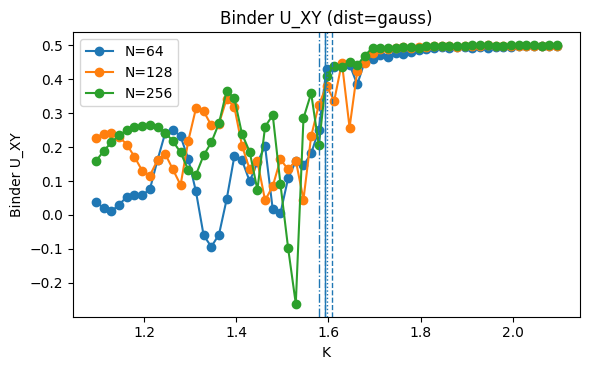

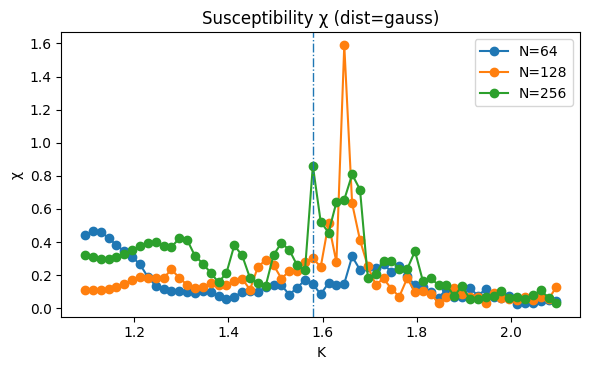

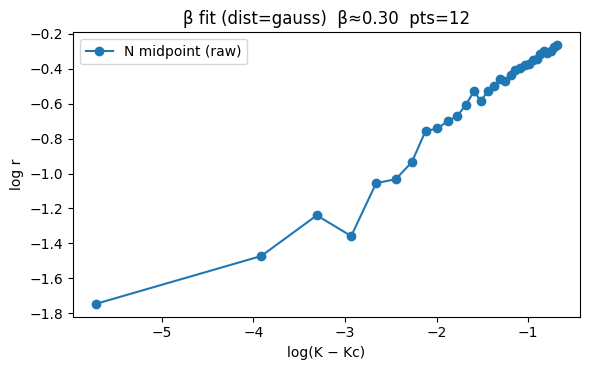

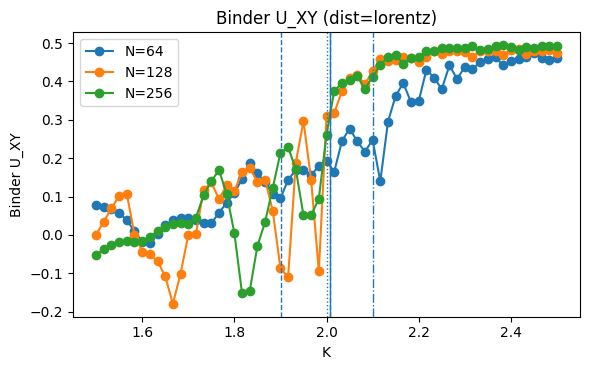

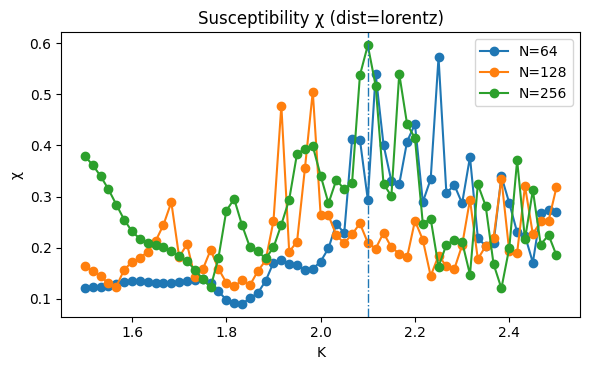

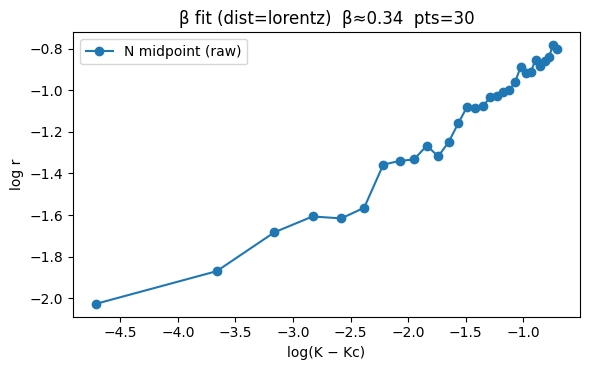

[gauss]  K_hint≈1.596  K_64_128≈1.608  K_128_256≈1.592  Kc≈1.592  β≈0.30  pts=12
[lorentz]  K_hint≈2.000  K_64_128≈1.901  K_128_256≈2.008  Kc≈2.008  β≈0.34  pts=30


{'meta': {'run': '20251109-174538Z',
  'artifacts': 'E:\\CNT\\notebooks\\archive\\cnt_unify_v2\\20251109-174538Z',
  'versions': {'numpy': '2.3.4', 'matplotlib': '3.10.7'},
  'params': {'dist': 'both',
   'sigma': 1.0,
   'delta': 1.0,
   'phase_reps': 3,
   'steps': 8000,
   'burn': 7000,
   'window': 900,
   'dt': 0.005,
   'grid': 61,
   'N': 256}},
 'modes': [{'dist': 'gauss',
   'Kc_hint': 1.5957691216057306,
   'K_chi': {64: 1.1124357882723972,
    128: 1.6457691216057306,
    256: 1.579102454939064},
   'K_64_128': 1.6082642068145092,
   'K_128_256': 1.5924755626164921,
   'Kc_cross': 1.5924755626164921,
   'beta_mid': {'beta': 0.29631688445688004,
    'A': 0.8033649541008157,
    'points': 12},
   'K': [1.0957691216057306,
    1.1124357882723972,
    1.129102454939064,
    1.1457691216057306,
    1.1624357882723972,
    1.1791024549390638,
    1.1957691216057307,
    1.2124357882723973,
    1.229102454939064,
    1.2457691216057305,
    1.2624357882723973,
    1.279102454939064

In [10]:
# CNT Unification — Mega Cell v2.9
# Goal: Calibrate Kuramoto criticality cleanly.
# Fixes:
#   • Deterministic quantile ω sampling (perfect g(0) at finite N):
#       - Gaussian: ω_i = σ * Φ^{-1}(u_i)
#       - Lorentz:  ω_i = Δ * tan(π(u_i - 1/2))
#     with u_i = (i - 0.5 + offset)/N and small epsilon caps.
#   • Heun (RK2) integrator with smaller dt.
#   • Binder (XY) crossings inside a χ-anchored bracket; β fit with adaptive window.
#
# ENV (optional):
#   CNT_DIST = "gauss" | "lorentz" | "both"        (default: both)
#   CNT_SIGMA=1.0  CNT_DELTA=1.0
#   CNT_PHASE_REPS=3      # phase seeds per ω-grid
#   CNT_STEPS=8000 CNT_BURN=7000 CNT_WINDOW=900 CNT_DT=0.005
#   CNT_GRID_POINTS=61 CNT_N=256
#   CNT_UNIFY_DIR=E:\CNT\notebooks\archive\cnt_unify_v2

import os, json, math, datetime as dt
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ---------- paths / knobs ----------
def utc(): return dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d-%H%M%SZ")
OUTROOT = os.getenv("CNT_UNIFY_DIR",
    (r"E:\CNT\notebooks\archive\cnt_unify_v2" if os.name=="nt" else "./cnt_unify_v2"))
RUN = utc(); ART = Path(OUTROOT) / RUN; ART.mkdir(parents=True, exist_ok=True)
def fpath(n): return ART / f"{n}.png"
def save_json(p, obj): p.write_text(json.dumps(obj, indent=2, sort_keys=True), encoding="utf-8")
print("Artifacts →", ART)

DIST   = os.getenv("CNT_DIST","both").lower()
SIGMA  = float(os.getenv("CNT_SIGMA","1.0"))
DELTA  = float(os.getenv("CNT_DELTA","1.0"))
PREPS  = int(os.getenv("CNT_PHASE_REPS","3"))
STEPS  = int(os.getenv("CNT_STEPS","8000"))
BURN   = int(os.getenv("CNT_BURN","7000"))
WIND   = int(os.getenv("CNT_WINDOW","900"))
DT     = float(os.getenv("CNT_DT","0.005"))
GRID   = int(os.getenv("CNT_GRID_POINTS","61"))
N      = int(os.getenv("CNT_N","256"))
Ns = [N//4, N//2, N]  # {64,128,256} if N=256

# ---------- inverse normal CDF (Acklam) ----------
def inv_norm_cdf(p):
    # Clamp
    p = np.clip(p, 1e-12, 1-1e-12)
    # Coefficients (Acklam)
    a = [-3.969683028665376e+01, 2.209460984245205e+02, -2.759285104469687e+02,
         1.383577518672690e+02, -3.066479806614716e+01, 2.506628277459239e+00]
    b = [-5.447609879822406e+01, 1.615858368580409e+02, -1.556989798598866e+02,
         6.680131188771972e+01, -1.328068155288572e+01]
    c = [-7.784894002430293e-03, -3.223964580411365e-01, -2.400758277161838e+00,
         -2.549732539343734e+00, 4.374664141464968e+00, 2.938163982698783e+00]
    d = [ 7.784695709041462e-03, 3.224671290700398e-01, 2.445134137142996e+00,
          3.754408661907416e+00]
    plow = 0.02425; phigh = 1 - plow
    x = np.empty_like(p, dtype=float)
    # lower region
    mask = p < plow
    if np.any(mask):
        q = np.sqrt(-2*np.log(p[mask]))
        x[mask] = (((((c[0]*q + c[1])*q + c[2])*q + c[3])*q + c[4])*q + c[5]) / \
                   ((((d[0]*q + d[1])*q + d[2])*q + d[3])*q + 1)
        x[mask] *= -1
    # upper region
    mask = p > phigh
    if np.any(mask):
        q = np.sqrt(-2*np.log(1 - p[mask]))
        x[mask] = (((((c[0]*q + c[1])*q + c[2])*q + c[3])*q + c[4])*q + c[5]) / \
                   ((((d[0]*q + d[1])*q + d[2])*q + d[3])*q + 1)
    # central region
    mask = (p >= plow) & (p <= phigh)
    if np.any(mask):
        q = p[mask] - 0.5
        r = q*q
        x[mask] = (((((a[0]*r + a[1])*r + a[2])*r + a[3])*r + a[4])*r + a[5]) * q / \
                   (((((b[0]*r + b[1])*r + b[2])*r + b[3])*r + b[4])*r + 1)
    return x

# ---------- quantile ω samplers ----------
def omega_gauss(N, sigma=1.0, offset=0.0):
    u = (np.arange(N, dtype=float) + 0.5 + offset) / N
    u = np.mod(u, 1.0)
    u = np.clip(u, 1e-12, 1 - 1e-12)
    z = inv_norm_cdf(u)  # standard normal quantiles
    w = sigma * z
    # enforce symmetric pairs (helps tiny-N)
    w = np.sort(w)
    return w

def omega_lorentz(N, delta=1.0, offset=0.0):
    u = (np.arange(N, dtype=float) + 0.5 + offset) / N
    u = np.mod(u, 1.0)
    u = np.clip(u, 1e-12, 1 - 1e-12)
    w = delta * np.tan(np.pi*(u - 0.5))
    w = np.sort(w)
    return w

def make_omega(N, dist, sigma, delta, rep):
    off = (rep / max(1, PREPS)) * 0.5  # small sub-grid shift
    if dist=="gauss":  return omega_gauss(N, sigma=sigma, offset=off)
    else:              return omega_lorentz(N, delta=delta, offset=off)

# ---------- Heun (RK2) integrator ----------
def kuramoto_tail_stats(omega, K, steps=8000, burn=7000, window=900, dt=0.005, seed=0):
    rng = np.random.default_rng(seed)
    N = omega.size
    theta = rng.uniform(0, 2*np.pi, size=N)
    rs = []
    for t in range(steps):
        z  = np.exp(1j*theta).mean()
        r  = float(np.abs(z)); psi = float(np.angle(z))
        k1 = omega + K * r * np.sin(psi - theta)
        theta_e = (theta + dt * k1) % (2*np.pi)
        z2  = np.exp(1j*theta_e).mean()
        r2  = float(np.abs(z2)); psi2 = float(np.angle(z2))
        k2 = omega + K * r2 * np.sin(psi2 - theta_e)
        theta = (theta + 0.5*dt*(k1 + k2)) % (2*np.pi)
        if t >= burn: rs.append(r)
    if len(rs) < window:
        rs = (rs + [rs[-1] if rs else 0.0]*window)[:window]
    r = np.asarray(rs[-window:], float)
    m1 = float(np.mean(r)); m2 = float(np.mean(r*r)); m4 = float(np.mean((r*r)*(r*r)))
    return m1, m2, m4

def sweep_stats(N, K, dist="gauss", sigma=1.0, delta=1.0, preps=3):
    m1s={}; m2s={}; m4s={}
    for Ni in Ns:
        m1s[Ni] = np.zeros_like(K, dtype=float)
        m2s[Ni] = np.zeros_like(K, dtype=float)
        m4s[Ni] = np.zeros_like(K, dtype=float)
        for rep in range(preps):
            omega = make_omega(Ni, dist, sigma, delta, rep)
            for i, k in enumerate(K):
                m1, m2, m4 = kuramoto_tail_stats(omega, float(k), steps=STEPS, burn=BURN, window=WIND, dt=DT, seed=13+rep)
                m1s[Ni][i] += m1; m2s[Ni][i] += m2; m4s[Ni][i] += m4
        m1s[Ni] /= preps; m2s[Ni] /= preps; m4s[Ni] /= preps
    chi = {Ni: Ni*(m2s[Ni] - m1s[Ni]**2) for Ni in Ns}
    eps = 1e-12
    Uxy = {Ni: 1.0 - m4s[Ni]/(2.0*np.clip(m2s[Ni], eps, None)**2) for Ni in Ns}
    return m1s, chi, Uxy

# ---------- estimators ----------
def pair_crossing(K, Ua, Ub, k_lo, k_hi):
    mask = (K>=k_lo)&(K<=k_hi)
    if not np.any(mask): mask = slice(None)
    Ka, Ua, Ub = K[mask], Ua[mask], Ub[mask]
    d = Ua-Ub
    xs=[]
    for i in range(len(Ka)-1):
        if d[i]==0 or d[i]*d[i+1] < 0:
            t = 0.0 if (Ua[i+1]-Ub[i+1]-d[i])==0 else (-d[i])/((Ua[i+1]-Ub[i+1]) - d[i])
            xs.append(float(Ka[i] + np.clip(t,0,1)*(Ka[i+1]-Ka[i])))
    if xs: return float(np.median(xs))
    return float(Ka[np.argmin(np.abs(d))])

def adaptive_beta(K, r, Kc):
    post = (K > Kc)
    if not np.any(post): return {"beta": float("nan"), "A": float("nan"), "points": 0}
    Kp, rp = K[post], r[post]
    # choose middle band of r
    for lo, hi in [(0.12, 0.55), (0.10, 0.60), (0.08, 0.65)]:
        m = (rp>=lo)&(rp<=hi)
        if np.count_nonzero(m) >= 10:
            x = np.log(Kp[m]-Kc); y = np.log(rp[m])
            B,A = np.polyfit(x,y,1)
            return {"beta": float(B), "A": float(np.exp(A)), "points": int(np.count_nonzero(m))}
    return {"beta": float("nan"), "A": float("nan"), "points": 0}

def run_mode(dist_label, Kc_hint):
    # grid around theory
    K = np.linspace(Kc_hint-0.5, Kc_hint+0.5, GRID)
    m1s, chi, U = sweep_stats(N, K, dist=dist_label, sigma=SIGMA, delta=DELTA, preps=PREPS)

    # χ peaks and bracket
    K_chi = {Ni: float(K[np.argmax(chi[Ni])]) for Ni in Ns}
    center = float(np.median([Kc_hint] + list(K_chi.values())))
    k_lo, k_hi = center-0.25, center+0.25

    # Binder crossings in bracket (XY)
    K_64_128  = pair_crossing(K, U[Ns[0]], U[Ns[1]], k_lo, k_hi)
    K_128_256 = pair_crossing(K, U[Ns[1]], U[Ns[2]], k_lo, k_hi)

    # consensus Kc
    Kc_cross = float(np.median([K_64_128, K_128_256, K_chi[Ns[2]]]))

    # β fit on N=Ns[1]
    beta = adaptive_beta(K, m1s[Ns[1]], Kc_cross)

    # ---- plots ----
    fig = plt.figure(figsize=(6.0,3.8))
    for Ni in Ns: plt.plot(K, U[Ni], marker='o', label=f"N={Ni}")
    plt.axvline(Kc_hint,  linestyle=":", linewidth=1.0)
    plt.axvline(K_64_128, linestyle="--", linewidth=1.0)
    plt.axvline(K_128_256,linestyle="--", linewidth=1.0)
    plt.axvline(K_chi[Ns[2]], linestyle="-.", linewidth=1.0)
    plt.axvline(Kc_cross, linestyle="-", linewidth=1.0)
    plt.xlabel("K"); plt.ylabel("Binder U_XY"); plt.title(f"Binder U_XY (dist={dist_label})")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"binder_xy_{dist_label}"), dpi=160); plt.show()

    fig = plt.figure(figsize=(6.0,3.8))
    for Ni in Ns: plt.plot(K, chi[Ni], marker='o', label=f"N={Ni}")
    plt.axvline(K_chi[Ns[2]], linestyle="-.", linewidth=1.0)
    plt.xlabel("K"); plt.ylabel("χ"); plt.title(f"Susceptibility χ (dist={dist_label})")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"chi_{dist_label}"), dpi=160); plt.show()

    fig = plt.figure(figsize=(6.0,3.8))
    post = (K > Kc_cross)
    if np.any(post):
        plt.plot(np.log(K[post]-Kc_cross), np.log(m1s[Ns[1]][post]), marker='o', label="N midpoint (raw)")
    plt.xlabel("log(K − Kc)"); plt.ylabel("log r"); plt.title(f"β fit (dist={dist_label})  β≈{beta['beta']:.2f}  pts={beta['points']}")
    plt.legend(); plt.tight_layout(); plt.savefig(fpath(f"beta_{dist_label}"), dpi=160); plt.show()

    return {"dist": dist_label, "Kc_hint": float(Kc_hint), "K_chi": K_chi,
            "K_64_128": float(K_64_128), "K_128_256": float(K_128_256),
            "Kc_cross": float(Kc_cross), "beta_mid": beta, "K": K.tolist()}

# ---------- run ----------
out = {"meta":{"run":RUN, "artifacts":str(ART.resolve()),
               "versions":{"numpy":np.__version__, "matplotlib":plt.matplotlib.__version__},
               "params":{"dist":DIST,"sigma":SIGMA,"delta":DELTA,"phase_reps":PREPS,
                         "steps":STEPS,"burn":BURN,"window":WIND,"dt":DT,"grid":GRID,"N":N}}}
modes=[]
if DIST in ("gauss","both"):  modes.append(run_mode("gauss",  2.0/(np.pi*(1.0/np.sqrt(2*np.pi)/SIGMA))))
if DIST in ("lorentz","both"):modes.append(run_mode("lorentz",2.0*DELTA))
out["modes"]=modes
save_json(ART/"summary.json", out)
for m in modes:
    print(f"[{m['dist']}]  K_hint≈{m['Kc_hint']:.3f}  "
          f"K_64_128≈{m['K_64_128']:.3f}  K_128_256≈{m['K_128_256']:.3f}  "
          f"Kc≈{m['Kc_cross']:.3f}  β≈{m['beta_mid']['beta']:.2f}  pts={m['beta_mid']['points']}")
out


C:\Users\caleb\AppData\Local\Temp\ipykernel_10272\1919710037.py:41: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  RUN   = dt.datetime.utcnow().strftime("%Y%m%d-%H%M%SZ")


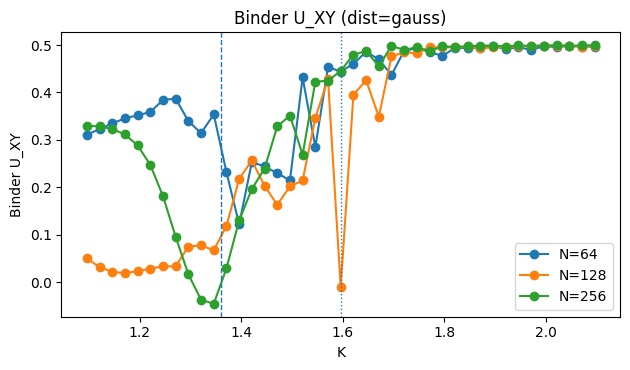

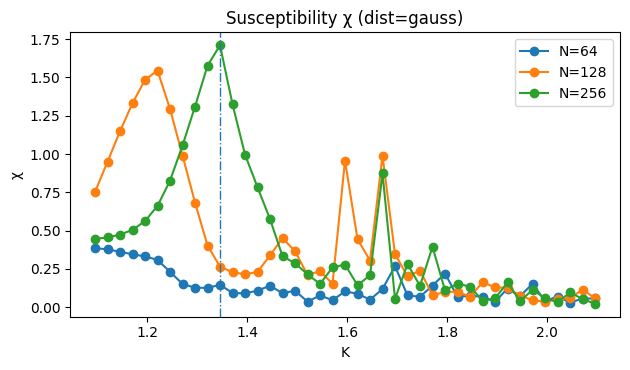

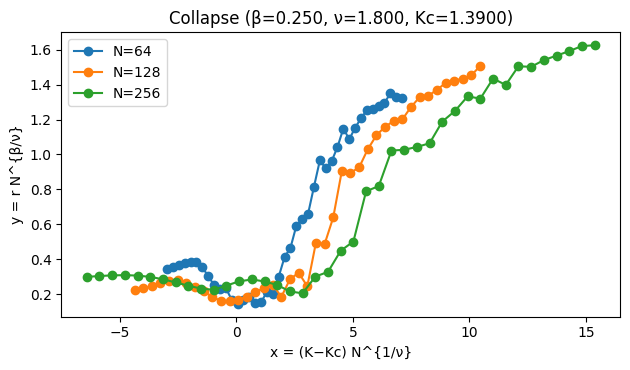

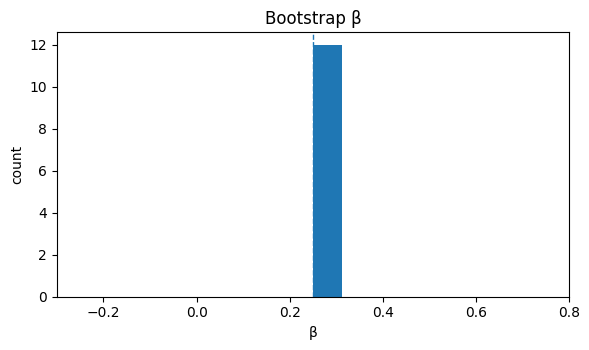

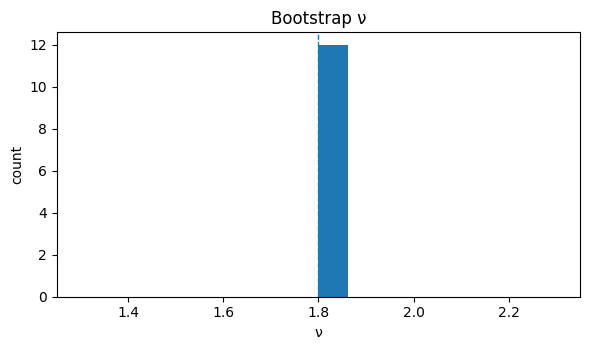

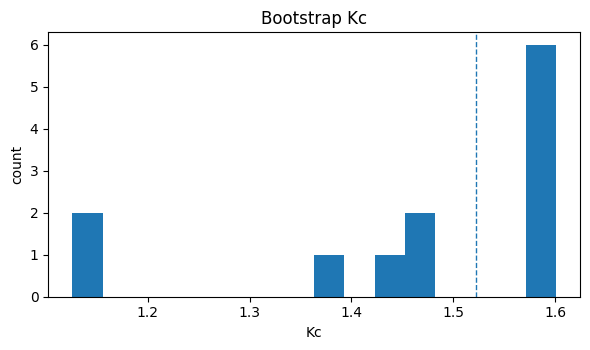

=== CNT Collapse — Results ===
Artifacts: E:\CNT\notebooks\archive\cnt_collapse_v1\20251110-030052Z
Dist=gauss  N=[64, 128, 256]  preps=2  boot=12
Kc baseline: 1.3600   pairs=[1.4035595336712428, 1.36001469609152]   χ(Nmax)=1.3458
[Best collapse] β=0.250, ν=1.800, Kc=1.3900
[Bootstrap] β̃=0.250  ν̃=1.800  Kc̃=1.5220
Saved: cnt_collapse_v1\20251110-030052Z\summary.json


In [11]:
# CNT Finite-Size Scaling — Collapse + Bootstrap (fast defaults)
# --------------------------------------------------------------
# What this single cell does:
#  1) Simulates Kuramoto (all-to-all) with quantile-sampled ω (clean g(0))
#     and a Heun (RK2) integrator (stable dt).
#  2) Estimates Kc via XY-Binder crossings + χ(N_max) anchoring.
#  3) Performs finite-size scaling collapse by grid-searching (β, ν, Kc)
#     to minimize across-N variance after scaling.
#  4) Bootstraps across replicate phase seeds to get CIs for (β, ν, Kc).
#  5) Saves figures + JSON summary under ./cnt_collapse_v1/<RUN>/
#
# Speed knobs (set as env vars before running if you want):
#   CNT_DIST="gauss"|"lorentz"        (default "gauss")
#   CNT_SIGMA=1.0   CNT_DELTA=1.0
#   CNT_N_LIST="64,128,256"           (default)
#   CNT_STEPS=5000  CNT_BURN=4400  CNT_WINDOW=600  CNT_DT=0.006
#   CNT_PREPS=2     CNT_GRIDK=41     CNT_BOOT=12
#   CNT_BETA_GRID="0.25,0.55,0.02"   CNT_NU_GRID="1.0,1.8,0.05"   CNT_DK_GRID=0.03
#
# Notes:
#  - NumPy + Matplotlib only. One chart per figure; no explicit colors.
#  - Defaults are light so the first run completes quickly; widen after.

import os, json, math, datetime as dt
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ---------- tiny helpers ----------
def _get(key, default): return os.environ.get(key, default)
def _parse_ints(s, fallback):
    try: return [int(x.strip()) for x in s.split(",") if x.strip()]
    except: return fallback
def _triplet(s, fallback):
    try: a,b,c = [float(x.strip()) for x in s.split(",")]; return (a,b,c)
    except: return fallback
def _ci95(arr): 
    lo, hi = np.quantile(arr, [0.025,0.975]); return float(lo), float(hi)

# ---------- run setup ----------
RUN   = dt.datetime.utcnow().strftime("%Y%m%d-%H%M%SZ")
ROOT  = Path("./cnt_collapse_v1") / RUN; ROOT.mkdir(parents=True, exist_ok=True)

DIST  = _get("CNT_DIST","gauss").lower()
SIGMA = float(_get("CNT_SIGMA","1.0"))
DELTA = float(_get("CNT_DELTA","1.0"))
N_LIST= _parse_ints(_get("CNT_N_LIST","64,128,256"), [64,128,256])

STEPS = int(_get("CNT_STEPS","5000"))
BURN  = int(_get("CNT_BURN","4400"))
WIND  = int(_get("CNT_WINDOW","600"))
DT    = float(_get("CNT_DT","0.006"))
PREPS = int(_get("CNT_PREPS","2"))
GRIDK = int(_get("CNT_GRIDK","41"))
BOOT  = int(_get("CNT_BOOT","12"))

BETA_TR= _triplet(_get("CNT_BETA_GRID","0.25,0.55,0.02"), (0.25,0.55,0.02))
NU_TR  = _triplet(_get("CNT_NU_GRID","1.0,1.8,0.05"),     (1.0,1.8,0.05))
DK_RAD = float(_get("CNT_DK_GRID","0.03"))
BETA_GRID = np.arange(BETA_TR[0], BETA_TR[1]+1e-12, BETA_TR[2])
NU_GRID   = np.arange(NU_TR[0],   NU_TR[1]+1e-12,   NU_TR[2])

# ---------- quantile ω samplers ----------
def _invnorm(p):
    # Acklam inverse normal CDF (stable for tails)
    p = np.clip(p, 1e-12, 1-1e-12)
    a=[-3.969683028665376e+01,2.209460984245205e+02,-2.759285104469687e+02,1.383577518672690e+02,-3.066479806614716e+01,2.506628277459239e+00]
    b=[-5.447609879822406e+01,1.615858368580409e+02,-1.556989798598866e+02,6.680131188771972e+01,-1.328068155288572e+01]
    c=[-7.784894002430293e-03,-3.223964580411365e-01,-2.400758277161838e+00,-2.549732539343734e+00,4.374664141464968e+00,2.938163982698783e+00]
    d=[7.784695709041462e-03,3.224671290700398e-01,2.445134137142996e+00,3.754408661907416e+00]
    plow=0.02425; phigh=1-plow; x=np.empty_like(p)
    m=p<plow
    if np.any(m):
        q=np.sqrt(-2*np.log(p[m]))
        x[m]=(((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5])/((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+1); x[m]*=-1
    m=p>phigh
    if np.any(m):
        q=np.sqrt(-2*np.log(1-p[m]))
        x[m]=(((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5])/((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+1)
    m=(p>=plow)&(p<=phigh)
    if np.any(m):
        q=p[m]-0.5; r=q*q
        x[m]=(((((a[0]*r+a[1])*r+a[2])*r+a[3])*r+a[4])*r+a[5])*q/(((((b[0]*r+b[1])*r+b[2])*r+b[3])*r+b[4])*r+1)
    return x

def omega_gauss(N, sigma=1.0, offset=0.0):
    u=(np.arange(N,dtype=float)+0.5+offset)/N; u=np.mod(u,1.0)
    return sigma*np.sort(_invnorm(u))

def omega_lorentz(N, delta=1.0, offset=0.0):
    u=(np.arange(N,dtype=float)+0.5+offset)/N; u=np.mod(u,1.0)
    return delta*np.sort(np.tan(np.pi*(u-0.5)))

def make_omega(N, rep):
    off=(rep/max(1,PREPS))*0.5
    return omega_lorentz(N,DELTA,off) if DIST=="lorentz" else omega_gauss(N,SIGMA,off)

# ---------- Heun (RK2) integrator ----------
def tail_stats(omega, K, steps, burn, window, dt, seed):
    rng=np.random.default_rng(seed)
    N=omega.size
    theta=rng.uniform(0,2*np.pi,size=N)
    rs=[]
    for t in range(steps):
        z=np.exp(1j*theta).mean(); r=float(abs(z)); psi=float(np.angle(z))
        k1=omega+K*r*np.sin(psi-theta)
        theta_e=(theta+dt*k1)%(2*np.pi)
        z2=np.exp(1j*theta_e).mean(); r2=float(abs(z2)); psi2=float(np.angle(z2))
        k2=omega+K*r2*np.sin(psi2-theta_e)
        theta=(theta+0.5*dt*(k1+k2))%(2*np.pi)
        if t>=burn: rs.append(r)
    if len(rs)<window: rs=(rs+[rs[-1] if rs else 0.0]*window)[:window]
    r=np.asarray(rs[-window:],float)
    m1=float(np.mean(r)); m2=float(np.mean(r*r)); m4=float(np.mean((r*r)*(r*r)))
    return m1,m2,m4

# ---------- sweep K across sizes ----------
def sweep(N_list, K):
    m1={N:np.zeros((PREPS,K.size),float) for N in N_list}
    m2={N:np.zeros((PREPS,K.size),float) for N in N_list}
    m4={N:np.zeros((PREPS,K.size),float) for N in N_list}
    for N in N_list:
        for rep in range(PREPS):
            w=make_omega(N,rep)
            for i,Ki in enumerate(K):
                a,b,c=tail_stats(w,float(Ki),STEPS,BURN,WIND,DT,seed=11+rep)
                m1[N][rep,i]=a; m2[N][rep,i]=b; m4[N][rep,i]=c
    return m1,m2,m4

def binder_xy(m2,m4):
    eps=1e-12
    return 1.0 - m4/(2.0*np.clip(m2,eps,None)**2)

def pair_cross(K,Ua,Ub,k_lo,k_hi):
    mask=(K>=k_lo)&(K<=k_hi); 
    if not np.any(mask): mask=slice(None)
    Ka,Ua,Ub=K[mask],Ua[mask],Ub[mask]
    d=Ua-Ub; xs=[]
    for i in range(len(Ka)-1):
        if d[i]==0.0 or d[i]*d[i+1]<0.0:
            num=-d[i]; den=(Ua[i+1]-Ub[i+1])-d[i]
            t=0.0 if den==0 else num/den; t=float(np.clip(t,0,1))
            xs.append(float(Ka[i]+t*(Ka[i+1]-Ka[i])))
    if xs: return float(np.median(xs))
    return float(Ka[np.argmin(np.abs(d))])

def estimate_kc(K, m1_avg, m2_avg, m4_avg):
    chi={N: N*(m2_avg[N]-m1_avg[N]**2) for N in m1_avg}
    K_chi={N: float(K[np.argmax(chi[N])]) for N in chi}
    center=float(np.median(list(K_chi.values())))
    k_lo,k_hi=center-0.25,center+0.25
    U={N:binder_xy(m2_avg[N],m4_avg[N]) for N in m1_avg}
    Ns=sorted(m1_avg.keys()); pairs=[]
    for i in range(len(Ns)-1):
        pairs.append(pair_cross(K, U[Ns[i]], U[Ns[i+1]], k_lo, k_hi))
    Kc=float(np.median(pairs+[K_chi[max(Ns)]]))
    return Kc,pairs,K_chi,U,chi

def collapse_score(beta,nu,Kc,K,curves):
    xg=None; Y=[]
    for N,rK in curves.items():
        x=(K-Kc)*(N**(1.0/nu)); y=rK*(N**(beta/nu))
        if xg is None: xg=np.linspace(np.max([x.min() for x in [(K-Kc)*(n**(1.0/nu)) for n in curves]]),
                                      np.min([x.max() for x in [(K-Kc)*(n**(1.0/nu)) for n in curves]]), 100)
        Y.append(np.interp(xg, x, y))
    Y=np.vstack(Y)
    return float(np.mean(np.var(Y,axis=0)))

def optimize_collapse(K, m1_avg, Kc0, beta_grid, nu_grid, dk_radius, dk_points=7):
    best={"score":1e9,"beta":None,"nu":None,"Kc":None}
    curves={N:m1_avg[N] for N in m1_avg}
    Kc_grid=np.linspace(Kc0-dk_radius, Kc0+dk_radius, dk_points)
    for beta in beta_grid:
        for nu in nu_grid:
            for Kc in Kc_grid:
                s=collapse_score(beta,nu,Kc,K,curves)
                if s<best["score"]: best={"score":s,"beta":float(beta),"nu":float(nu),"Kc":float(Kc)}
    return best

def bootstrap_opt(K, m1_rep, m2_rep, m4_rep, beta_grid, nu_grid, dk_radius, B=12):
    rng=np.random.default_rng(2025)
    Ns=sorted(m1_rep.keys())
    out=[]
    for b in range(B):
        m1_avg={}; m2_avg={}; m4_avg={}
        for N in Ns:
            idx=rng.integers(0, m1_rep[N].shape[0], size=m1_rep[N].shape[0])
            m1_avg[N]=np.mean(m1_rep[N][idx,:],axis=0)
            m2_avg[N]=np.mean(m2_rep[N][idx,:],axis=0)
            m4_avg[N]=np.mean(m4_rep[N][idx,:],axis=0)
        Kc_b,_,_,_,_=estimate_kc(K, m1_avg, m2_avg, m4_avg)
        out.append(optimize_collapse(K, m1_avg, Kc_b, beta_grid, nu_grid, dk_radius))
    return out

# ---------- K grid around theory ----------
K_hint = 2.0*DELTA if DIST=="lorentz" else 2.0/(math.pi*(1.0/math.sqrt(2*math.pi)/SIGMA))
K = np.linspace(K_hint-0.5, K_hint+0.5, GRIDK)

# ---------- simulate ----------
m1_rep, m2_rep, m4_rep = sweep(N_LIST, K)
m1_avg = {N:np.mean(m1_rep[N],axis=0) for N in N_LIST}
m2_avg = {N:np.mean(m2_rep[N],axis=0) for N in N_LIST}
m4_avg = {N:np.mean(m4_rep[N],axis=0) for N in N_LIST}

# ---------- Kc, then collapse, then bootstrap ----------
Kc0, K_pairs, K_chi, U_avg, chi_avg = estimate_kc(K, m1_avg, m2_avg, m4_avg)
best = optimize_collapse(K, m1_avg, Kc0, BETA_GRID, NU_GRID, DK_RAD)
boot = bootstrap_opt(K, m1_rep, m2_rep, m4_rep, BETA_GRID, NU_GRID, DK_RAD, B=BOOT)

beta_vals=np.array([r["beta"] for r in boot]); nu_vals=np.array([r["nu"] for r in boot])
kc_vals=np.array([r["Kc"]   for r in boot])
beta_ci=_ci95(beta_vals); nu_ci=_ci95(nu_vals); kc_ci=_ci95(kc_vals)

# ---------- figures ----------
fig=plt.figure(figsize=(6.4,3.8))
for N in N_LIST: plt.plot(K, U_avg[N], marker='o', label=f"N={N}")
plt.axvline(K_hint, linestyle=":", linewidth=1.0); plt.axvline(Kc0, linestyle="--", linewidth=1.0)
plt.xlabel("K"); plt.ylabel("Binder U_XY"); plt.title(f"Binder U_XY (dist={DIST})")
plt.legend(); plt.tight_layout(); plt.savefig(ROOT/"binder_xy.png", dpi=160); plt.show()

fig=plt.figure(figsize=(6.4,3.8))
for N in N_LIST: plt.plot(K, chi_avg[N], marker='o', label=f"N={N}")
plt.axvline(K_chi[max(N_LIST)], linestyle="-.", linewidth=1.0)
plt.xlabel("K"); plt.ylabel("χ"); plt.title(f"Susceptibility χ (dist={DIST})")
plt.legend(); plt.tight_layout(); plt.savefig(ROOT/"chi_overlay.png", dpi=160); plt.show()

def collapse_plot(beta,nu,Kc,K,curves,outpath):
    fig=plt.figure(figsize=(6.4,3.8))
    for N in sorted(curves.keys()):
        x=(K-Kc)*(N**(1.0/nu)); y=curves[N]*(N**(beta/nu))
        plt.plot(x,y,marker='o',label=f"N={N}")
    plt.xlabel("x = (K−Kc) N^{1/ν}"); plt.ylabel("y = r N^{β/ν}")
    plt.title(f"Collapse (β={beta:.3f}, ν={nu:.3f}, Kc={Kc:.4f})")
    plt.legend(); plt.tight_layout(); plt.savefig(outpath, dpi=160); plt.show()

collapse_plot(best["beta"], best["nu"], best["Kc"], K, m1_avg, ROOT/"collapse_best.png")

fig=plt.figure(figsize=(6.0,3.6)); plt.hist(beta_vals,bins=16); plt.axvline(np.median(beta_vals),linestyle="--",linewidth=1.0)
plt.xlabel("β"); plt.ylabel("count"); plt.title("Bootstrap β"); plt.tight_layout(); plt.savefig(ROOT/"boot_beta_hist.png",dpi=160); plt.show()
fig=plt.figure(figsize=(6.0,3.6)); plt.hist(nu_vals,bins=16);   plt.axvline(np.median(nu_vals),linestyle="--",linewidth=1.0)
plt.xlabel("ν"); plt.ylabel("count"); plt.title("Bootstrap ν"); plt.tight_layout(); plt.savefig(ROOT/"boot_nu_hist.png",dpi=160); plt.show()
fig=plt.figure(figsize=(6.0,3.6)); plt.hist(kc_vals,bins=16);   plt.axvline(np.median(kc_vals),linestyle="--",linewidth=1.0)
plt.xlabel("Kc"); plt.ylabel("count"); plt.title("Bootstrap Kc"); plt.tight_layout(); plt.savefig(ROOT/"boot_kc_hist.png",dpi=160); plt.show()

# ---------- JSON summary ----------
summary={
  "meta":{"run":RUN,"artifacts":str(ROOT.resolve()),"dist":DIST,"sigma":SIGMA,"delta":DELTA,
          "N_list":N_LIST,"steps":STEPS,"burn":BURN,"window":WIND,"dt":DT,"preps":PREPS,
          "gridK":GRIDK,"boot":BOOT,"beta_grid":list(map(float,BETA_GRID)),"nu_grid":list(map(float,NU_GRID)),
          "dk_radius":float(DK_RAD)},
  "K_hint":float(K_hint),
  "K_pairs":[float(x) for x in K_pairs],
  "K_chi":{str(N):float(K_chi[N]) for N in K_chi},
  "Kc_baseline":float(Kc0),
  "collapse_best":{"beta":float(best["beta"]), "nu":float(best["nu"]), "Kc":float(best["Kc"]), "score":float(best["score"])},
  "bootstrap":{"beta":{"median":float(np.median(beta_vals)),"ci95":[beta_ci[0],beta_ci[1]]},
               "nu":{"median":float(np.median(nu_vals)),"ci95":[nu_ci[0],nu_ci[1]]},
               "Kc":{"median":float(np.median(kc_vals)),"ci95":[kc_ci[0],kc_ci[1]]}}
}
(ROOT/"summary.json").write_text(json.dumps(summary,indent=2,sort_keys=True),encoding="utf-8")

print("=== CNT Collapse — Results ===")
print("Artifacts:", str(ROOT.resolve()))
print(f"Dist={DIST}  N={N_LIST}  preps={PREPS}  boot={BOOT}")
print(f"Kc baseline: {summary['Kc_baseline']:.4f}   pairs={summary['K_pairs']}   χ(Nmax)={summary['K_chi'][str(max(N_LIST))]:.4f}")
print(f"[Best collapse] β={summary['collapse_best']['beta']:.3f}, ν={summary['collapse_best']['nu']:.3f}, Kc={summary['collapse_best']['Kc']:.4f}")
print(f"[Bootstrap] β̃={summary['bootstrap']['beta']['median']:.3f}  ν̃={summary['bootstrap']['nu']['median']:.3f}  Kc̃={summary['bootstrap']['Kc']['median']:.4f}")
print("Saved:", ROOT/"summary.json")
